In [2]:
from sklearn.datasets import fetch_20newsgroups
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from collections import defaultdict
import gensim
from InitKmeans import InitKmeans
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
     
def pre_processData(newsgroups_train):
    tokenizer = RegexpTokenizer(r'\w+')
    for i in range(len(newsgroups_train)):
        newsgroups_train[i] = newsgroups_train[i].lower()
        #newsgroups_train[i] = tokenizer.tokenize(newsgroups_train[i])
    #newsgroups_train = [[token for token in doc if not token.isdigit()] for doc in newsgroups_train]
    newsgroups_train = [doc.split(' ') for doc in newsgroups_train]
    return newsgroups_train
from sklearn.datasets import fetch_20newsgroups
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from collections import defaultdict
import gensim
from InitKmeans import InitKmeans
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
import sys  
import json
if __name__ == "__main__":
    newsgroups_train = list()
    news_labels = {}
    docID_username = {}
    
    i = 0
    file_path="D:/part_news_biterm.txt"
    with open(file_path) as fp:
        lines = fp.read().split("\n")
        for line in lines:
            if line:
                text = json.loads(line)["bitermText"].strip()
                label = json.loads(line)["clusterNo"]
                newsgroups_train.append(text)
                news_labels[i] = label
                i+=1
    fp.close()
    
    corpus = pre_processData(newsgroups_train)

D:\anacoda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
doc_biterm = {}
for docID in range(len(corpus)):
    words = corpus[docID]
    duplicate_biterm = []
    doc_biterm[docID] = {}
    for biterm in words:
        hash_biterm = set(biterm.split(','))
        if hash_biterm not in duplicate_biterm:
            duplicate_biterm.append(hash_biterm)
            doc_biterm[docID][biterm] = 1
        else:
            if biterm in doc_biterm[docID].keys():
                doc_biterm[docID][biterm] += 1
            else:
                doc_biterm[docID][biterm] = 1

In [4]:
doc_words = {}
i_biterm = 0
for docID in range(len(corpus)):
    doc_words[docID] = {}
    words = corpus[docID]
    for biterm in words:
        for word in biterm.split(','):
            if word not in doc_words[docID].keys():
                doc_words[docID][word] = 0
            doc_words[docID][word] += 1

In [67]:
total_batch = 16
NMI_batch = {}
start = 0
end = 0
for batch_i in range(1,17):
    if batch_i == 16:
        end = int(len(corpus))
    else:
        end = int(len(corpus) / total_batch) * batch_i
    print(start,' ,',end)
    
    if batch_i != 1:
        start = int(len(corpus) / total_batch) * (batch_i -1) + 1
    

0  , 694
0  , 1388
695  , 2082
1389  , 2776
2083  , 3470
2777  , 4164
3471  , 4858
4165  , 5552
4859  , 6246
5553  , 6940
6247  , 7634
6941  , 8328
7635  , 9022
8329  , 9716
9023  , 10410
9717  , 11109


In [84]:
total_batch = 16
NMI_batch = {}
start = 0
end = 0
topic_batch = {}
for batch_i in range(1,17):
    if batch_i == 16:
        end = int(len(corpus))
    else:
        end = int(len(corpus) / total_batch) * batch_i
    
    docID_assign_z = {}
    m_z = {}
    n_z = {}
    n_w = {}
    n_b = {}
    Topics = []
    V = set()
    D = set()
    alpha = 0.006
    beta = 0.02
    NMI_batch[batch_i] = 0
    topic_batch[batch_i] = 0
    
    total_iter = 10
    for iter in range(total_iter):
        for docID in range(start,end):
            words = corpus[docID]
            D.discard(docID)
            if docID in docID_assign_z.keys():
                before_k = docID_assign_z[docID]
                m_z[before_k].discard(docID)
                for biterm in words:
                    for word in biterm.split(','):
                        n_z[before_k][word] -= 1
                        n_w[before_k] -=1
            else:
                before_k = -1
            if len(D) == 0 and len(V) == 0:
                choose_k = 0
                D.add(docID)
                docID_assign_z[docID] = choose_k
                if choose_k not in m_z.keys():
                    m_z[choose_k] = set()
                m_z[choose_k].add(docID)
                for biterm in words:
                    for word in biterm.split(','):
                        if choose_k not in n_w.keys():
                            n_w[choose_k] = 0
                        if choose_k not in n_z.keys():
                            n_z[choose_k] = {}
                        if word not in n_z[choose_k].keys():
                            n_z[choose_k][word] = 0
                        n_z[choose_k][word] += 1
                        n_w[choose_k] += 1
                        V.add(word)
                if choose_k not in Topics:
                    Topics.append(choose_k)
            else:
                log_pro = []
                for k in Topics:
                    pro_k = len(m_z[k])
                    if pro_k != 0:
                        i = 0
                        for biterm in words:
                            each_word = biterm.strip().split(',')
                            for word in each_word:
                                if word not in n_z[k].keys():
                                    n_z[k][word] = 0
                            for j in range(doc_biterm[docID][biterm]):
                                pro_k *= (n_z[k][each_word[0]] + n_z[k][each_word[-1]] + beta + j) / ( n_w[k] + len(V)*beta + i) 
                                i += 1

                    if pro_k == 0:
                        pro_k = sys.float_info.min
                    log_pro.append(pro_k)

                pro_new_k = alpha*(len(D))
                i = 0
                for biterm in words:
                    for j in range(doc_biterm[docID][biterm]):
                        pro_new_k *= ( beta + j) / ( len(V)*beta + i) 
                        i += 1

                if pro_new_k == 0:
                    pro_new_k = sys.float_info.min        
                log_pro.append(pro_new_k)

                sum_pro=sum(log_pro)

                normalized_posterior = [i/sum_pro for i in log_pro]    
                select_k = None
                if iter == (total_iter - 1):
                    select_k = normalized_posterior.index(max(normalized_posterior))

                else:
                    select_k = np.random.choice( (len(Topics)+1) , 1, p=normalized_posterior)[0]  

                if select_k == len(Topics):
                    choose_k = np.max(Topics) + 1
                else:
                    choose_k = Topics[select_k]

                D.add(docID)
                docID_assign_z[docID] = choose_k
                if choose_k not in m_z.keys():
                    m_z[choose_k] = set()
                m_z[choose_k].add(docID)
                for biterm in words:
                    for word in biterm.split(','):
                        if choose_k not in n_w.keys():
                            n_w[choose_k] = 0
                        if choose_k not in n_z.keys():
                            n_z[choose_k] = {}
                        if word not in n_z[choose_k].keys():
                            n_z[choose_k][word] = 0
                        n_z[choose_k][word] += 1
                        n_w[choose_k] += 1
                        V.add(word)
                if choose_k not in Topics:
                    Topics.append(choose_k)

            count_k = []
            for k in Topics:
                if k in m_z.keys() and len(m_z[k]) == 0:
                    m_z.pop(k, None)
                    n_z.pop(k, None)
                    n_w.pop(k, None)
                    count_k.append(k)
            for k in count_k:
                Topics.remove(k)   
        if iter == 9:
            from sklearn.metrics.cluster import normalized_mutual_info_score
            nmi_sample = []
            nmi_result = []
            for key, value in news_labels.items():
                if key < end and key >= start:
                    nmi_sample.append(value)
                    nmi_result.append(docID_assign_z[key])
            NMI_batch[batch_i] = normalized_mutual_info_score(np.array(nmi_sample), np.array(nmi_result))
            topic_batch[batch_i] = len(Topics)
            print("start ",start, " end ",end, "topics: ",len(Topics),"truth: ",len(np.unique(nmi_sample)), " NMI: ",normalized_mutual_info_score(np.array(nmi_sample), np.array(nmi_result)))
    if batch_i != 1:
        start = int(len(corpus) / total_batch) * (batch_i -1) + 1
    

start  0  end  694 topics:  32 truth:  7  NMI:  0.7932582930963841
start  0  end  1388 topics:  47 truth:  14  NMI:  0.8393106954884539
start  695  end  2082 topics:  40 truth:  15  NMI:  0.8657532862687363
start  1389  end  2776 topics:  39 truth:  16  NMI:  0.8452884887545633
start  2083  end  3470 topics:  46 truth:  22  NMI:  0.7983718780828861
start  2777  end  4164 topics:  47 truth:  20  NMI:  0.8109112137938168
start  3471  end  4858 topics:  31 truth:  20  NMI:  0.8440927354522494
start  4165  end  5552 topics:  33 truth:  20  NMI:  0.9368629379023037
start  4859  end  6246 topics:  28 truth:  13  NMI:  0.9334904144279972
start  5553  end  6940 topics:  28 truth:  12  NMI:  0.9048536947695016
start  6247  end  7634 topics:  40 truth:  17  NMI:  0.8339690063152223
start  6941  end  8328 topics:  44 truth:  17  NMI:  0.7513985583695252
start  7635  end  9022 topics:  45 truth:  14  NMI:  0.7701360467836332
start  8329  end  9716 topics:  60 truth:  35  NMI:  0.8765568662398848
s

In [70]:
print(NMI_batch)
print(beta)

{1: 0.7876026632745371, 2: 0.827800211461006, 3: 0.849184378431291, 4: 0.8451070637231864, 5: 0.7940263049058457, 6: 0.8223017427037164, 7: 0.894809842293581, 8: 0.9304533179753635, 9: 0.9258334908567185, 10: 0.8671163169954504, 11: 0.8267156927049686, 12: 0.7559150585932306, 13: 0.7429415055990873, 14: 0.8554031568460954, 15: 0.8809880682292323, 16: 0.864387575010974}
0.02


In [37]:
print(NMI_batch)
print(beta)

{1: 0.7807571712292335, 2: 0.7353371500768504, 3: 0.8502379665820626, 4: 0.7568467649998681, 5: 0.8162603125655135, 6: 0.7384914886844951, 7: 0.8817509328360829, 8: 0.9262823960426699, 9: 0.8467387891408699, 10: 0.7468509988023818, 11: 0.7701970178448285, 12: 0.6695341040965438, 13: 0.7100150422673754, 14: 0.938811063904104, 15: 0.8005716749232908, 16: 0.8628986521502694}
0.02


In [71]:
common_keys = []

item_NMI = []
for key,value in sorted(NMI_batch.items(), key=lambda x: x[0]):
    common_keys.append(key)
    item_NMI.append(value)
print(common_keys)

print()

print(item_NMI)

print()

print(np.mean(item_NMI))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

[0.7876026632745371, 0.827800211461006, 0.849184378431291, 0.8451070637231864, 0.7940263049058457, 0.8223017427037164, 0.894809842293581, 0.9304533179753635, 0.9258334908567185, 0.8671163169954504, 0.8267156927049686, 0.7559150585932306, 0.7429415055990873, 0.8554031568460954, 0.8809880682292323, 0.864387575010974]

0.8419116493502677


In [ ]:
[0.7263768698570344, 0.711761630290239, 0.8022782823944489, 0.6841966941455346, 0.800192310703258, 0.6554101119389474, 0.8505780460589412, 0.8178944886111228, 0.7864579635775842, 0.683214857506468, 0.7595475457343436, 0.6432240481649325, 0.7110312603727696, 0.9251360087760134, 0.7885714553012659, 0.8468117216274558]

In [5]:
total_batch = 16
NMI_batch = {}
start = 0
end = 0
topic_batch = {}
for batch_i in range(1,17):
    if batch_i == 16:
        end = int(len(corpus))
    else:
        end = int(len(corpus) / total_batch) * batch_i
    
    docID_assign_z = {}
    m_z = {}
    n_z = {}
    n_w = {}
    n_b = {}
    Topics = []
    V = set()
    D = set()
    alpha = 0.6
    beta = 0.02
    NMI_batch[batch_i] = 0
    topic_batch[batch_i] = 0
    
    total_iter = 10
    for iter in range(total_iter):
        for docID in range(start,end):
            words = corpus[docID]
            D.discard(docID)
            if docID in docID_assign_z.keys():
                before_k = docID_assign_z[docID]
                m_z[before_k].discard(docID)
                for biterm in words:
                    for word in biterm.split(','):
                        n_z[before_k][word] -= 1
                        n_w[before_k] -=1
            else:
                before_k = -1
            if len(D) == 0 and len(V) == 0:
                choose_k = 0
                D.add(docID)
                docID_assign_z[docID] = choose_k
                if choose_k not in m_z.keys():
                    m_z[choose_k] = set()
                m_z[choose_k].add(docID)
                for biterm in words:
                    for word in biterm.split(','):
                        if choose_k not in n_w.keys():
                            n_w[choose_k] = 0
                        if choose_k not in n_z.keys():
                            n_z[choose_k] = {}
                        if word not in n_z[choose_k].keys():
                            n_z[choose_k][word] = 0
                        n_z[choose_k][word] += 1
                        n_w[choose_k] += 1
                        V.add(word)
                if choose_k not in Topics:
                    Topics.append(choose_k)
            else:
                log_pro = []
                for k in Topics:
                    pro_k = len(m_z[k])
                    if pro_k != 0:
                        i = 0
                        for biterm in words:
                            each_word = biterm.strip().split(',')
                            for word in each_word:
                                if word not in n_z[k].keys():
                                    n_z[k][word] = 0
                            for j in range(doc_biterm[docID][biterm]):
                                pro_k *= (n_z[k][each_word[0]] + n_z[k][each_word[-1]] + beta + j) / ( n_w[k] + len(V)*beta + i) 
                                i += 1

                    if pro_k == 0:
                        pro_k = sys.float_info.min
                    log_pro.append(pro_k)

                pro_new_k = alpha*(len(D))
                i = 0
                for biterm in words:
                    for j in range(doc_biterm[docID][biterm]):
                        pro_new_k *= ( beta + j) / ( len(V)*beta + i) 
                        i += 1

                if pro_new_k == 0:
                    pro_new_k = sys.float_info.min        
                log_pro.append(pro_new_k)

                sum_pro=sum(log_pro)

                normalized_posterior = [i/sum_pro for i in log_pro]    
                select_k = None
                if iter == (total_iter - 1):
                    select_k = normalized_posterior.index(max(normalized_posterior))

                else:
                    select_k = np.random.choice( (len(Topics)+1) , 1, p=normalized_posterior)[0]  

                if select_k == len(Topics):
                    choose_k = np.max(Topics) + 1
                else:
                    choose_k = Topics[select_k]

                D.add(docID)
                docID_assign_z[docID] = choose_k
                if choose_k not in m_z.keys():
                    m_z[choose_k] = set()
                m_z[choose_k].add(docID)
                for biterm in words:
                    for word in biterm.split(','):
                        if choose_k not in n_w.keys():
                            n_w[choose_k] = 0
                        if choose_k not in n_z.keys():
                            n_z[choose_k] = {}
                        if word not in n_z[choose_k].keys():
                            n_z[choose_k][word] = 0
                        n_z[choose_k][word] += 1
                        n_w[choose_k] += 1
                        V.add(word)
                if choose_k not in Topics:
                    Topics.append(choose_k)

            count_k = []
            for k in Topics:
                if k in m_z.keys() and len(m_z[k]) == 0:
                    m_z.pop(k, None)
                    n_z.pop(k, None)
                    n_w.pop(k, None)
                    count_k.append(k)
            for k in count_k:
                Topics.remove(k)   
        if iter == 9:
            from sklearn.metrics.cluster import normalized_mutual_info_score
            nmi_sample = []
            nmi_result = []
            for key, value in news_labels.items():
                if key < end and key >= start:
                    nmi_sample.append(value)
                    nmi_result.append(docID_assign_z[key])
            NMI_batch[batch_i] = normalized_mutual_info_score(np.array(nmi_sample), np.array(nmi_result))
            topic_batch[batch_i] = len(Topics)
            print("start ",start, " end ",end, "topics: ",len(Topics),"truth: ",len(np.unique(nmi_sample)), " NMI: ",normalized_mutual_info_score(np.array(nmi_sample), np.array(nmi_result)))
    if batch_i != 1:
        start = int(len(corpus) / total_batch) * (batch_i -1) + 1
    

start  0  end  694 topics:  38 truth:  7  NMI:  0.7831638760894735
start  0  end  1388 topics:  65 truth:  14  NMI:  0.8220203016171348
start  695  end  2082 topics:  48 truth:  15  NMI:  0.8448211212381675
start  1389  end  2776 topics:  53 truth:  16  NMI:  0.837416247169887
start  2083  end  3470 topics:  59 truth:  22  NMI:  0.7872571064087793
start  2777  end  4164 topics:  59 truth:  20  NMI:  0.8177930615118637
start  3471  end  4858 topics:  37 truth:  20  NMI:  0.8655318152576326
start  4165  end  5552 topics:  39 truth:  20  NMI:  0.9300827556516325
start  4859  end  6246 topics:  35 truth:  13  NMI:  0.9239963503346019
start  5553  end  6940 topics:  40 truth:  12  NMI:  0.8826140092766058
start  6247  end  7634 topics:  62 truth:  17  NMI:  0.8179001277585213
start  6941  end  8328 topics:  68 truth:  17  NMI:  0.7464233329135456
start  7635  end  9022 topics:  65 truth:  14  NMI:  0.7539135866439054
start  8329  end  9716 topics:  69 truth:  35  NMI:  0.8472499106932938
st

In [6]:
common_keys = []

item_NMI = []
for key,value in sorted(NMI_batch.items(), key=lambda x: x[0]):
    common_keys.append(key)
    item_NMI.append(value)
print(common_keys)

print()

print(item_NMI)

print()

print(np.mean(item_NMI))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

[0.7831638760894735, 0.8220203016171348, 0.8448211212381675, 0.837416247169887, 0.7872571064087793, 0.8177930615118637, 0.8655318152576326, 0.9300827556516325, 0.9239963503346019, 0.8826140092766058, 0.8179001277585213, 0.7464233329135456, 0.7539135866439054, 0.8472499106932938, 0.8707786624485065, 0.8589803405693434]

0.836871412848931


In [8]:
import timeit
total_batch = 16
NMI_batch = {}
start = 0
end = 0
topic_batch = {}
time_iteration_list = []
for batch_i in range(1,17):
    if batch_i == 16:
        end = int(len(corpus))
    else:
        end = int(len(corpus) / total_batch) * batch_i
    
    docID_assign_z = {}
    m_z = {}
    n_z = {}
    n_w = {}
    n_b = {}
    Topics = []
    V = set()
    D = set()
    alpha = 0.6
    beta = 0.02
    NMI_batch[batch_i] = 0
    topic_batch[batch_i] = 0
    
    time_start = timeit.default_timer()
    total_iter = 10
    for iter in range(total_iter):
        for docID in range(start,end):
            words = corpus[docID]
            D.discard(docID)
            if docID in docID_assign_z.keys():
                before_k = docID_assign_z[docID]
                m_z[before_k].discard(docID)
                for biterm in words:
                    for word in biterm.split(','):
                        n_z[before_k][word] -= 1
                        n_w[before_k] -=1
            else:
                before_k = -1
            if len(D) == 0 and len(V) == 0:
                choose_k = 0
                D.add(docID)
                docID_assign_z[docID] = choose_k
                if choose_k not in m_z.keys():
                    m_z[choose_k] = set()
                m_z[choose_k].add(docID)
                for biterm in words:
                    for word in biterm.split(','):
                        if choose_k not in n_w.keys():
                            n_w[choose_k] = 0
                        if choose_k not in n_z.keys():
                            n_z[choose_k] = {}
                        if word not in n_z[choose_k].keys():
                            n_z[choose_k][word] = 0
                        n_z[choose_k][word] += 1
                        n_w[choose_k] += 1
                        V.add(word)
                if choose_k not in Topics:
                    Topics.append(choose_k)
            else:
                log_pro = []
                for k in Topics:
                    pro_k = len(m_z[k])
                    if pro_k != 0:
                        i = 0
                        for biterm in words:
                            each_word = biterm.strip().split(',')
                            for word in each_word:
                                if word not in n_z[k].keys():
                                    n_z[k][word] = 0
                            for j in range(doc_biterm[docID][biterm]):
                                pro_k *= (n_z[k][each_word[0]] + n_z[k][each_word[-1]] + beta + j) / ( n_w[k] + len(V)*beta + i) 
                                i += 1

                    if pro_k == 0:
                        pro_k = sys.float_info.min
                    log_pro.append(pro_k)

                pro_new_k = alpha*(len(D))
                i = 0
                for biterm in words:
                    for j in range(doc_biterm[docID][biterm]):
                        pro_new_k *= ( beta + j) / ( len(V)*beta + i) 
                        i += 1

                if pro_new_k == 0:
                    pro_new_k = sys.float_info.min        
                log_pro.append(pro_new_k)

                sum_pro=sum(log_pro)

                normalized_posterior = [i/sum_pro for i in log_pro]    
                select_k = None
                if iter == (total_iter - 1):
                    select_k = normalized_posterior.index(max(normalized_posterior))

                else:
                    select_k = np.random.choice( (len(Topics)+1) , 1, p=normalized_posterior)[0]  

                if select_k == len(Topics):
                    choose_k = np.max(Topics) + 1
                else:
                    choose_k = Topics[select_k]

                D.add(docID)
                docID_assign_z[docID] = choose_k
                if choose_k not in m_z.keys():
                    m_z[choose_k] = set()
                m_z[choose_k].add(docID)
                for biterm in words:
                    for word in biterm.split(','):
                        if choose_k not in n_w.keys():
                            n_w[choose_k] = 0
                        if choose_k not in n_z.keys():
                            n_z[choose_k] = {}
                        if word not in n_z[choose_k].keys():
                            n_z[choose_k][word] = 0
                        n_z[choose_k][word] += 1
                        n_w[choose_k] += 1
                        V.add(word)
                if choose_k not in Topics:
                    Topics.append(choose_k)

            count_k = []
            for k in Topics:
                if k in m_z.keys() and len(m_z[k]) == 0:
                    m_z.pop(k, None)
                    n_z.pop(k, None)
                    n_w.pop(k, None)
                    count_k.append(k)
            for k in count_k:
                Topics.remove(k)   
        if iter == 9:
            from sklearn.metrics.cluster import normalized_mutual_info_score
            nmi_sample = []
            nmi_result = []
            for key, value in news_labels.items():
                if key < end and key >= start:
                    nmi_sample.append(value)
                    nmi_result.append(docID_assign_z[key])
            NMI_batch[batch_i] = normalized_mutual_info_score(np.array(nmi_sample), np.array(nmi_result))
            topic_batch[batch_i] = len(Topics)
            print("start ",start, " end ",end, "topics: ",len(Topics),"truth: ",len(np.unique(nmi_sample)), " NMI: ",normalized_mutual_info_score(np.array(nmi_sample), np.array(nmi_result)))
    if batch_i != 1:
        start = int(len(corpus) / total_batch) * (batch_i -1) + 1
    time_stop = timeit.default_timer()
    time_iteration_list.append(time_stop-time_start)
    print(time_iteration_list)

start  0  end  694 topics:  37 truth:  7  NMI:  0.7857091396081535
[10.75770830998431]
start  0  end  1388 topics:  66 truth:  14  NMI:  0.829918010709333
[10.75770830998431, 30.894945177906266]
start  695  end  2082 topics:  52 truth:  15  NMI:  0.8578682295338514
[10.75770830998431, 30.894945177906266, 24.345516054215523]
start  1389  end  2776 topics:  50 truth:  16  NMI:  0.8304931813448703
[10.75770830998431, 30.894945177906266, 24.345516054215523, 22.346055696759322]
start  2083  end  3470 topics:  62 truth:  22  NMI:  0.7864258515929868
[10.75770830998431, 30.894945177906266, 24.345516054215523, 22.346055696759322, 27.04905308658408]
start  2777  end  4164 topics:  59 truth:  20  NMI:  0.8225616199624589
[10.75770830998431, 30.894945177906266, 24.345516054215523, 22.346055696759322, 27.04905308658408, 24.522255297195443]
start  3471  end  4858 topics:  39 truth:  20  NMI:  0.8703873134375756
[10.75770830998431, 30.894945177906266, 24.345516054215523, 22.346055696759322, 27.04905

In [12]:
print(len(time_iteration_list))
print(topic_batch.keys())

16
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])


In [13]:
print(topic_batch.keys())
print(topic_batch.values())

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
dict_values([37, 66, 52, 50, 62, 59, 39, 39, 35, 41, 58, 62, 58, 73, 81, 73])


In [ ]:
0.8419116493502677

In [23]:
alpha_NMI = {}
alpha_topics = {}
for alpha in np.arange(0.1,1.1,0.1):
    alpha = np.around(alpha,decimals=1)
    
    total_batch = 16
    NMI_batch = {}
    start = 0
    end = 0
    topic_batch = {}
    time_iteration_list = []
    for batch_i in range(1,17):
        if batch_i == 16:
            end = int(len(corpus))
        else:
            end = int(len(corpus) / total_batch) * batch_i

        docID_assign_z = {}
        m_z = {}
        n_z = {}
        n_w = {}
        n_b = {}
        Topics = []
        V = set()
        D = set()
        #alpha = 0.6
        beta = 0.02
        NMI_batch[batch_i] = 0
        topic_batch[batch_i] = 0

        time_start = timeit.default_timer()
        total_iter = 10
        for iter in range(total_iter):
            for docID in range(start,end):
                words = corpus[docID]
                D.discard(docID)
                if docID in docID_assign_z.keys():
                    before_k = docID_assign_z[docID]
                    m_z[before_k].discard(docID)
                    for biterm in words:
                        for word in biterm.split(','):
                            n_z[before_k][word] -= 1
                            n_w[before_k] -=1
                else:
                    before_k = -1
                if len(D) == 0 and len(V) == 0:
                    choose_k = 0
                    D.add(docID)
                    docID_assign_z[docID] = choose_k
                    if choose_k not in m_z.keys():
                        m_z[choose_k] = set()
                    m_z[choose_k].add(docID)
                    for biterm in words:
                        for word in biterm.split(','):
                            if choose_k not in n_w.keys():
                                n_w[choose_k] = 0
                            if choose_k not in n_z.keys():
                                n_z[choose_k] = {}
                            if word not in n_z[choose_k].keys():
                                n_z[choose_k][word] = 0
                            n_z[choose_k][word] += 1
                            n_w[choose_k] += 1
                            V.add(word)
                    if choose_k not in Topics:
                        Topics.append(choose_k)
                else:
                    log_pro = []
                    for k in Topics:
                        pro_k = len(m_z[k])
                        if pro_k != 0:
                            i = 0
                            for biterm in words:
                                each_word = biterm.strip().split(',')
                                for word in each_word:
                                    if word not in n_z[k].keys():
                                        n_z[k][word] = 0
                                for j in range(doc_biterm[docID][biterm]):
                                    pro_k *= (n_z[k][each_word[0]] + n_z[k][each_word[-1]] + beta + j) / ( n_w[k] + len(V)*beta + i) 
                                    i += 1

                        if pro_k == 0:
                            pro_k = sys.float_info.min
                        log_pro.append(pro_k)

                    pro_new_k = alpha*(len(D))
                    i = 0
                    for biterm in words:
                        for j in range(doc_biterm[docID][biterm]):
                            pro_new_k *= ( beta + j) / ( len(V)*beta + i) 
                            i += 1

                    if pro_new_k == 0:
                        pro_new_k = sys.float_info.min        
                    log_pro.append(pro_new_k)

                    sum_pro=sum(log_pro)

                    normalized_posterior = [i/sum_pro for i in log_pro]    
                    select_k = None
                    if iter == (total_iter - 1):
                        select_k = normalized_posterior.index(max(normalized_posterior))

                    else:
                        select_k = np.random.choice( (len(Topics)+1) , 1, p=normalized_posterior)[0]  

                    if select_k == len(Topics):
                        choose_k = np.max(Topics) + 1
                    else:
                        choose_k = Topics[select_k]

                    D.add(docID)
                    docID_assign_z[docID] = choose_k
                    if choose_k not in m_z.keys():
                        m_z[choose_k] = set()
                    m_z[choose_k].add(docID)
                    for biterm in words:
                        for word in biterm.split(','):
                            if choose_k not in n_w.keys():
                                n_w[choose_k] = 0
                            if choose_k not in n_z.keys():
                                n_z[choose_k] = {}
                            if word not in n_z[choose_k].keys():
                                n_z[choose_k][word] = 0
                            n_z[choose_k][word] += 1
                            n_w[choose_k] += 1
                            V.add(word)
                    if choose_k not in Topics:
                        Topics.append(choose_k)

                count_k = []
                for k in Topics:
                    if k in m_z.keys() and len(m_z[k]) == 0:
                        m_z.pop(k, None)
                        n_z.pop(k, None)
                        n_w.pop(k, None)
                        count_k.append(k)
                for k in count_k:
                    Topics.remove(k)   
            if iter == 9:
                from sklearn.metrics.cluster import normalized_mutual_info_score
                nmi_sample = []
                nmi_result = []
                for key, value in news_labels.items():
                    if key < end and key >= start:
                        nmi_sample.append(value)
                        nmi_result.append(docID_assign_z[key])
                NMI_batch[batch_i] = normalized_mutual_info_score(np.array(nmi_sample), np.array(nmi_result))
                topic_batch[batch_i] = len(Topics)
                #print("start ",start, " end ",end, "topics: ",len(Topics),"truth: ",len(np.unique(nmi_sample)), " NMI: ",normalized_mutual_info_score(np.array(nmi_sample), np.array(nmi_result)))
        if batch_i != 1:
            start = int(len(corpus) / total_batch) * (batch_i -1) + 1
    
    alpha_NMI[alpha] = np.mean(list(NMI_batch.values()))
    alpha_topics[alpha] = int(np.mean(list(topic_batch.values())))
    print("alpha ",alpha, " NMI: ", alpha_NMI[alpha])
    print("alpha ",alpha, " Topics: ", alpha_topics[alpha])

alpha  0.1  NMI:  0.8440430528889936
alpha  0.1  Topics:  47
alpha  0.2  NMI:  0.8374321602197317
alpha  0.2  Topics:  50
alpha  0.3  NMI:  0.8407476183065268
alpha  0.3  Topics:  50
alpha  0.4  NMI:  0.8396202075437458
alpha  0.4  Topics:  53
alpha  0.5  NMI:  0.8394704694650799
alpha  0.5  Topics:  54
alpha  0.6  NMI:  0.8390834436622229
alpha  0.6  Topics:  55
alpha  0.7  NMI:  0.8347944016480231
alpha  0.7  Topics:  57
alpha  0.8  NMI:  0.8378035300650221
alpha  0.8  Topics:  58
alpha  0.9  NMI:  0.8353283741190873
alpha  0.9  Topics:  58
alpha  1.0  NMI:  0.8389952342399515
alpha  1.0  Topics:  59


In [24]:
print(alpha_NMI.values())
print(alpha_topics.values())

dict_values([0.8440430528889936, 0.8374321602197317, 0.8407476183065268, 0.8396202075437458, 0.8394704694650799, 0.8390834436622229, 0.8347944016480231, 0.8378035300650221, 0.8353283741190873, 0.8389952342399515])
dict_values([47, 50, 50, 53, 54, 55, 57, 58, 58, 59])


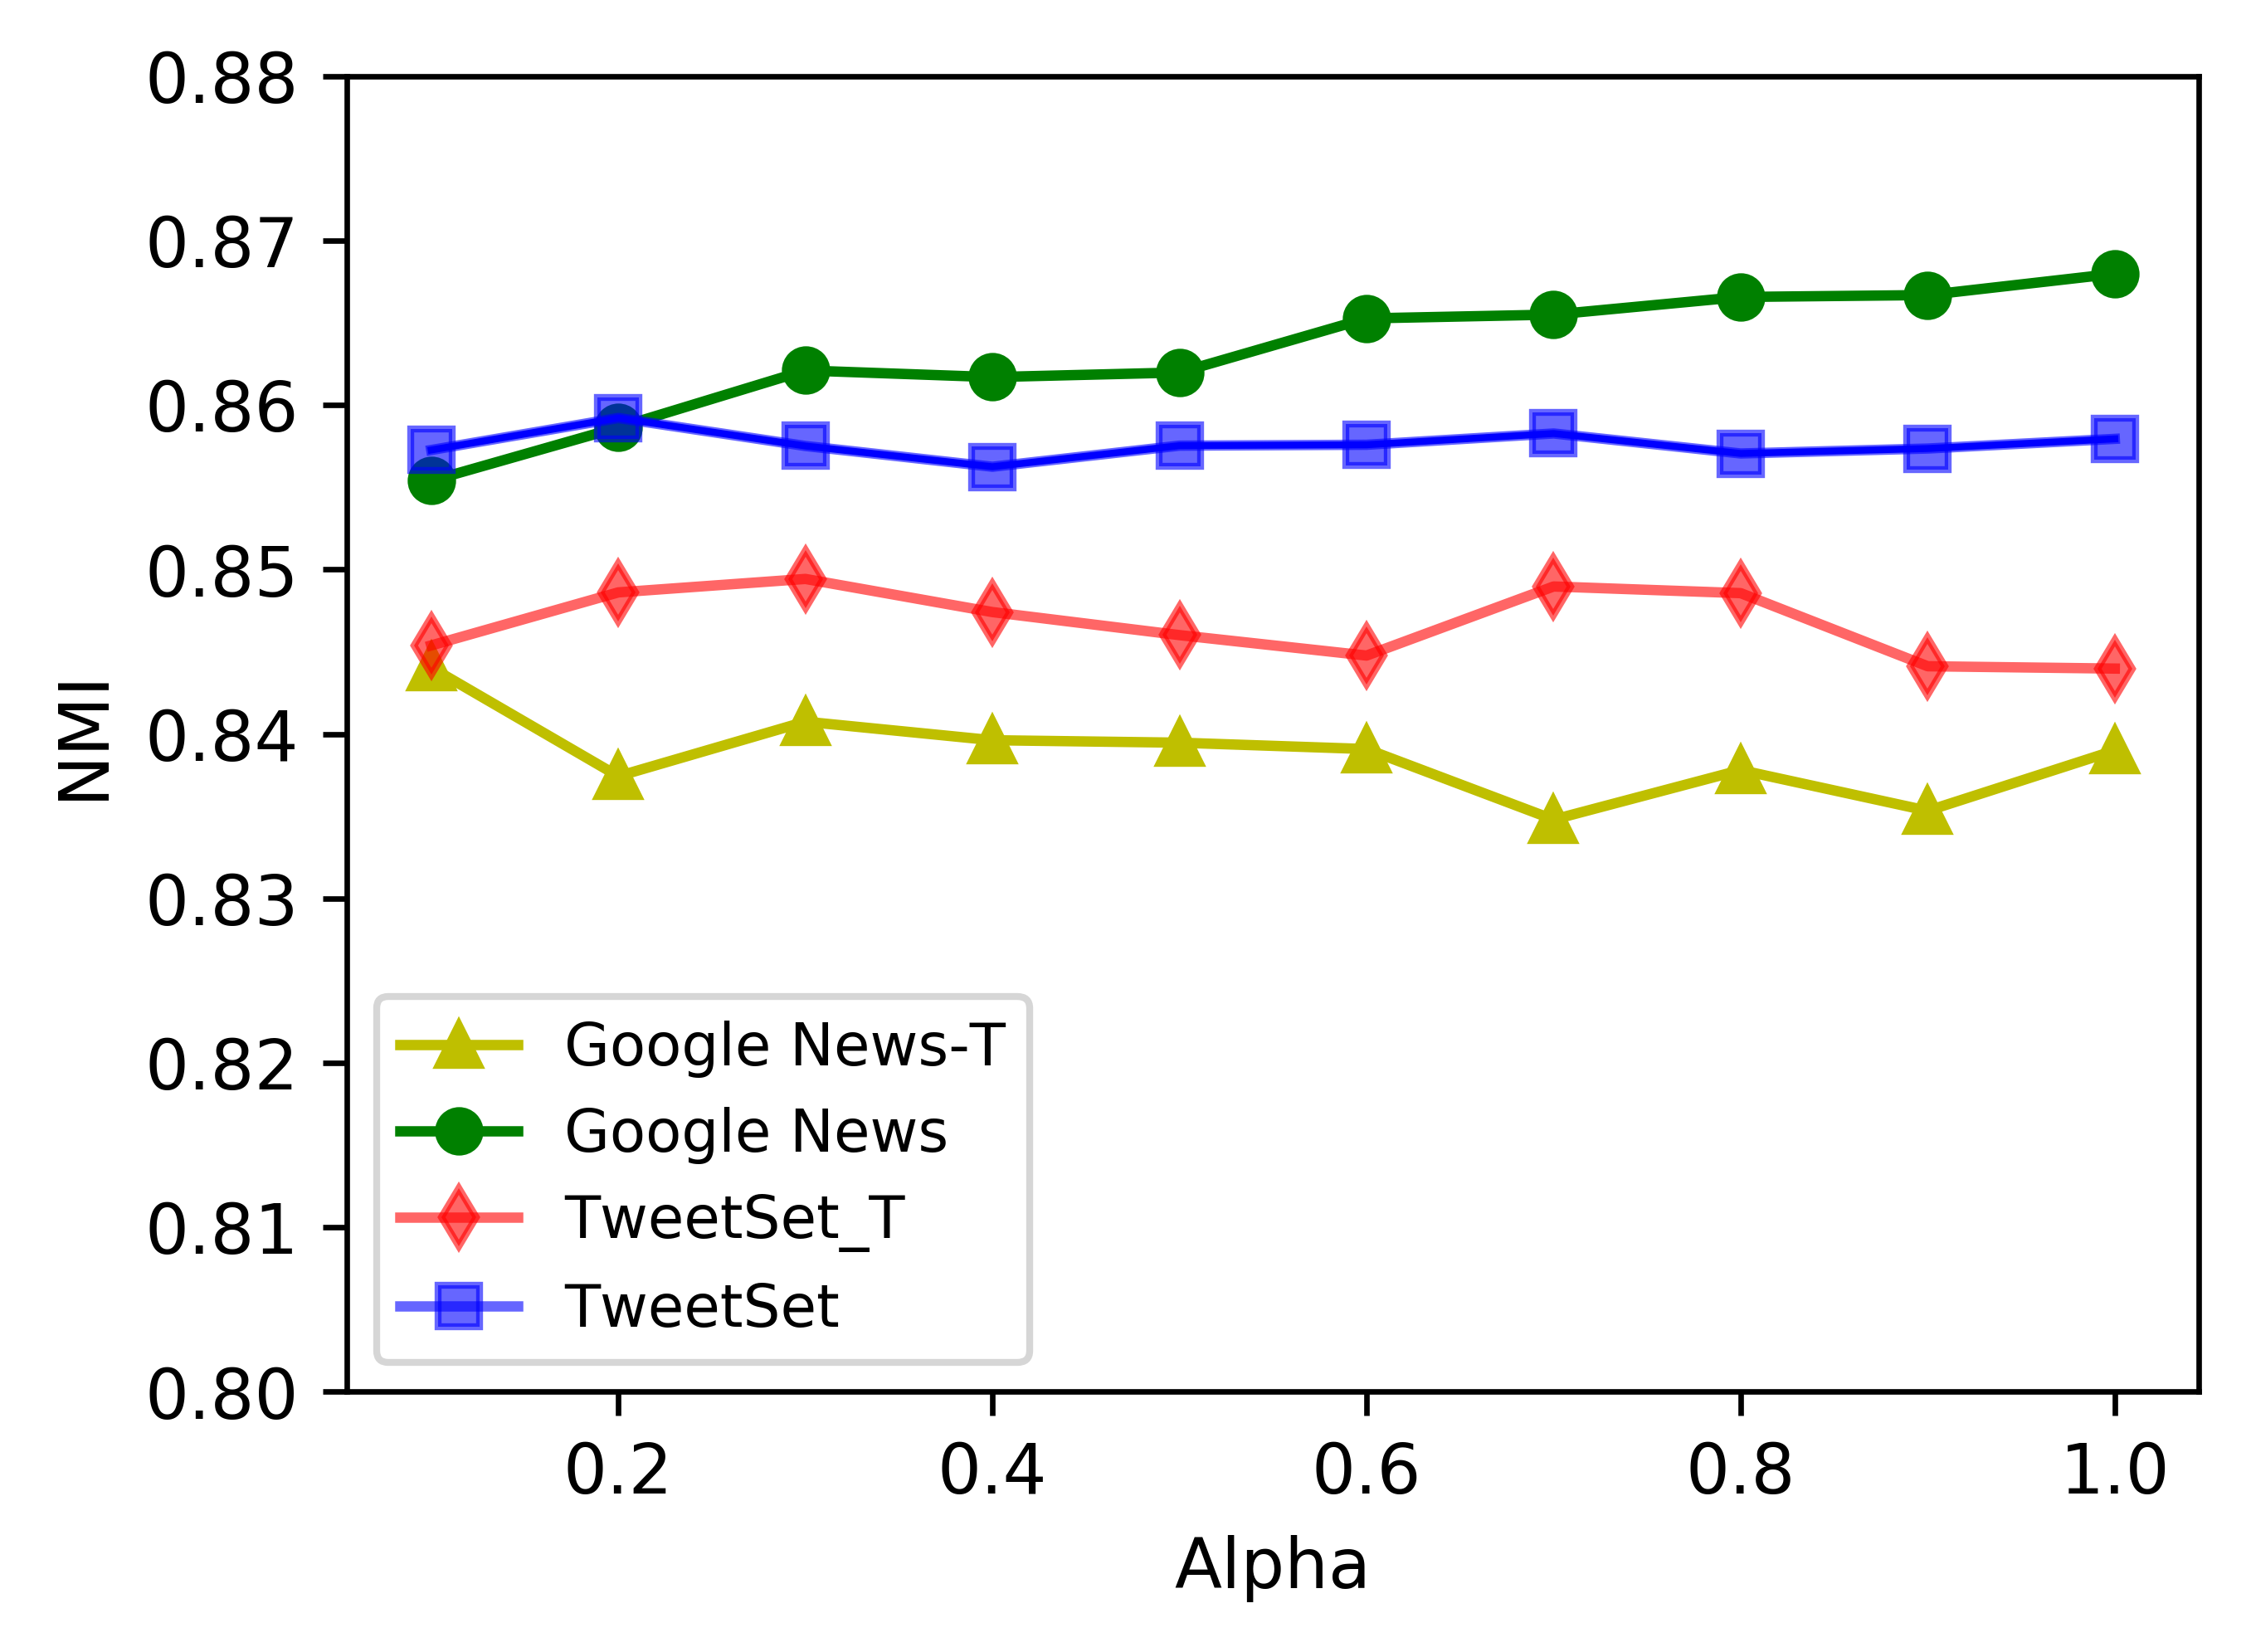

In [56]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
 
#设置x,y轴的数值（y=sinx）
#x = np.linspace(0, 10, 1000)
#y = np.sin(x)

x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

news_T = [0.8440430528889936, 0.8374321602197317, 0.8407476183065268, 0.8396202075437458, 0.8394704694650799, 0.8390834436622229, 0.8347944016480231, 0.8378035300650221, 0.8353283741190873, 0.8389952342399515]
f = plt.figure(figsize=(4.8,3.5),dpi = 600)
#plt.plot(x, news_T, 'g', lw=1)
plt.plot( x , news_T, c= 'y',marker="^", alpha=1,label="Google News-T") 

news = [0.8553973896584917, 0.8586395598047273, 0.8621052092575683, 0.8617021553300233, 0.8619820784046283, 0.8652709179319698, 0.865502768912514, 0.8665753557337122, 0.8666900836555417, 0.8679872662269225]
#plt.plot(x, news, 'r', lw=1)
plt.plot( x,news, c= 'g',marker="o", alpha=1,label="Google News") 

tweets_T = [0.8453845540783476, 0.8486100535419043, 0.84942774143682, 0.8474128102136836, 0.8460112095273967, 0.8447677521639362, 0.8489684822857698, 0.8485642574705066, 0.8441177310998838, 0.8439768970506967]
#plt.plot(x, tweets_T, 'r', lw=1)
plt.plot( x,tweets_T, c= 'r',marker="d", alpha=0.6,label="TweetSet_T") 

tweets = [0.857268408981715, 0.8592148717596345, 0.8575133376480126, 0.8562499910589776, 0.857533270578133, 0.8575866690811085, 0.8582720702474204, 0.8570571645878108, 0.8573575831418399, 0.8579458438287924]
plt.plot(x, tweets, 'b', lw=1)
plt.plot( x,tweets, c= 'b',marker="s", alpha=0.6,label="TweetSet") 

plt.xlabel("Alpha")
plt.ylabel("NMI")
 
#图表的标题
#plt.title("Performance")
 
#Y轴的范围
plt.ylim(0.8,0.88)
 
#显示图示
plt.legend( prop={'size': 8.5})
 
#显示图
plt.show()

f.savefig("./ijcai/NMIandAlpha-FP.pdf", bbox_inches='tight')


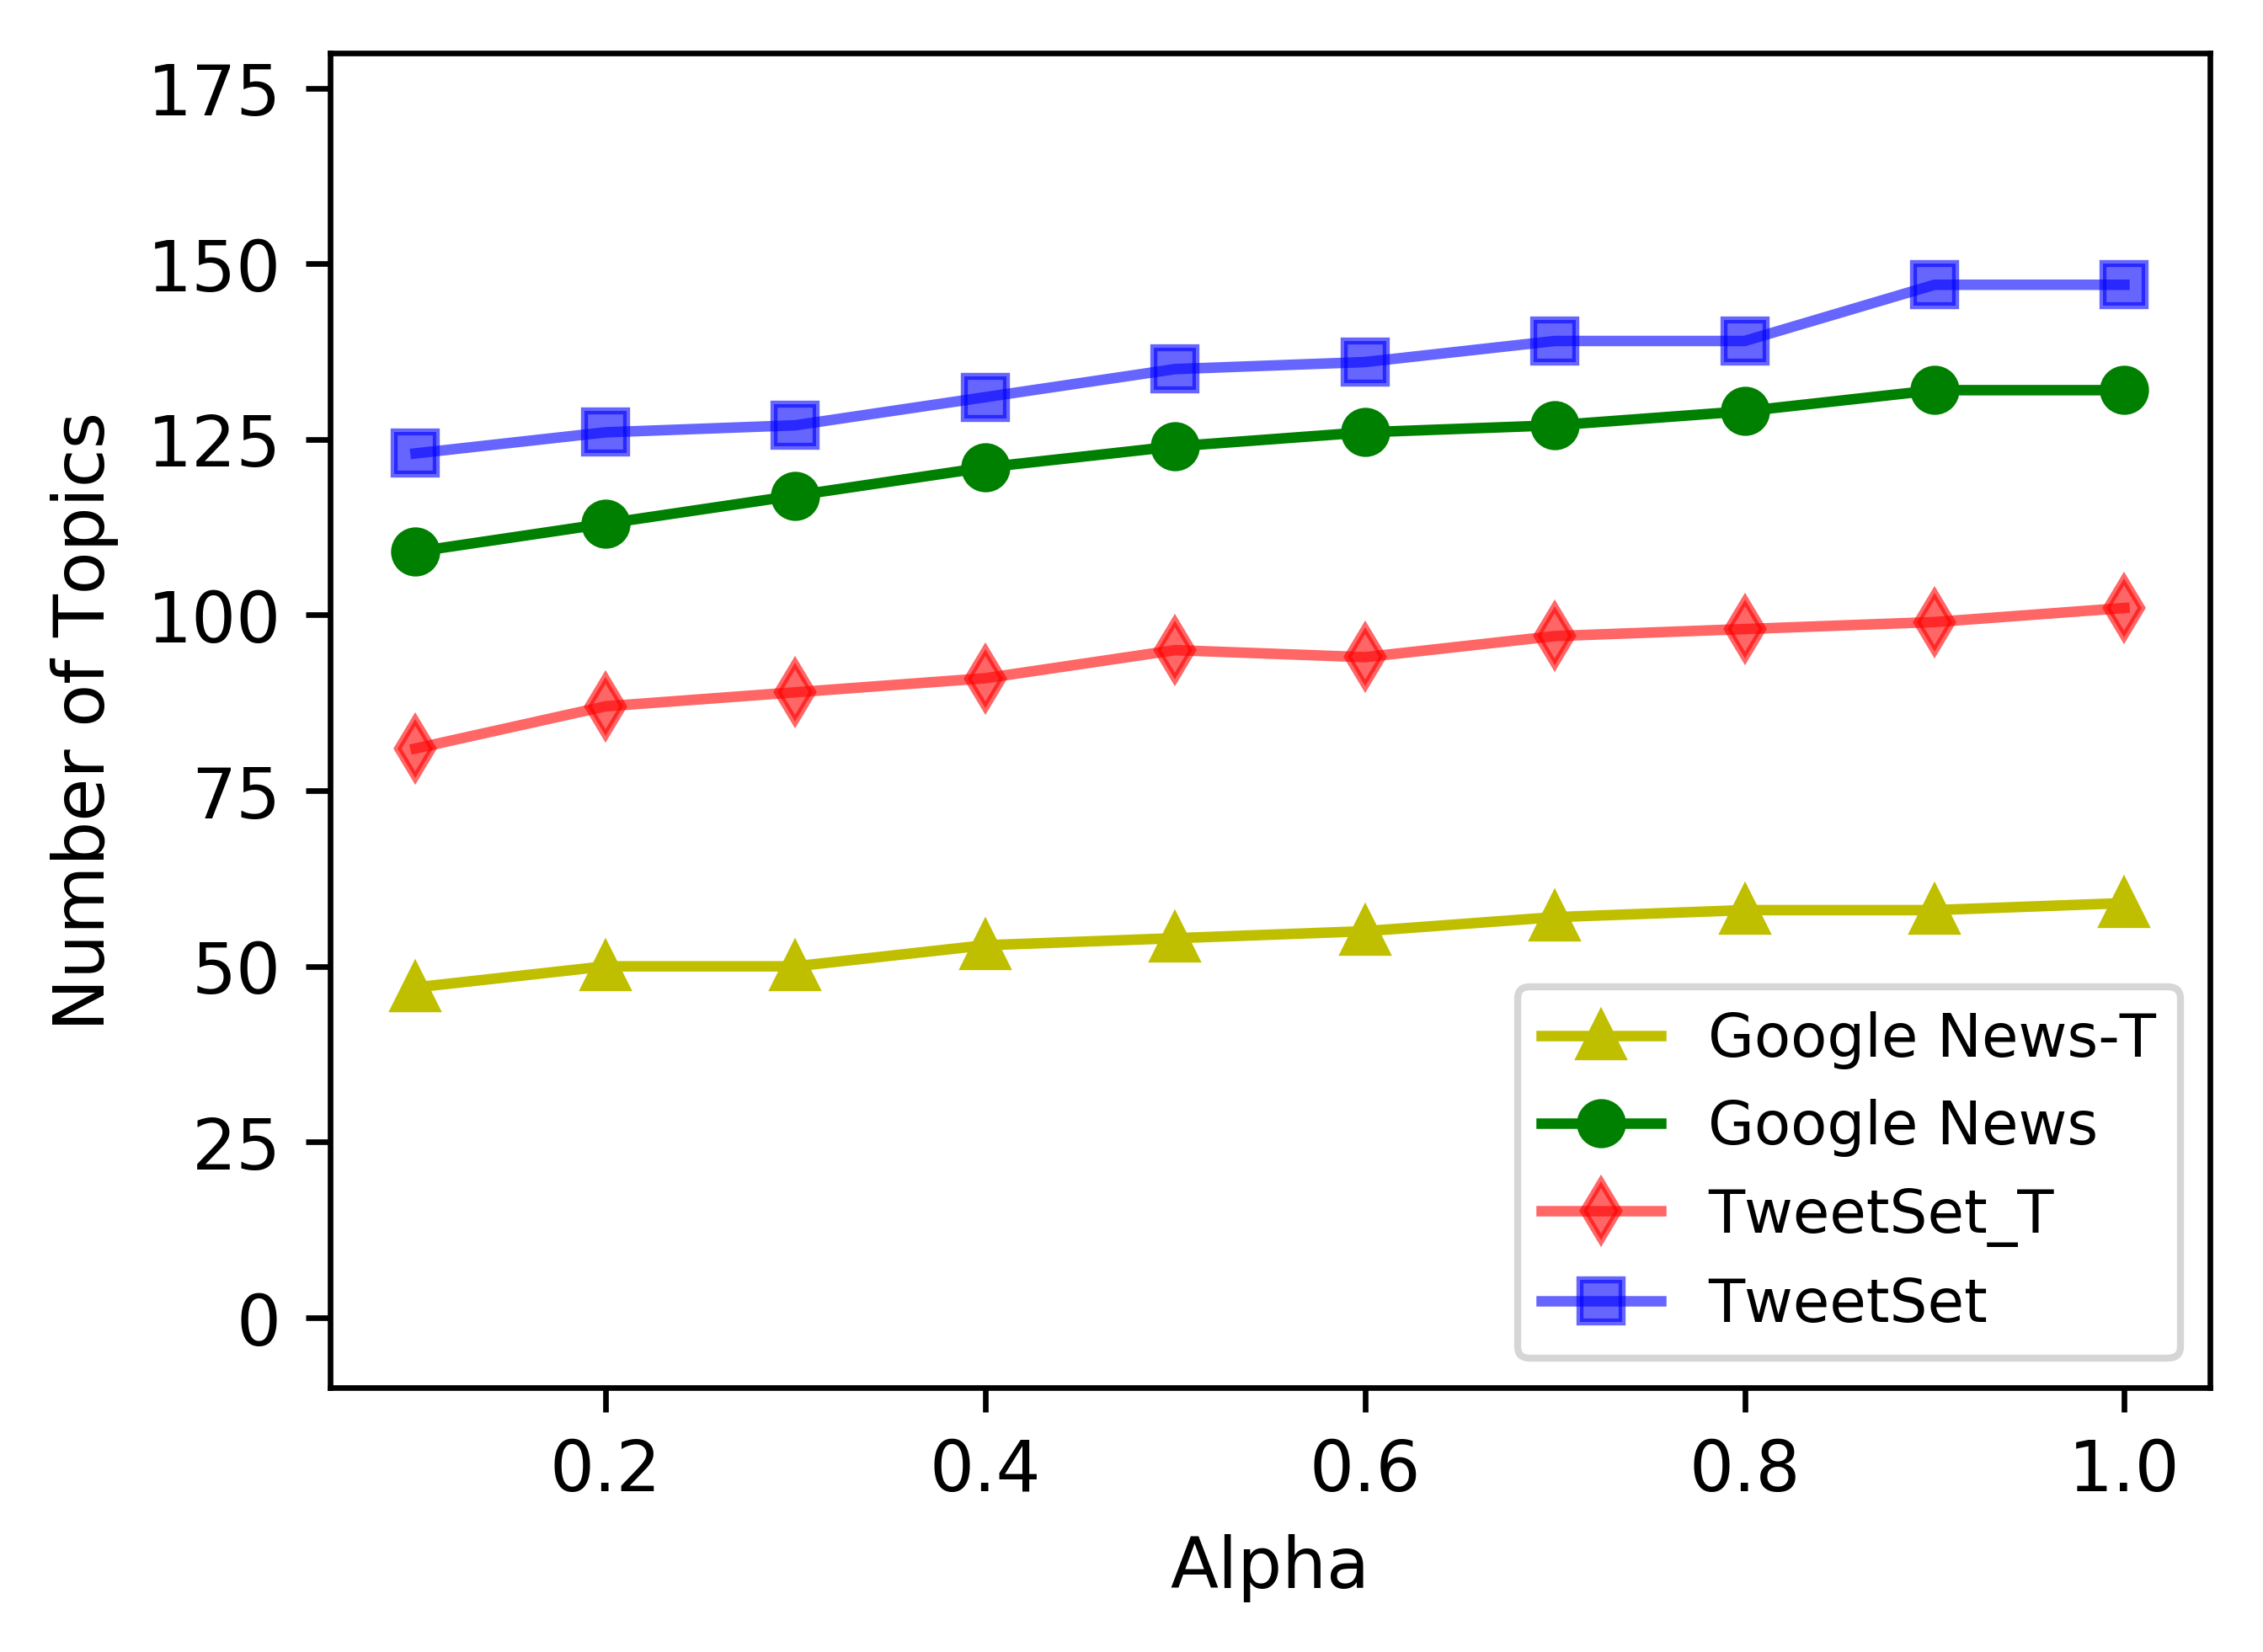

In [51]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
 
#设置x,y轴的数值（y=sinx）
#x = np.linspace(0, 10, 1000)
#y = np.sin(x)

x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

news_T = [47, 50, 50, 53, 54, 55, 57, 58, 58, 59]
f = plt.figure(figsize=(4.8,3.5),dpi = 600)
#plt.plot(x, news_T, 'g', lw=1)
plt.plot( x , news_T, c= 'y',marker="^", alpha=1,label="Google News-T") 

news = [109, 113, 117, 121, 124, 126, 127, 129, 132, 132]
#plt.plot(x, news, 'r', lw=1)
plt.plot( x,news, c= 'g',marker="o", alpha=1,label="Google News") 

tweets_T = [81, 87, 89, 91, 95, 94, 97, 98, 99, 101]
#plt.plot(x, tweets_T, 'r', lw=1)
plt.plot( x,tweets_T, c= 'r',marker="d", alpha=0.6,label="TweetSet_T") 

tweets = [123, 126, 127, 131, 135, 136, 139, 139, 147, 147]
#plt.plot(x, tweets, 'b', lw=1)
plt.plot( x,tweets, c= 'b',marker="s", alpha=0.6,label="TweetSet") 

plt.xlabel("Alpha")
plt.ylabel("Number of Topics")
 
#图表的标题
#plt.title("Performance")
 
#Y轴的范围
plt.ylim(-10,180)
 
#显示图示
plt.legend( prop={'size': 8.5})
 
#显示图
plt.show()
f.savefig("./ijcai/TopicsandAlpha-FP.pdf", bbox_inches='tight')


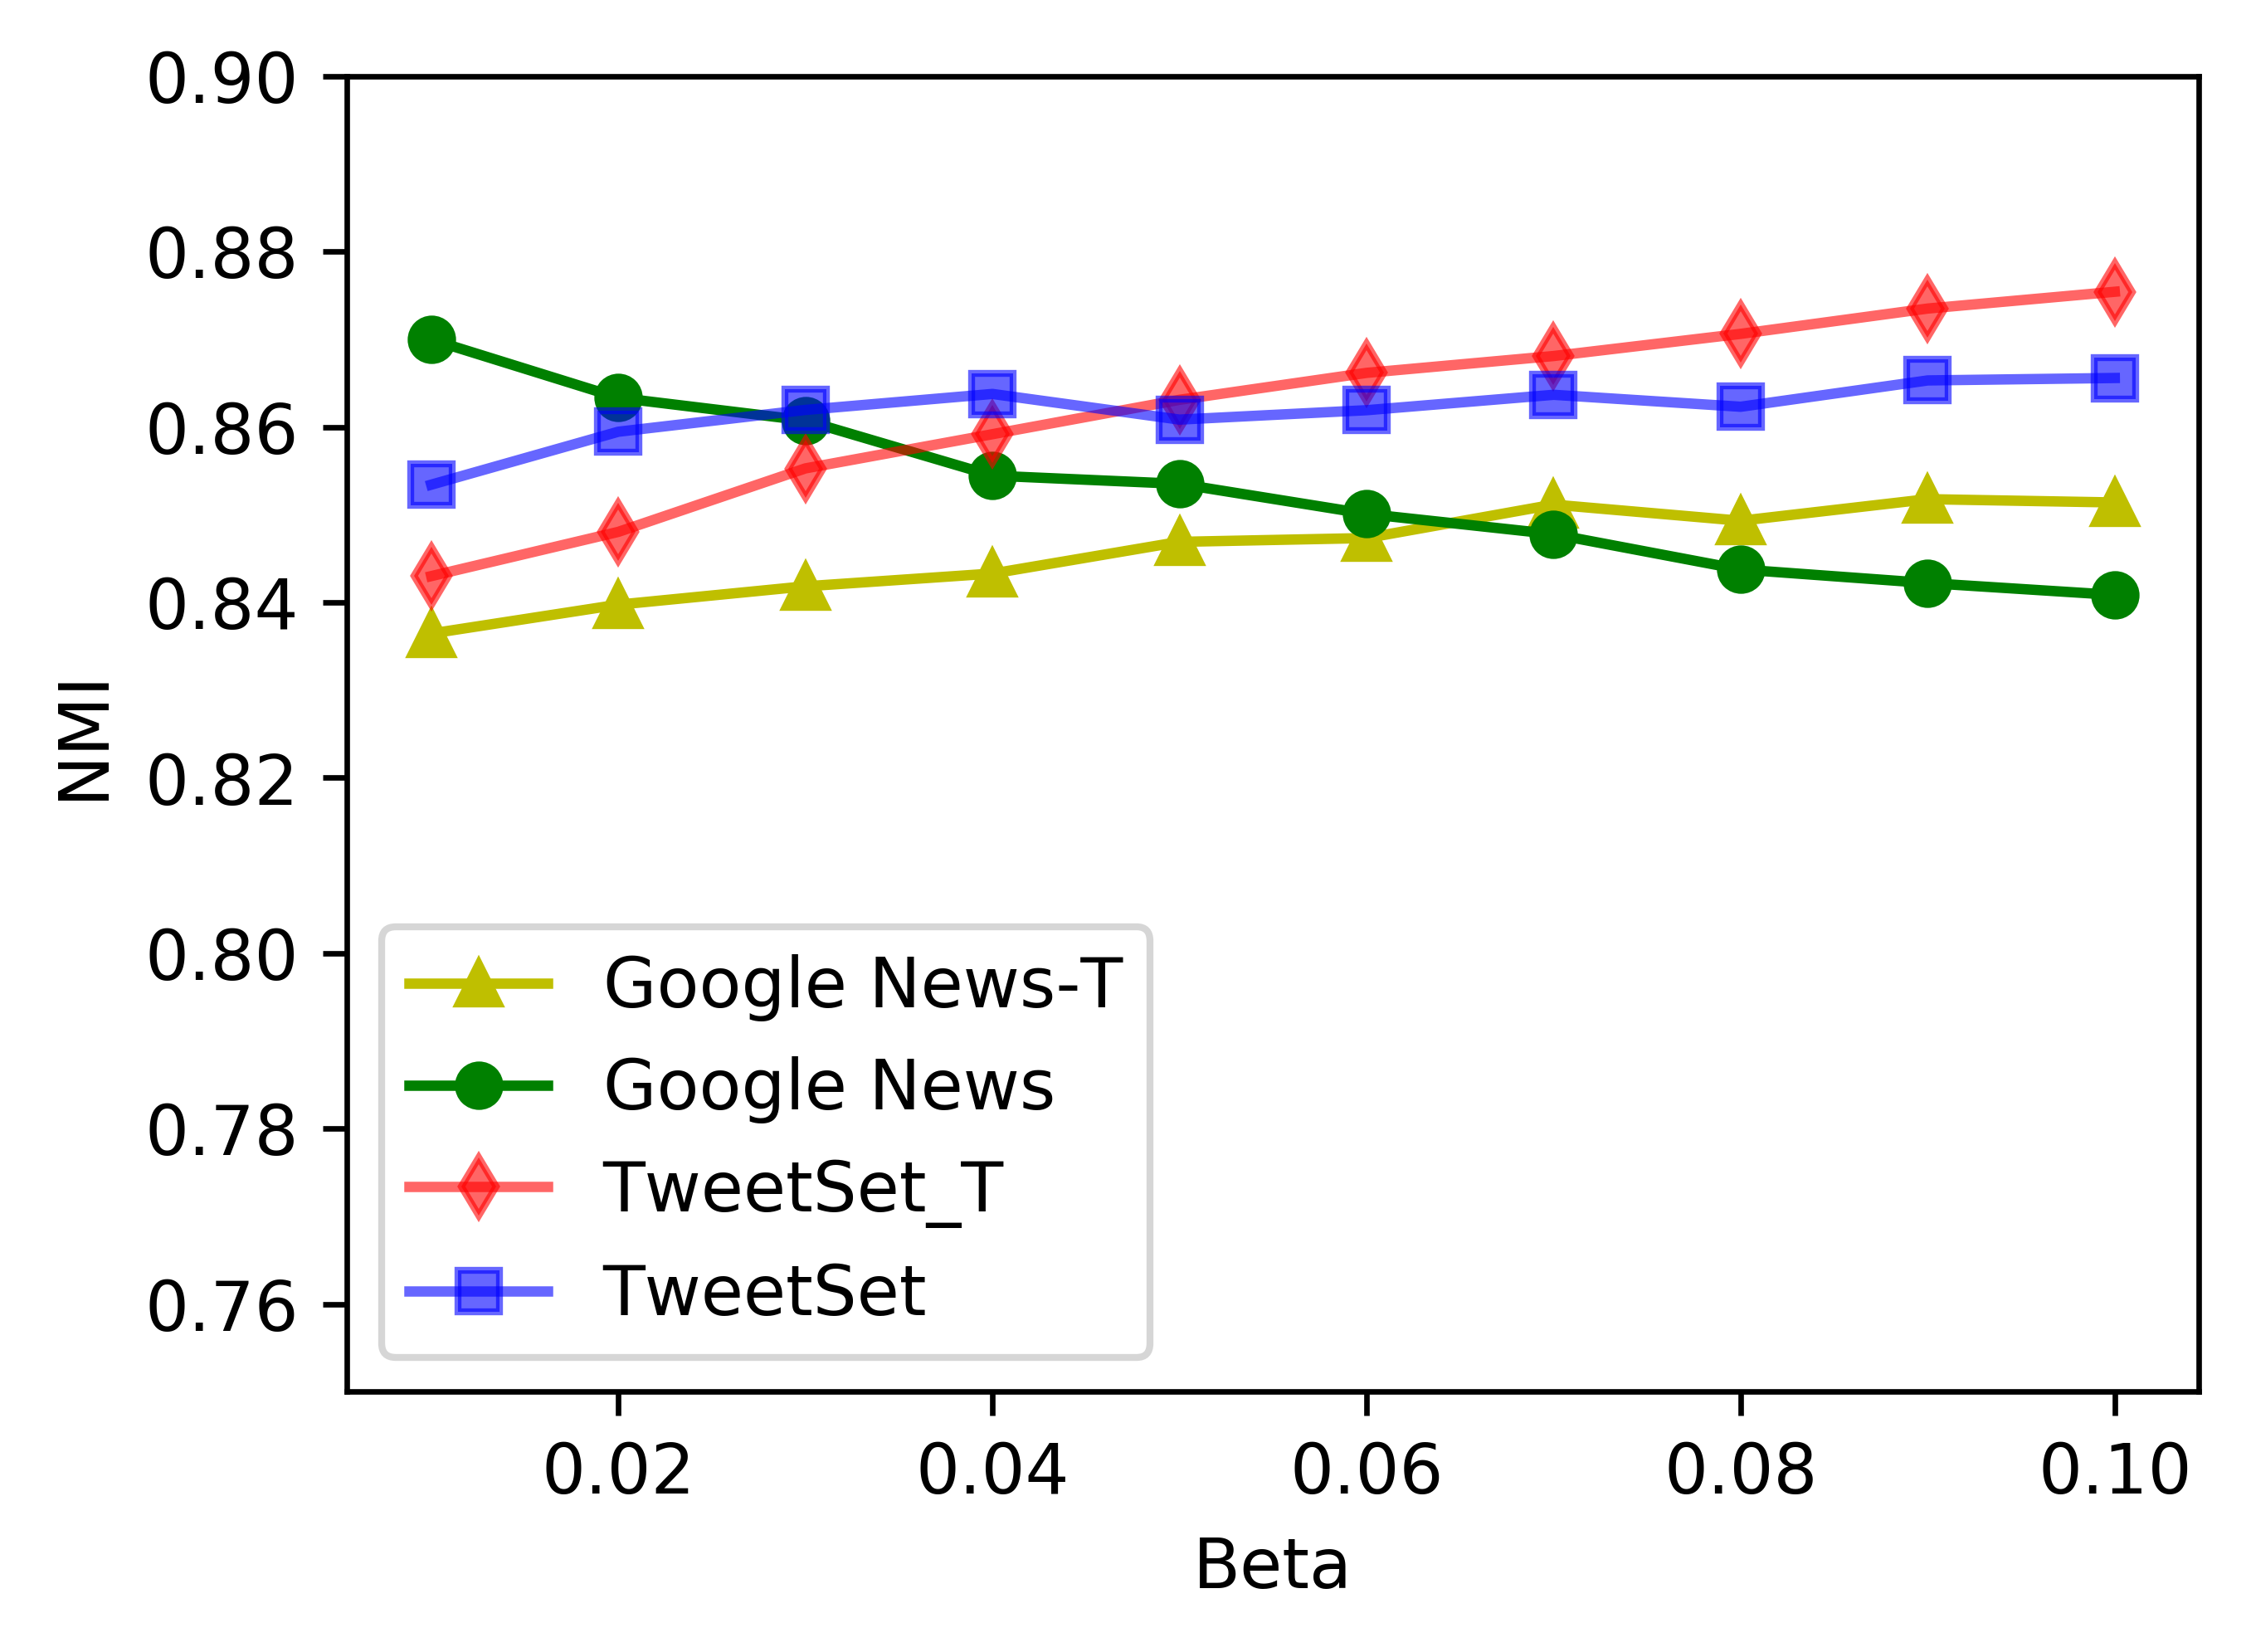

In [59]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
 
#设置x,y轴的数值（y=sinx）
#x = np.linspace(0, 10, 1000)
#y = np.sin(x)

x = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

news_T = [0.8364539795308584, 0.8397434895647793, 0.8418349824460967, 0.8432921714324443, 0.8469041570893295, 0.8473385408635419, 0.8511540188706488, 0.8493120497817379, 0.8517732136663384, 0.8513964204530664]
f = plt.figure(figsize=(4.8,3.5),dpi = 600)
#plt.plot(x, news_T, 'g', lw=1)
plt.plot( x , news_T, c= 'y',marker="^", alpha=1,label="Google News-T") 

news = [.8699699951011529, 0.8633358151661771, 0.8607446624208933, 0.8544558542816069, 0.8535184567321144, 0.8500950223881202, 0.8477850421373615, 0.8437579850550729, 0.8422063069183763, 0.8408524438454522]
#plt.plot(x, news, 'r', lw=1)
plt.plot( x,news, c= 'g',marker="o", alpha=1,label="Google News") 

tweets_T = [0.8429985321578273, 0.8480429291231262, 0.8552798643487032, 0.8591793208737459, 0.8631011686285752, 0.8661730896257254, 0.8680943424541648, 0.8706209524749318, 0.8735070843895678, 0.8754215408848192]
#plt.plot(x, tweets_T, 'r', lw=1)
plt.plot( x,tweets_T, c= 'r',marker="d", alpha=0.6,label="TweetSet_T") 

tweets = [0.8534245935667799, 0.8594619669831385, 0.8619466322640438, 0.8637711855665748, 0.8608449214227926, 0.8619158360522604, 0.8636735364012487, 0.8623104611400528, 0.8653112415575797, 0.8655887018435414]
#plt.plot(x, tweets, 'b', lw=1)
plt.plot( x,tweets, c= 'b',marker="s", alpha=0.6,label="TweetSet") 

plt.xlabel("Beta")
plt.ylabel("NMI")
 
#图表的标题
#plt.title("Performance")
 
#Y轴的范围
plt.ylim(0.75,0.9)
 
#显示图示
plt.legend(loc = "lower left")
#plt.legend(loc = "lower left", prop={'size': 8.5})
 
#显示图
plt.show()
f.savefig("./ijcai/NMIandBeta-FP.pdf", bbox_inches='tight')


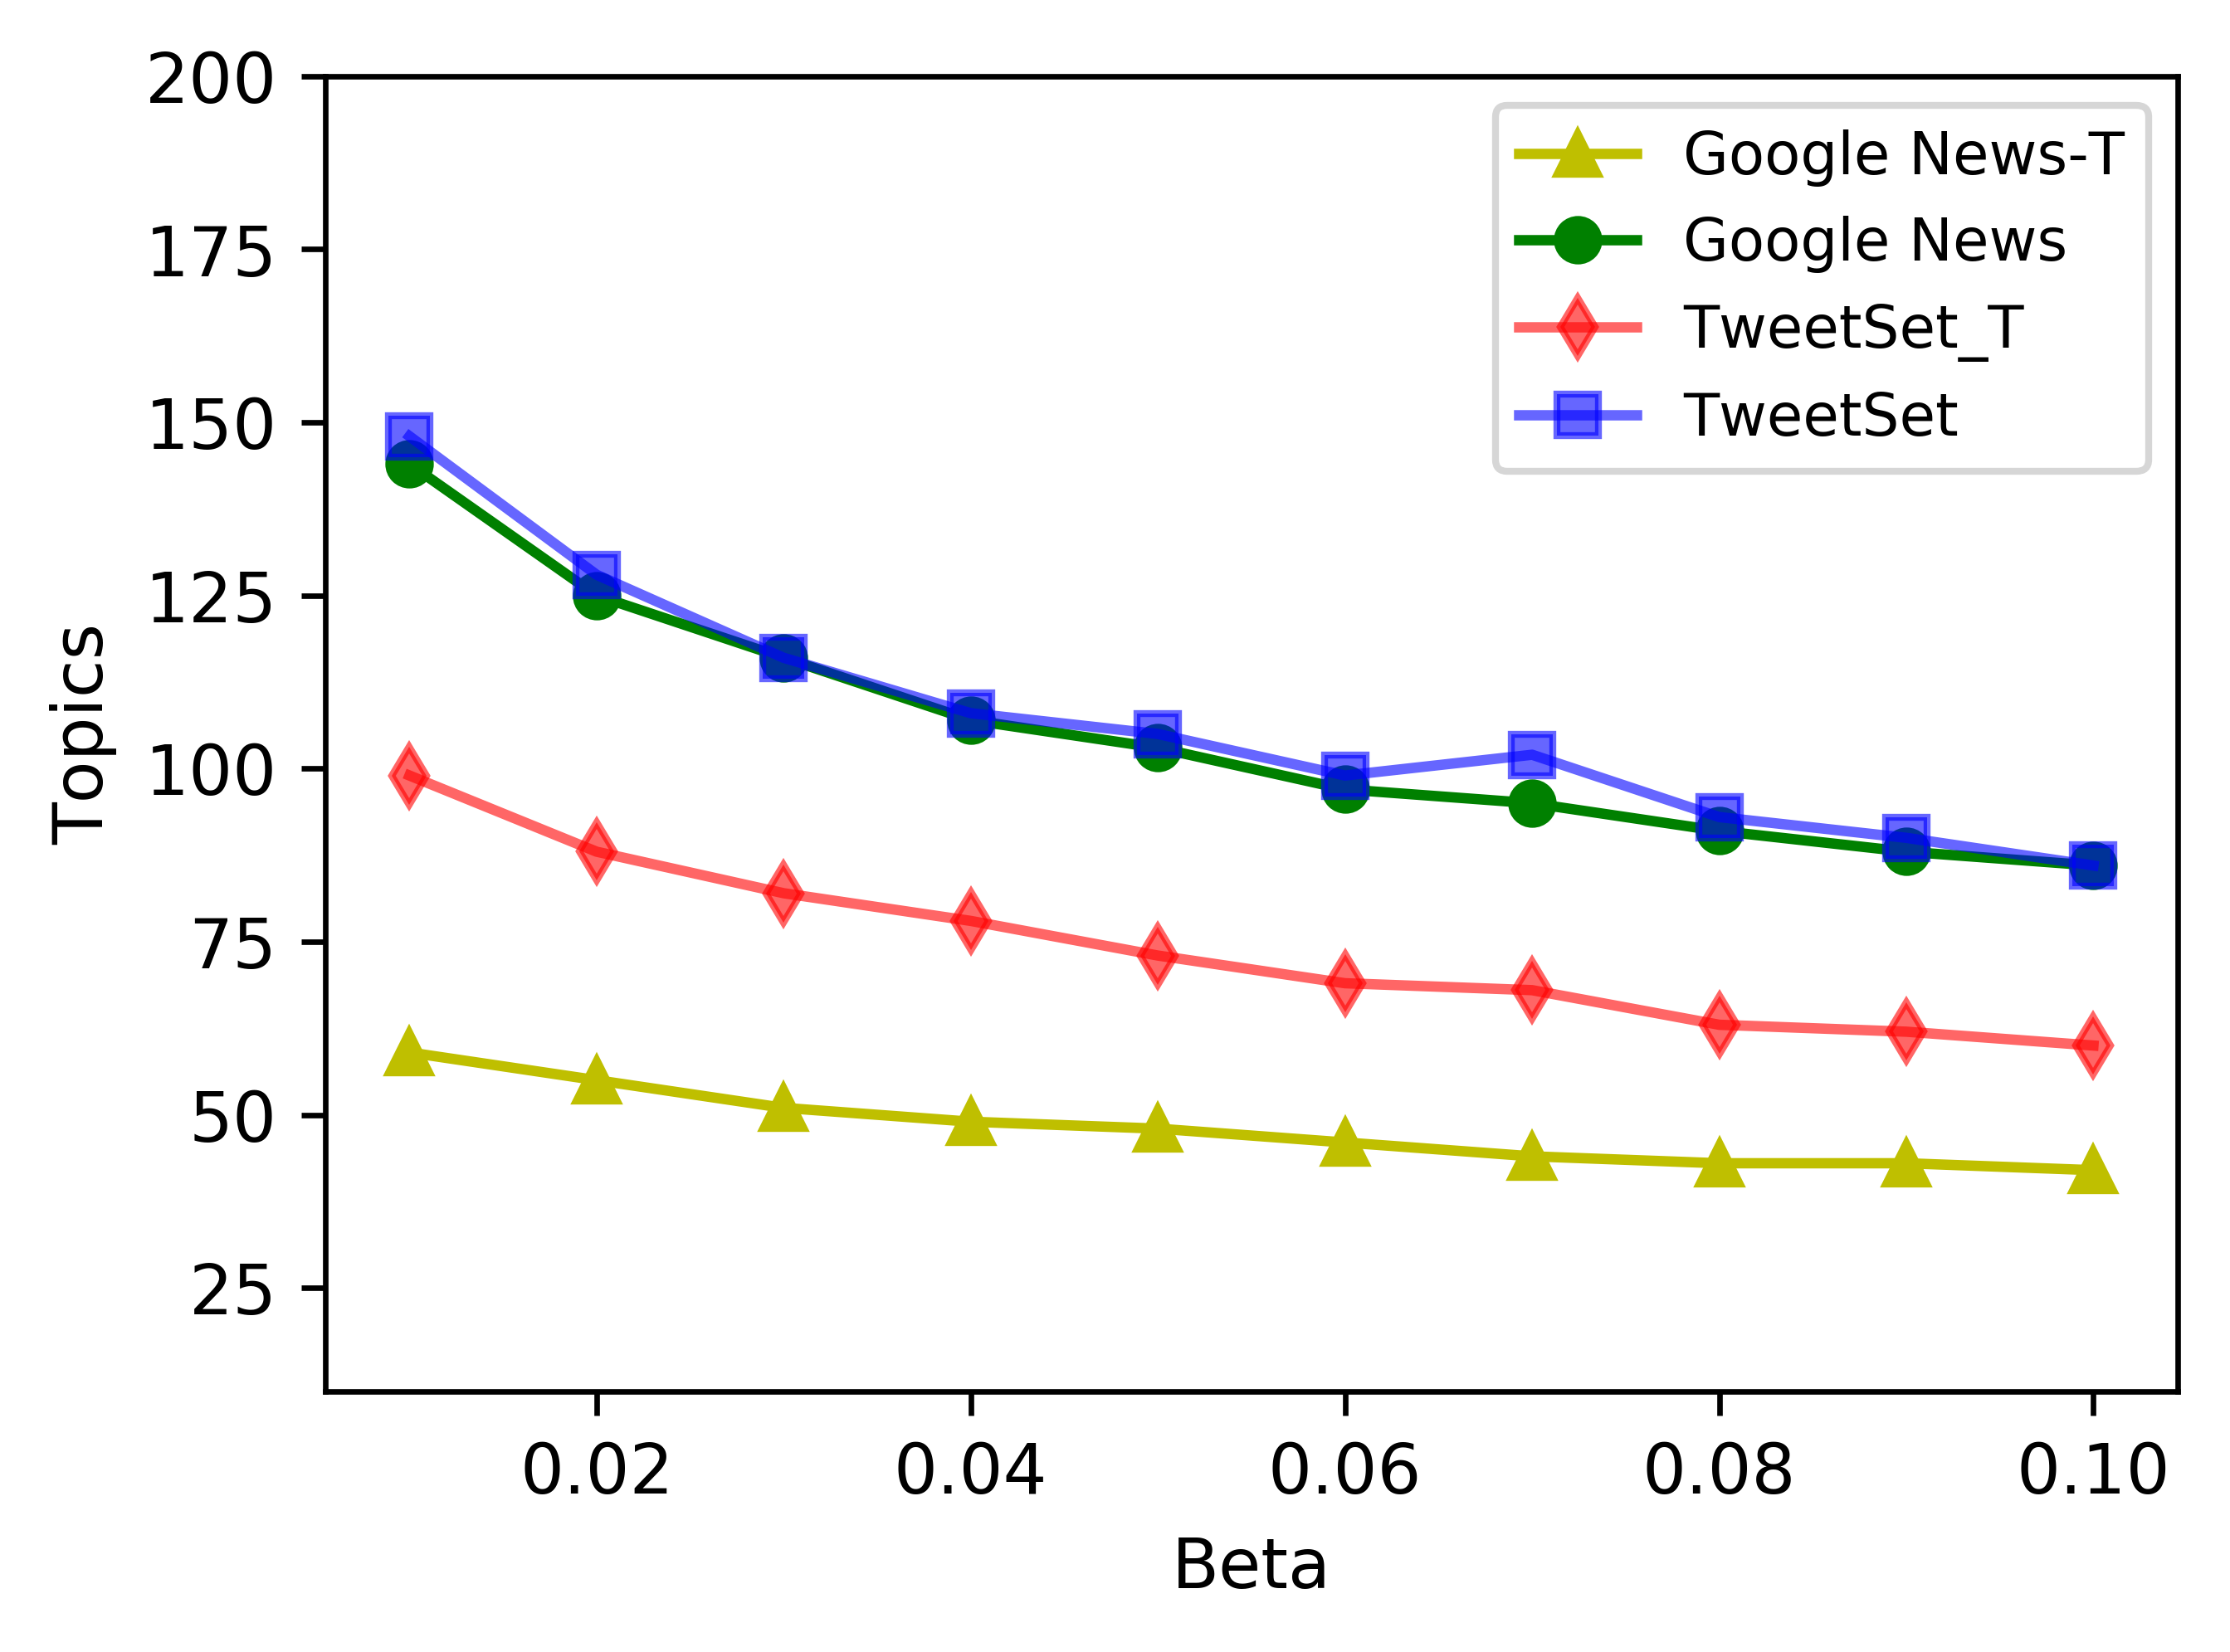

In [55]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
 
#设置x,y轴的数值（y=sinx）
#x = np.linspace(0, 10, 1000)
#y = np.sin(x)

x = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

news_T = [59, 55, 51, 49, 48, 46, 44, 43, 43, 42]
f = plt.figure(figsize=(4.8,3.5),dpi = 600)
#plt.plot(x, news_T, 'g', lw=1)
plt.plot( x , news_T, c= 'y',marker="^", alpha=1,label="Google News-T") 

news = [144, 125, 116, 107, 103, 97, 95, 91, 88, 86]
#plt.plot(x, news, 'r', lw=1)
plt.plot( x,news, c= 'g',marker="o", alpha=1,label="Google News") 

tweets_T = [99, 88, 82, 78, 73, 69, 68, 63, 62, 60]
#plt.plot(x, tweets_T, 'r', lw=1)
plt.plot( x,tweets_T, c= 'r',marker="d", alpha=0.6,label="TweetSet_T") 

tweets = [148, 128, 116, 108, 105, 99, 102, 93, 90, 86]
#plt.plot(x, tweets, 'b', lw=1)
plt.plot( x,tweets, c= 'b',marker="s", alpha=0.6,label="TweetSet") 

plt.xlabel("Beta")
plt.ylabel("Topics")
 
#图表的标题
#plt.title("Performance")
 
#Y轴的范围
plt.ylim(10,200)
 
#显示图示
plt.legend(prop={'size': 8.5})
#显示图
plt.show()
f.savefig("./ijcai/TopicsandBeta-FP.pdf", bbox_inches='tight')



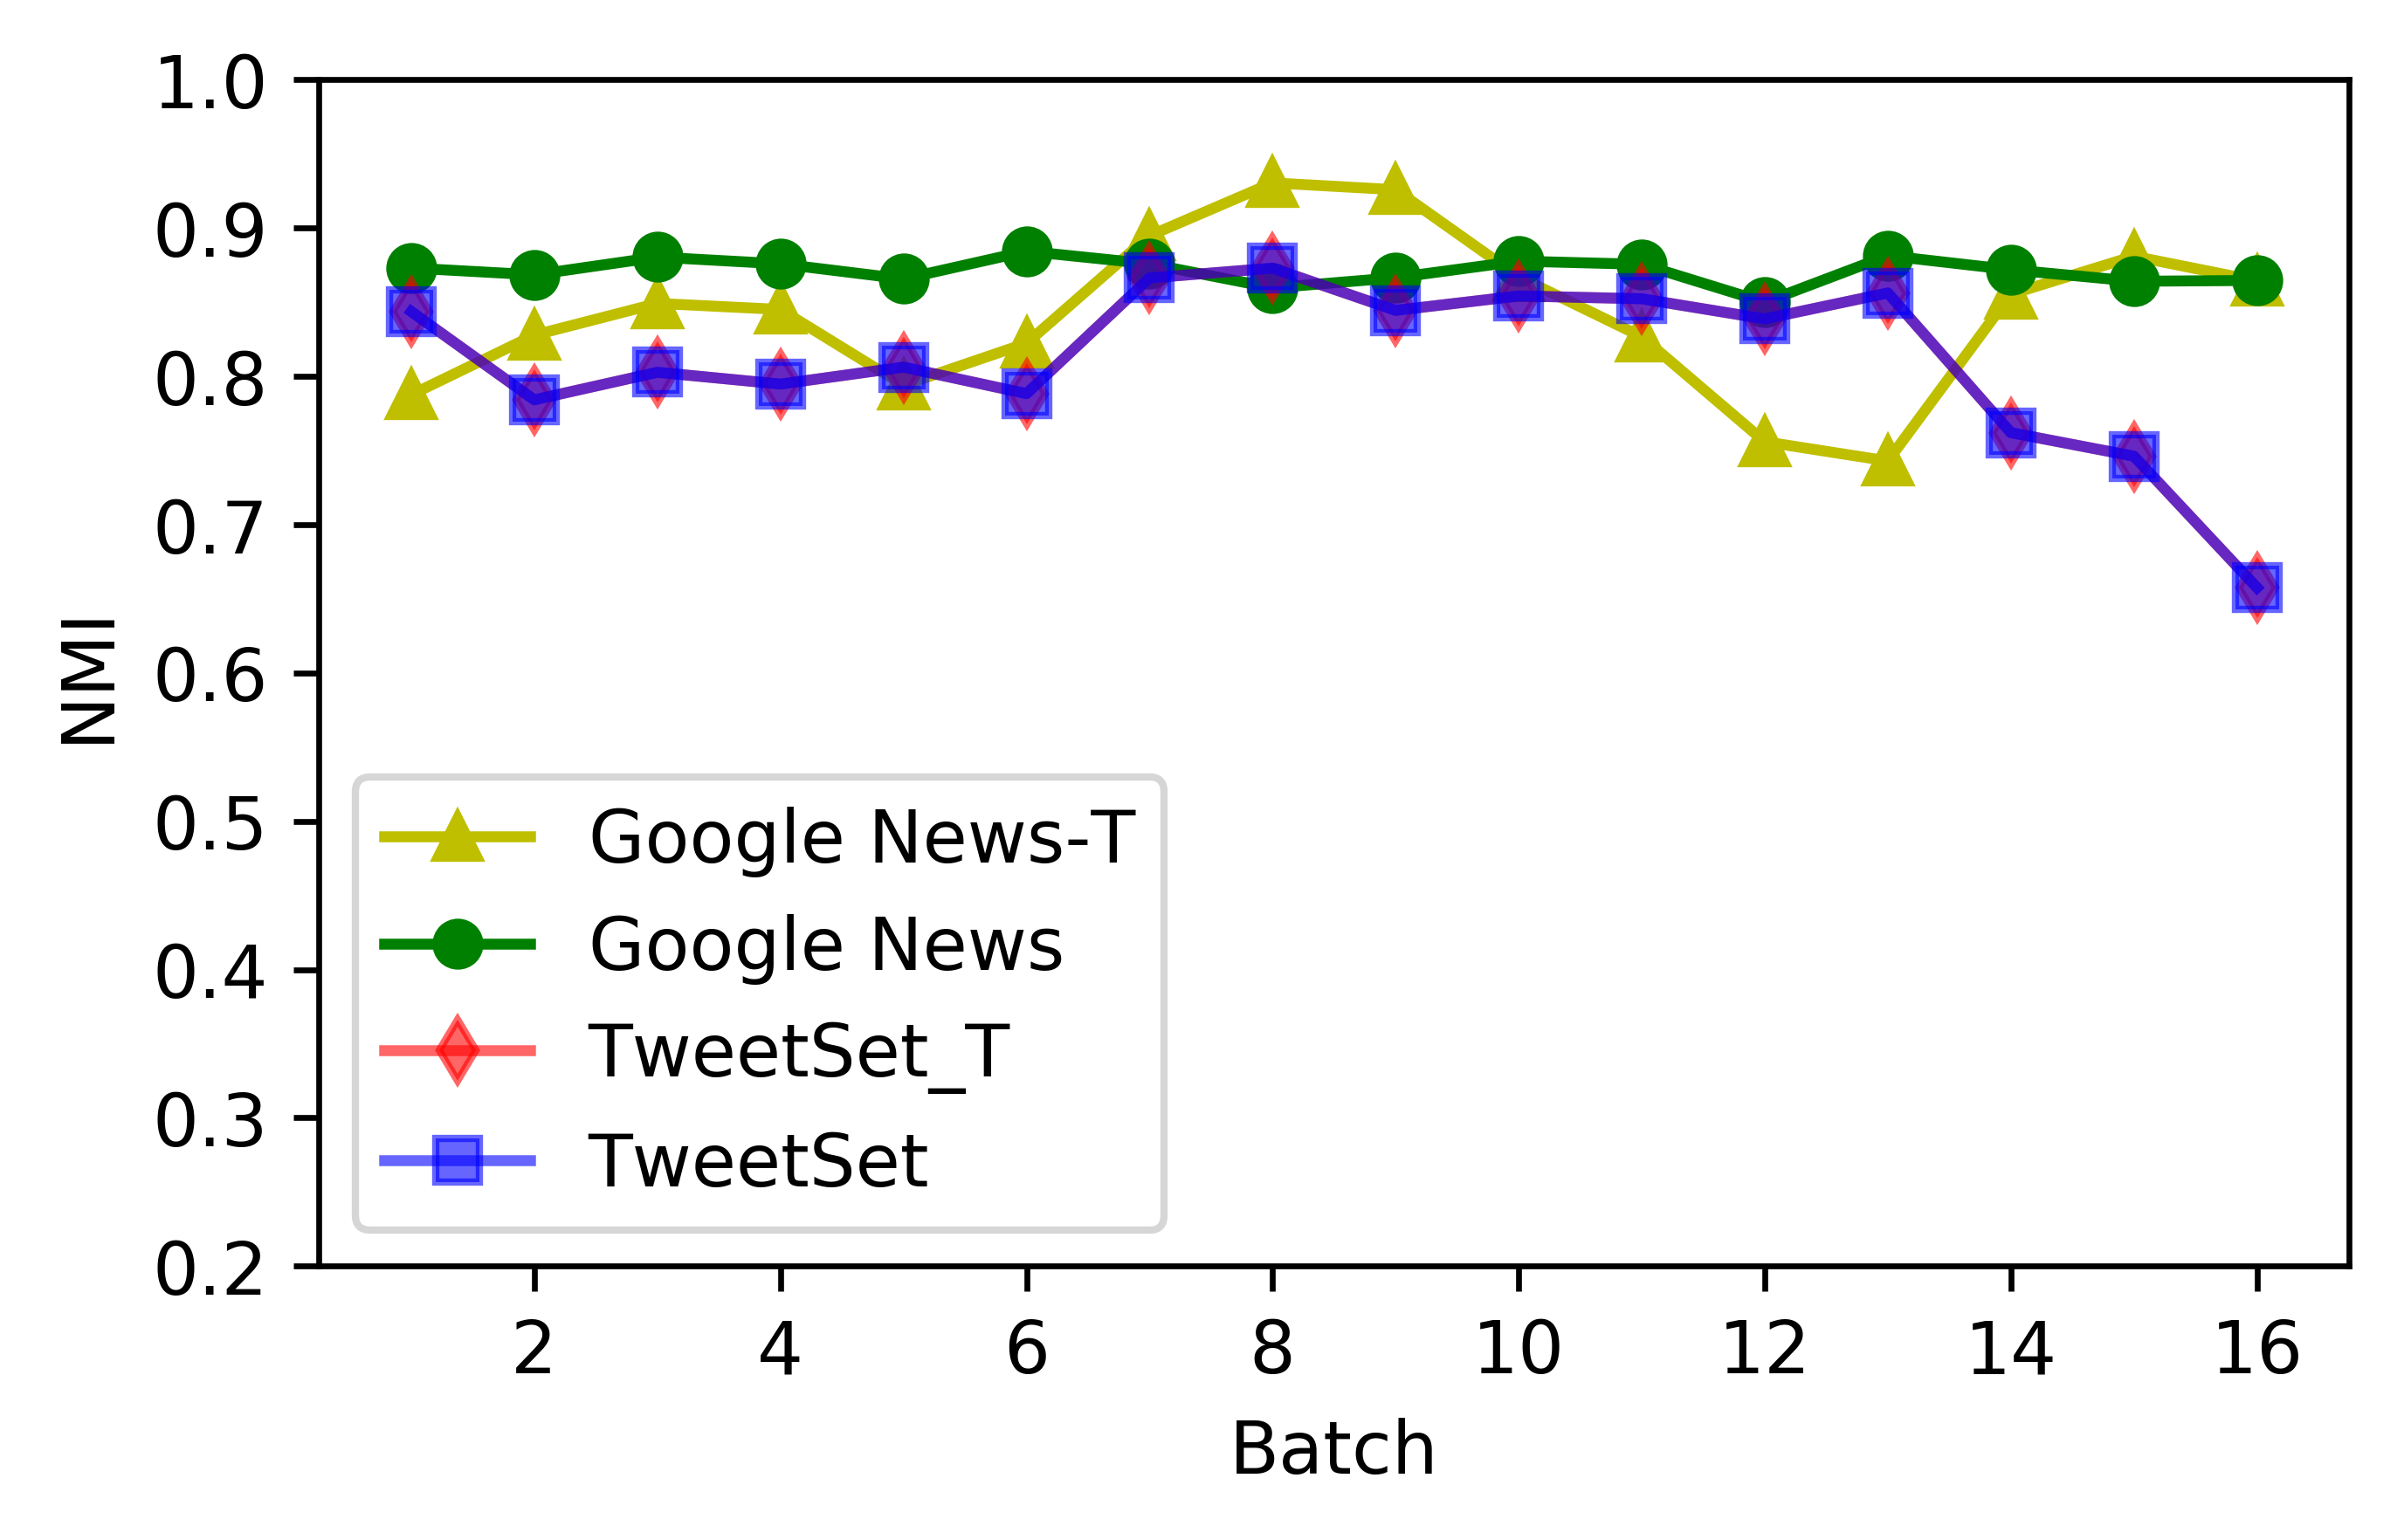

In [73]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
 
#设置x,y轴的数值（y=sinx）
#x = np.linspace(0, 10, 1000)
#y = np.sin(x)

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

news_T = [0.7876026632745371, 0.827800211461006, 0.849184378431291, 0.8451070637231864, 0.7940263049058457, 0.8223017427037164, 0.894809842293581, 0.9304533179753635, 0.9258334908567185, 0.8671163169954504, 0.8267156927049686, 0.7559150585932306, 0.7429415055990873, 0.8554031568460954, 0.8809880682292323, 0.864387575010974]
f = plt.figure(figsize=(5,3),dpi = 600)
#plt.plot(x, news_T, 'g', lw=1)
plt.plot( x , news_T, c= 'y',marker="^", alpha=1,label="Google News-T") 

news = [0.8730133849433831, 0.8684743694996326, 0.8804032259273199, 0.8758633536436381, 0.8656884137743128, 0.8843568887366188, 0.8758842887943914, 0.8596648235205762, 0.8664921845605948, 0.8776708653357372, 0.875552963171944, 0.8499807697201824, 0.8813713693485388, 0.871907891615146, 0.8641084076115443, 0.8646719585908315]
#plt.plot(x, news, 'r', lw=1)
plt.plot( x,news, c= 'g',marker="o", alpha=1,label="Google News") 

tweets_T = [0.8436721086734994, 0.7841632366879743, 0.8027431901180576, 0.7947706756792043, 0.8062062767162166, 0.7883398951881432, 0.8663603624840678, 0.8729681949479431, 0.8444874958953082, 0.8541998111803198, 0.8523165335565736, 0.8387467209607611, 0.8562169313133525, 0.7620460574534248, 0.746156216536674, 0.6575539178674068]
#plt.plot(x, tweets_T, 'r', lw=1)
plt.plot( x,tweets_T, c= 'r',marker="d", alpha=0.6,label="TweetSet_T") 

tweets = [0.8436721086734994, 0.7841632366879743, 0.8027431901180576, 0.7947706756792043, 0.8062062767162166, 0.7883398951881432, 0.8663603624840678, 0.8729681949479431, 0.8444874958953082, 0.8541998111803198, 0.8523165335565736, 0.8387467209607611, 0.8562169313133525, 0.7620460574534248, 0.746156216536674, 0.6575539178674068]
#plt.plot(x, tweets, 'b', lw=1)
plt.plot( x,tweets, c= 'b',marker="s", alpha=0.6,label="TweetSet") 

plt.xlabel("Batch")
plt.ylabel("NMI")
 
#图表的标题
#plt.title("Performance")
 
#Y轴的范围
plt.ylim(0.2, 1.0)
 
#显示图示
plt.legend()
 
#显示图
plt.show()

f.savefig("NMIandInterationNews.pdf", bbox_inches='tight')


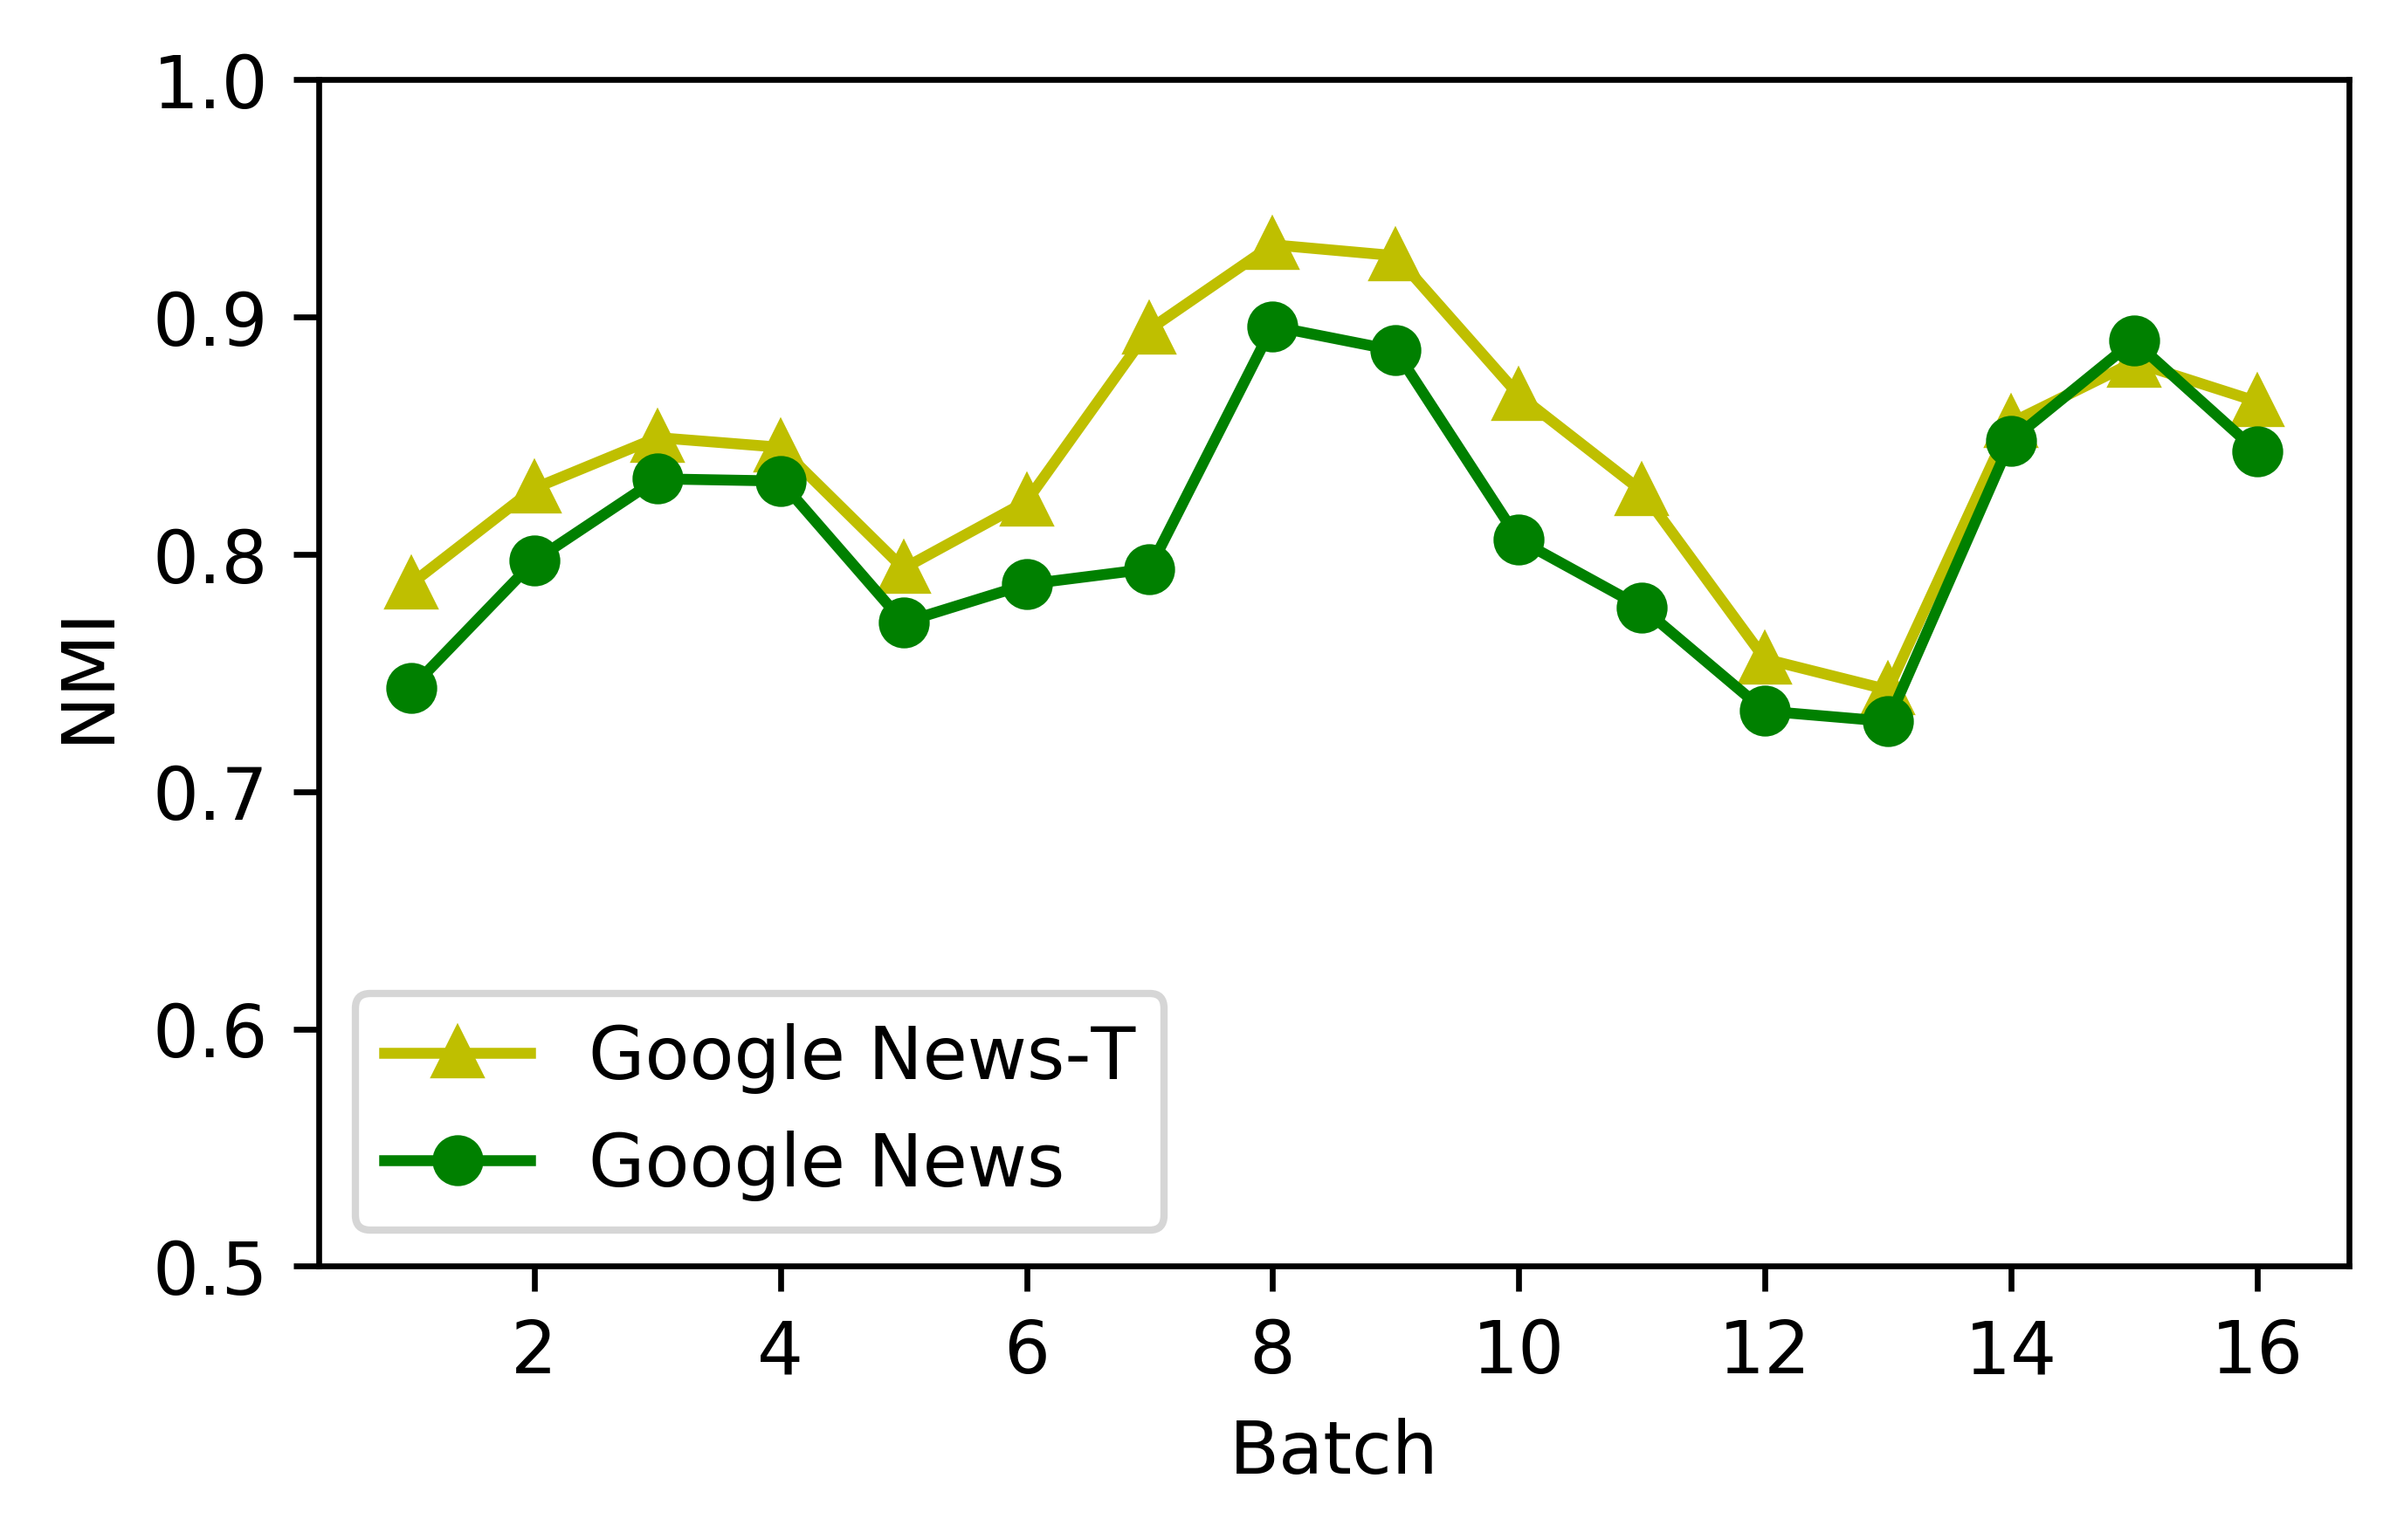

In [74]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
 
#设置x,y轴的数值（y=sinx）
#x = np.linspace(0, 10, 1000)
#y = np.sin(x)

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

news_T = [0.7876026632745371, 0.827800211461006, 0.849184378431291, 0.8451070637231864, 0.7940263049058457, 0.8223017427037164, 0.894809842293581, 0.9304533179753635, 0.9258334908567185, 0.8671163169954504, 0.8267156927049686, 0.7559150585932306, 0.7429415055990873, 0.8554031568460954, 0.8809880682292323, 0.864387575010974]
f = plt.figure(figsize=(5,3),dpi = 600)
#plt.plot(x, news_T, 'g', lw=1)
plt.plot( x , news_T, c= 'y',marker="^", alpha=1,label="Google News-T") 

news = [0.74358617620551, 0.7972567987965442, 0.8318064203875323, 0.8308878732798081, 0.7712990579197013, 0.7873606642011487, 0.7938912368104012, 0.8961130458375514, 0.8858844953668192, 0.8061639875625186, 0.7776982238779898, 0.7339626090234643, 0.7295843644905816, 0.8478840832767133, 0.8900298608325932, 0.8433912851221609]
#plt.plot(x, news, 'r', lw=1)
plt.plot( x,news, c= 'g',marker="o", alpha=1,label="Google News") 


plt.xlabel("Batch")
plt.ylabel("NMI")
 
#图表的标题
#plt.title("Performance")
 
#Y轴的范围
plt.ylim(0.5, 1.0)
 
#显示图示
plt.legend()
 
#显示图
plt.show()

f.savefig("NMIandInterationNews.pdf", bbox_inches='tight')


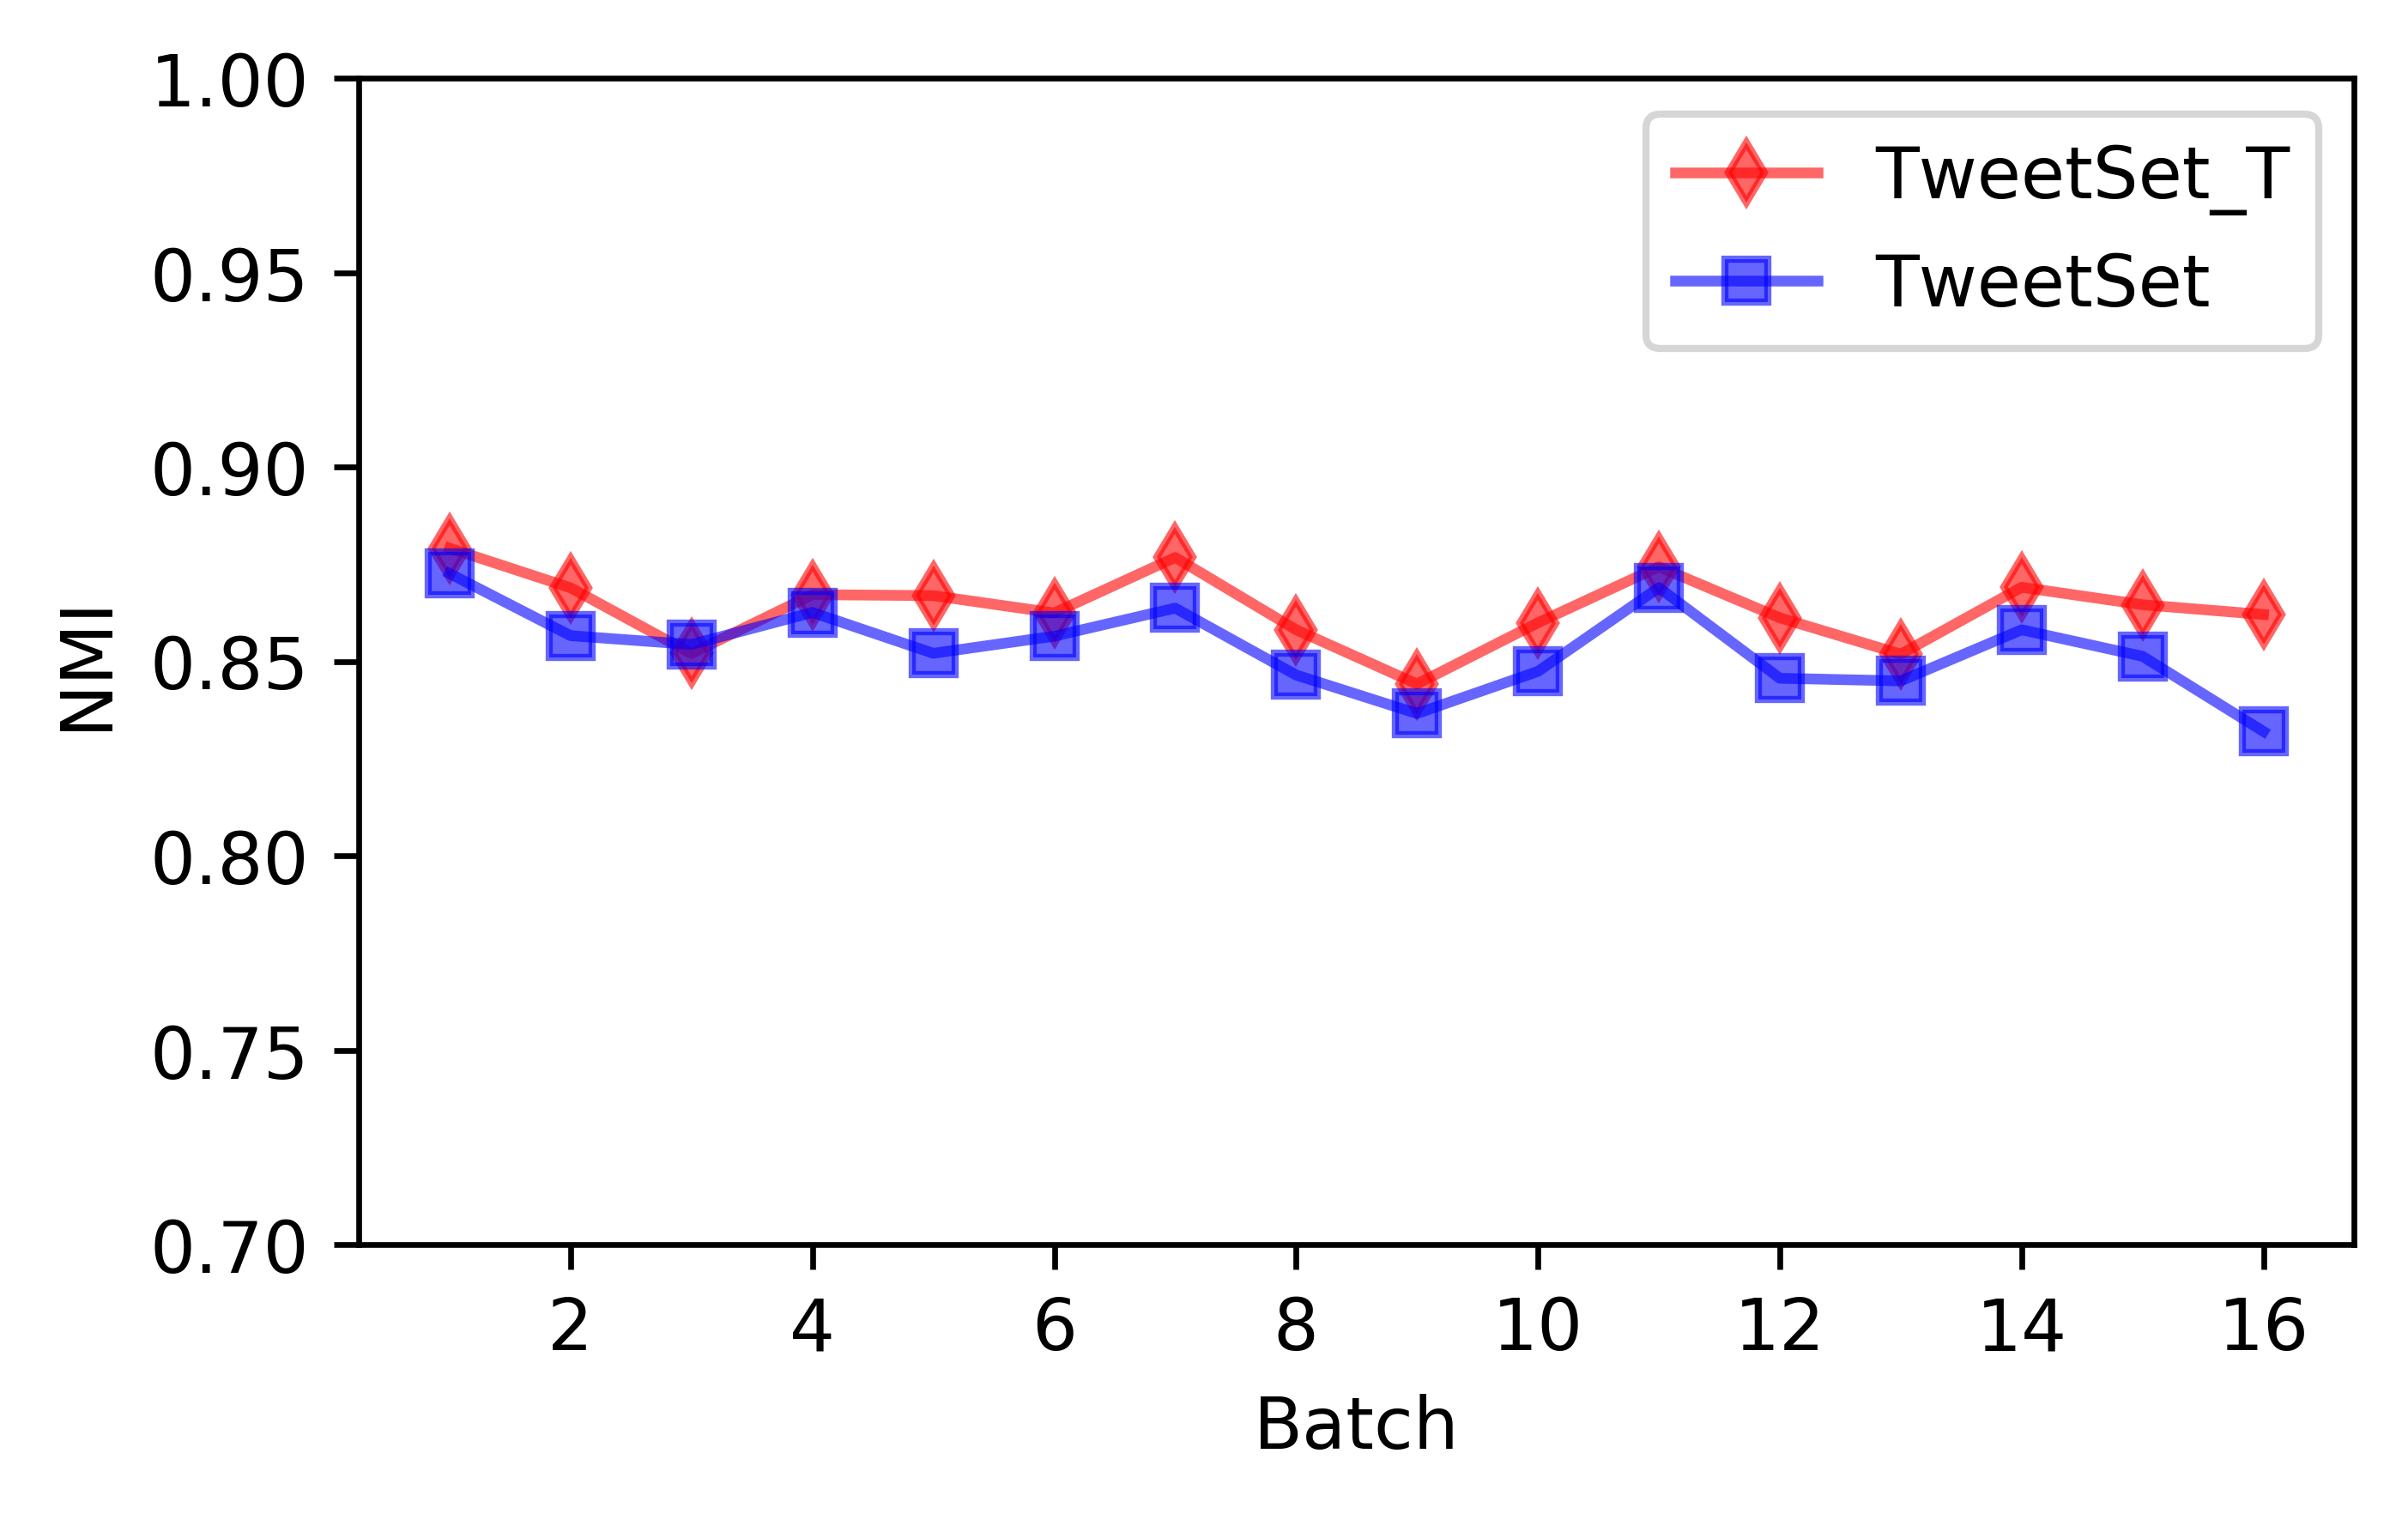

In [76]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
 
#设置x,y轴的数值（y=sinx）
#x = np.linspace(0, 10, 1000)
#y = np.sin(x)

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

f = plt.figure(figsize=(5,3),dpi = 600)


tweets_T = [0.8791632071654407, 0.8689766289541706, 0.8520647369847433, 0.8672141455434031, 0.8669673186133002, 0.8625201831434595, 0.8767862446229376, 0.8581853527328299, 0.8442325374746548, 0.8599915553662428, 0.8743825671633735, 0.8612640060536784, 0.8519235493142886, 0.8691149373848646, 0.86462425414101, 0.8621060128272594]
#plt.plot(x, tweets_T, 'r', lw=1)
plt.plot( x,tweets_T, c= 'r',marker="d", alpha=0.6,label="TweetSet_T") 

tweets = [0.8726365823761731, 0.8566633373187825, 0.8544016477026825, 0.8626448195293978, 0.8521307742254463, 0.8565295925956222, 0.8637605848627977, 0.8465501019420673, 0.8366437785511709, 0.847481365560549, 0.8690264753022972, 0.8457094143046929, 0.8450308638594545, 0.8581839723962552, 0.8513570035863224, 0.8320245596072464]
#plt.plot(x, tweets, 'b', lw=1)
plt.plot( x,tweets, c= 'b',marker="s", alpha=0.6,label="TweetSet") 


plt.xlabel("Batch")
plt.ylabel("NMI")
 
#图表的标题
#plt.title("Performance")
 
#Y轴的范围
plt.ylim(0.7, 1.0)
 
#显示图示
plt.legend()
 
#显示图
plt.show()

f.savefig("NMIandInterationNews.pdf", bbox_inches='tight')


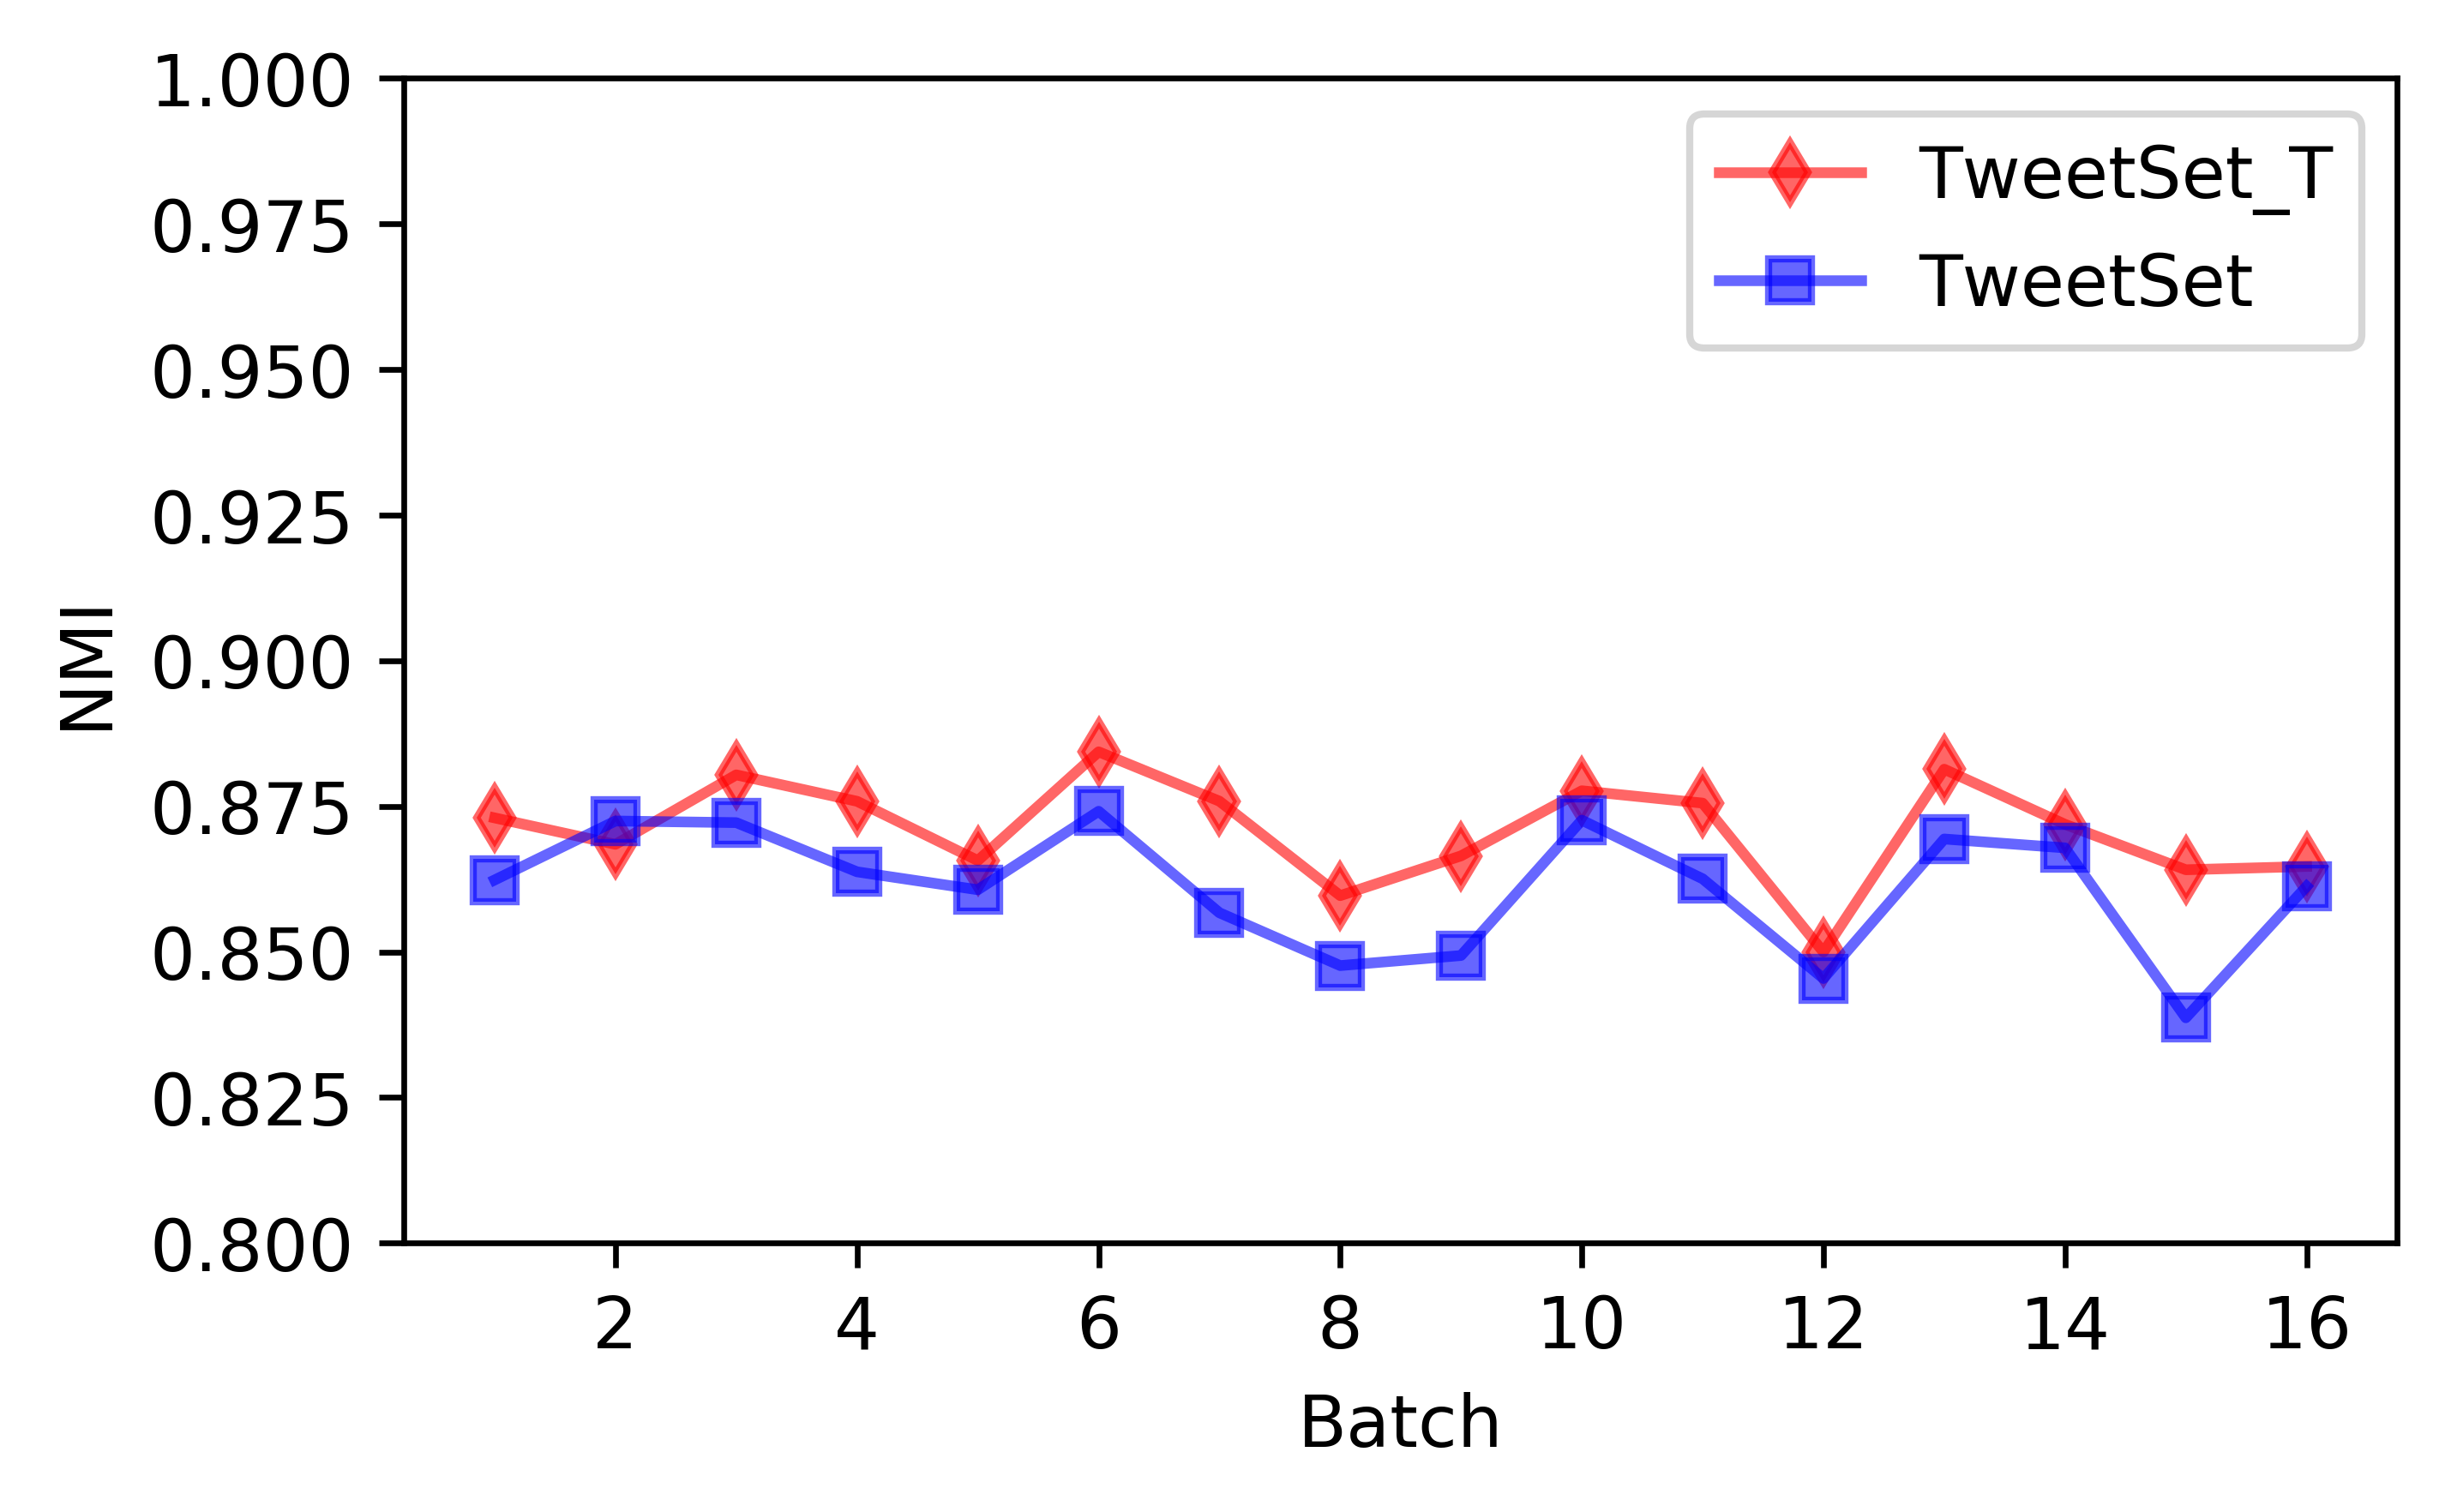

In [50]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
 
#设置x,y轴的数值（y=sinx）
#x = np.linspace(0, 10, 1000)
#y = np.sin(x)

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

f = plt.figure(figsize=(5,3),dpi = 600)


tweets_T = [0.8730133849433831, 0.8684743694996326, 0.8804032259273199, 0.8758633536436381, 0.8656884137743128, 0.8843568887366188, 0.8758842887943914, 0.8596648235205762, 0.8664921845605948, 0.8776708653357372, 0.875552963171944, 0.8499807697201824, 0.8813713693485388, 0.871907891615146, 0.8641084076115443, 0.8646719585908315]
#plt.plot(x, tweets_T, 'r', lw=1)
plt.plot( x,tweets_T, c= 'r',marker="d", alpha=0.6,label="TweetSet_T") 

tweets = [0.8623544625444902, 0.872478736350316, 0.8722014346848574, 0.8637554765023524, 0.8606767747903371, 0.8741487747226716, 0.8567226562760328, 0.8476540482444179, 0.8493836570931185, 0.8726219667064586, 0.8625555219293228, 0.8454375178218405, 0.8693897802361944, 0.8678660483784364, 0.8386902200312653, 0.8612593092468479]
#plt.plot(x, tweets, 'b', lw=1)
plt.plot( x,tweets, c= 'b',marker="s", alpha=0.6,label="TweetSet") 


plt.xlabel("Batch")
plt.ylabel("NMI")
 
#图表的标题
#plt.title("Performance")
 
#Y轴的范围
plt.ylim(0.8, 1.0)
 
#显示图示
plt.legend()
 
#显示图
plt.show()

f.savefig("NMIandInterationNews.pdf", bbox_inches='tight')


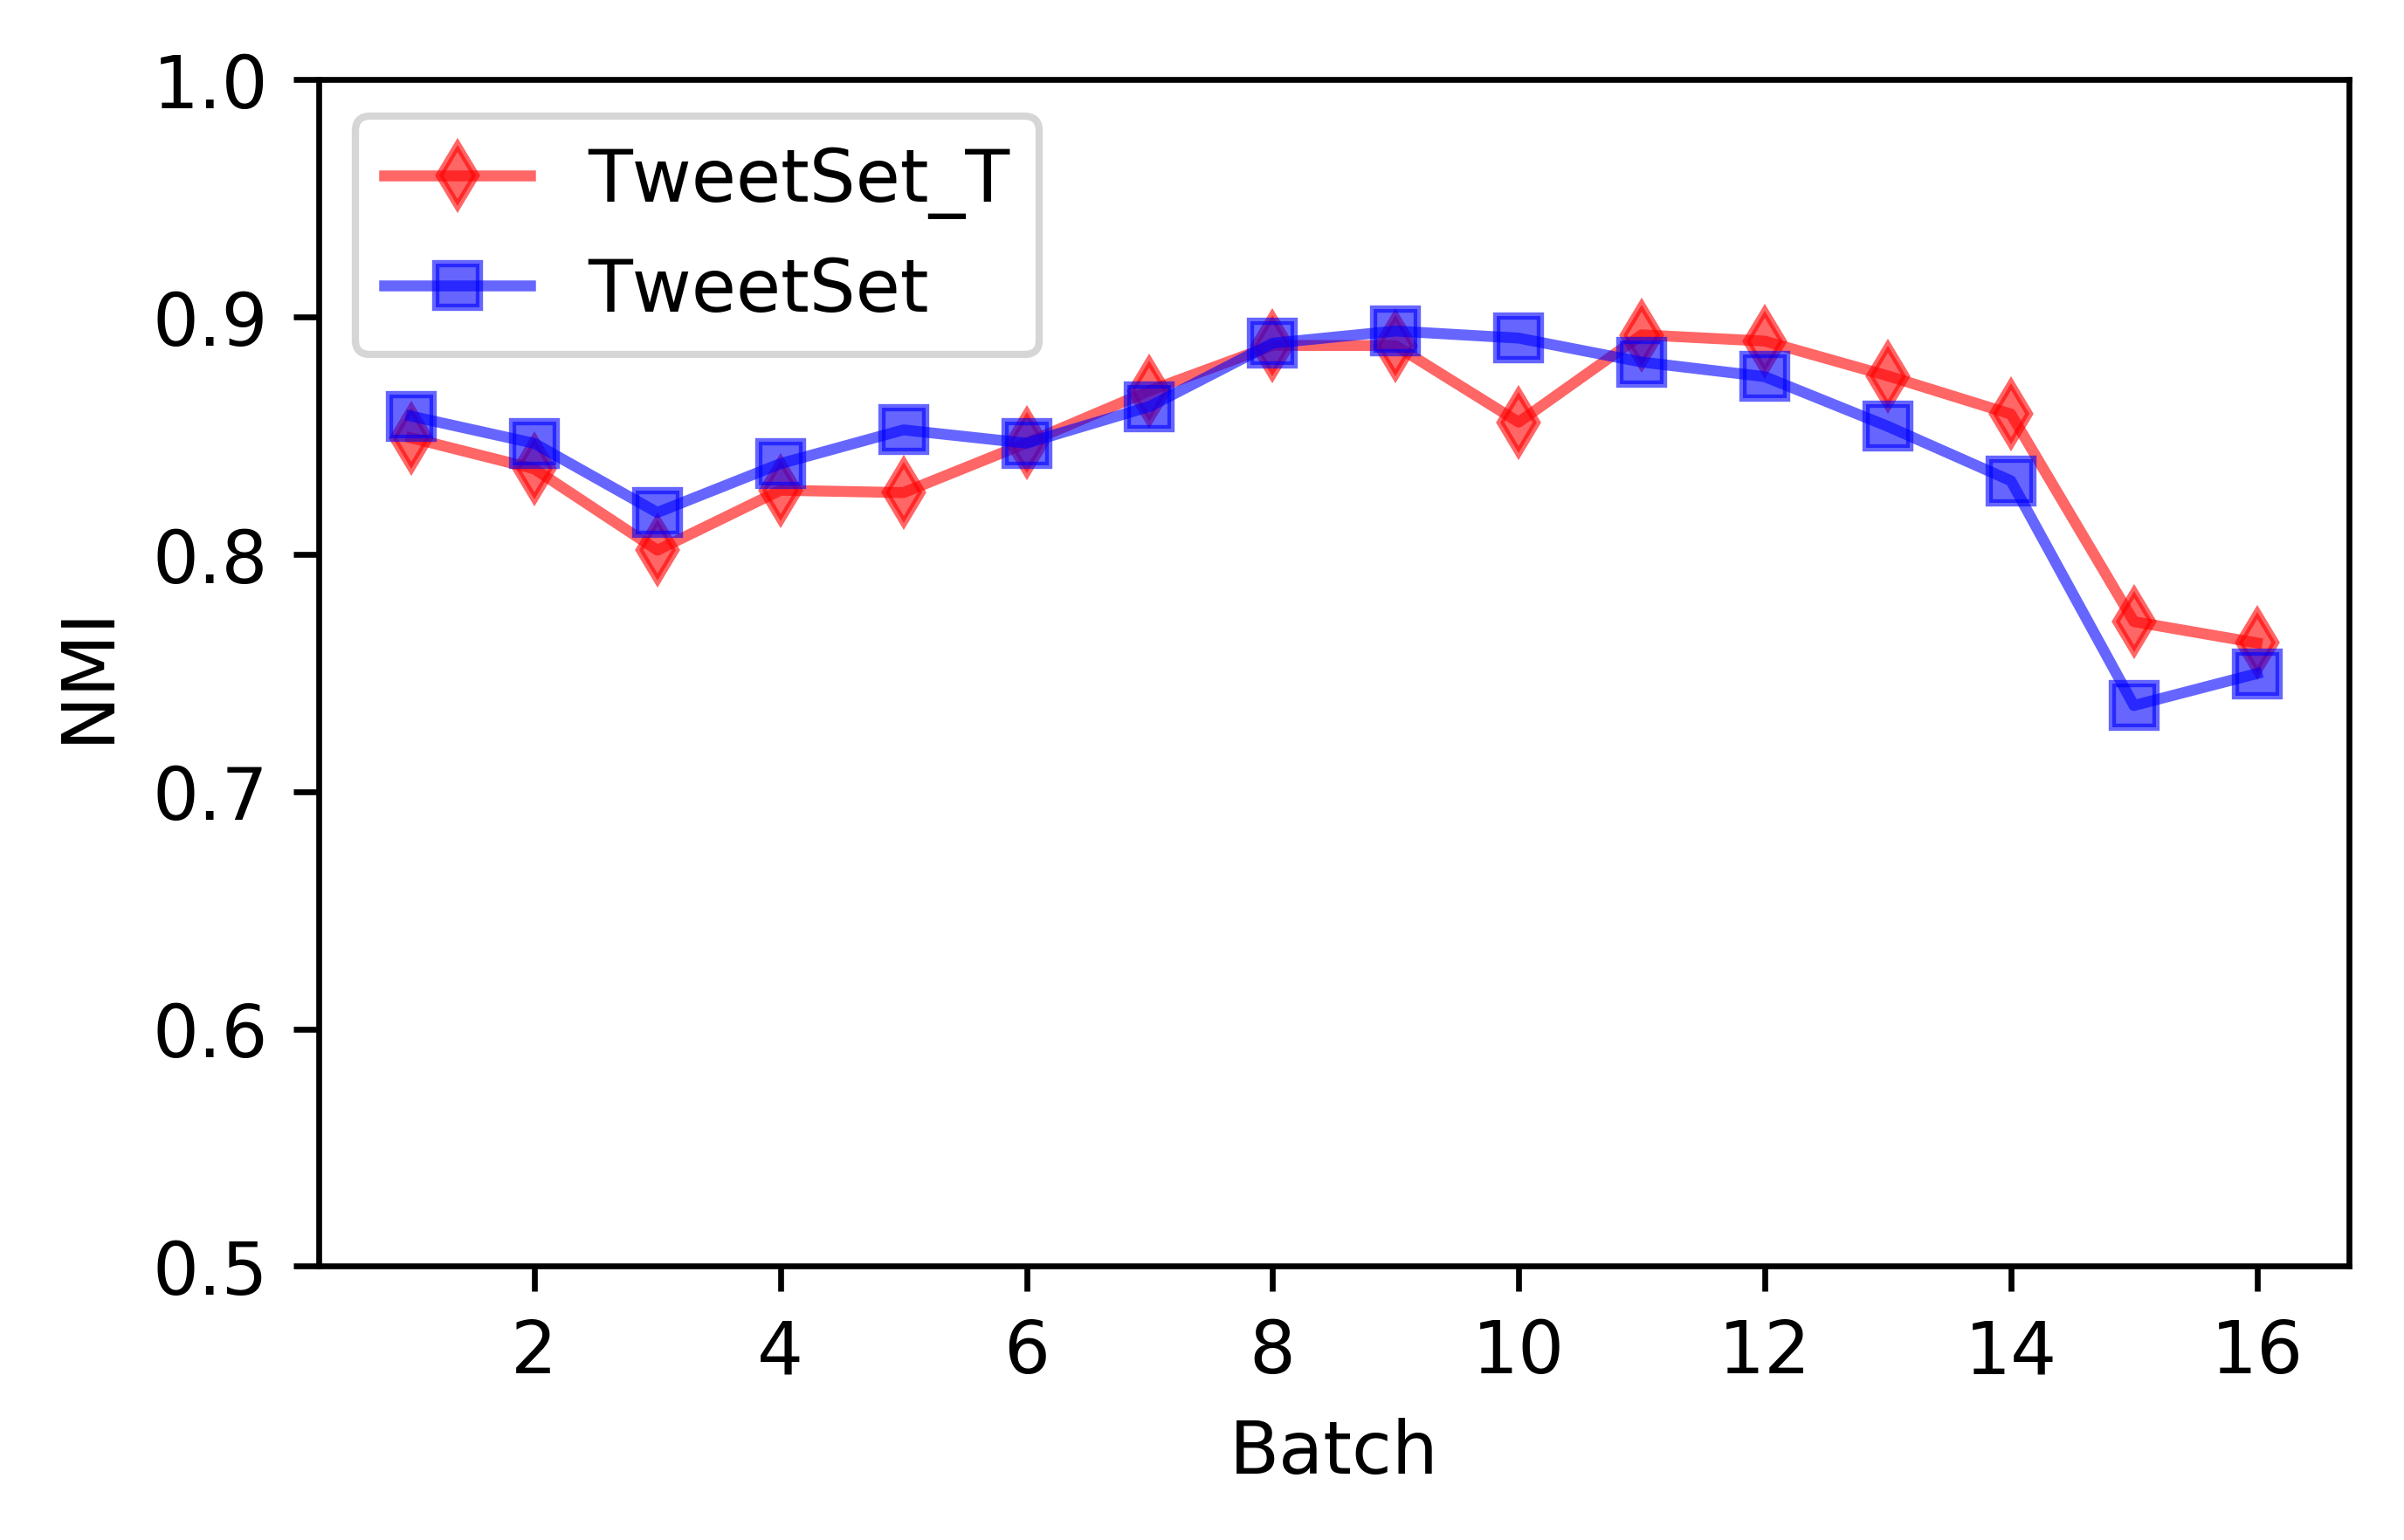

In [77]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
 
#设置x,y轴的数值（y=sinx）
#x = np.linspace(0, 10, 1000)
#y = np.sin(x)

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

f = plt.figure(figsize=(5,3),dpi = 600)


tweets_T = [0.8490775422178058, 0.8360113596016167, 0.8017326375272005, 0.8269963983134461, 0.8259949715651002, 0.8469034211974069, 0.8689500165610579, 0.8880185467940986, 0.8879679257956725, 0.8556842818338339, 0.8924981532543471, 0.8898471837668972, 0.8751979807882151, 0.8591115412272363, 0.7716295524551399, 0.7626682731533194]
#plt.plot(x, tweets_T, 'r', lw=1)
plt.plot( x,tweets_T, c= 'r',marker="d", alpha=0.6,label="TweetSet_T") 

tweets = [0.8582277769870341, 0.8467594772627566, 0.8176122906201756, 0.8382025839334374, 0.8524496138495188, 0.8468333908715137, 0.862296219586325, 0.8889635623836228, 0.8941015111502186, 0.8911113732635287, 0.8810209409462958, 0.8748642544317056, 0.8539281533323678, 0.8310020553123393, 0.7362796328459015, 0.7497441687944795]
#plt.plot(x, tweets, 'b', lw=1)
plt.plot( x,tweets, c= 'b',marker="s", alpha=0.6,label="TweetSet") 


plt.xlabel("Batch")
plt.ylabel("NMI")
 
#图表的标题
#plt.title("Performance")
 
#Y轴的范围
plt.ylim(0.5, 1.0)
 
#显示图示
plt.legend()
 
#显示图
plt.show()

f.savefig("NMIandInterationNews.pdf", bbox_inches='tight')


In [86]:
print(NMI_batch)
print(beta)
print(NMI_batch.values())

{1: 0.7932582930963841, 2: 0.8393106954884539, 3: 0.8657532862687363, 4: 0.8452884887545633, 5: 0.7983718780828861, 6: 0.8109112137938168, 7: 0.8440927354522494, 8: 0.9368629379023037, 9: 0.9334904144279972, 10: 0.9048536947695016, 11: 0.8339690063152223, 12: 0.7513985583695252, 13: 0.7701360467836332, 14: 0.8765568662398848, 15: 0.8788302695541802, 16: 0.8494919460970661}
0.02
dict_values([0.7932582930963841, 0.8393106954884539, 0.8657532862687363, 0.8452884887545633, 0.7983718780828861, 0.8109112137938168, 0.8440927354522494, 0.9368629379023037, 0.9334904144279972, 0.9048536947695016, 0.8339690063152223, 0.7513985583695252, 0.7701360467836332, 0.8765568662398848, 0.8788302695541802, 0.8494919460970661])


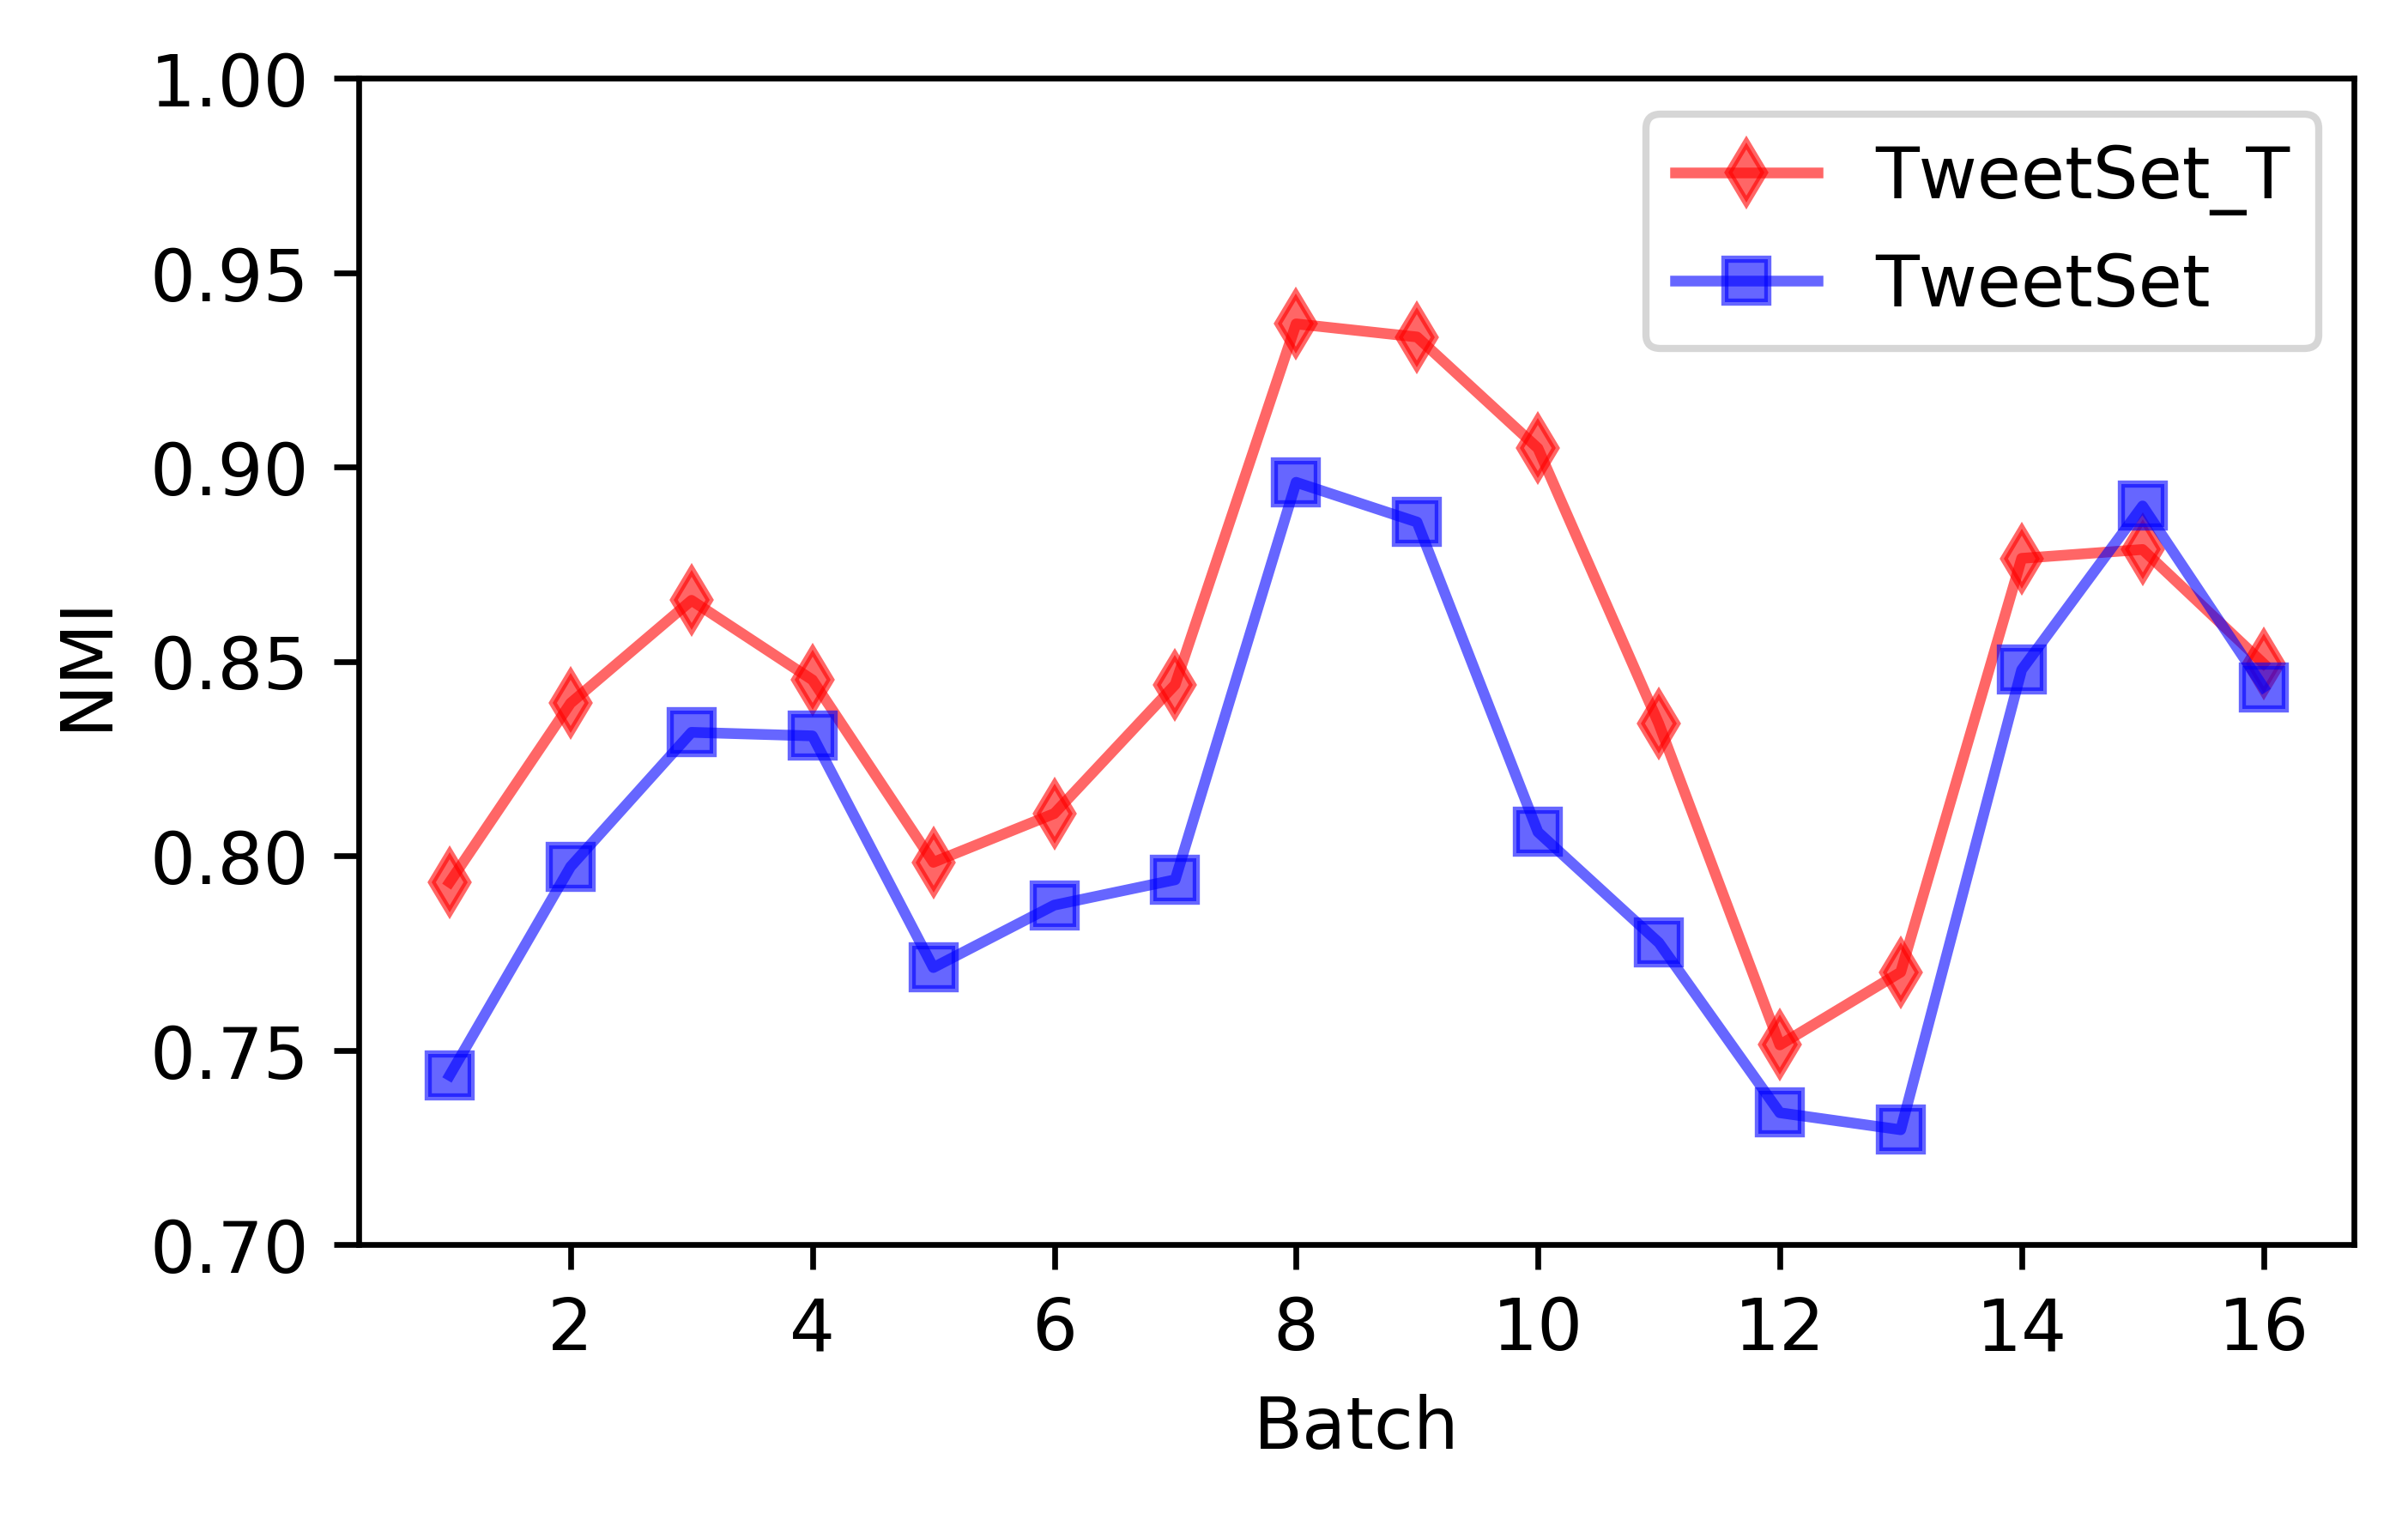

In [92]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
 
#设置x,y轴的数值（y=sinx）
#x = np.linspace(0, 10, 1000)
#y = np.sin(x)

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

f = plt.figure(figsize=(5,3),dpi = 600)


tweets_T = [0.7932582930963841, 0.8393106954884539, 0.8657532862687363, 0.8452884887545633, 0.7983718780828861, 0.8109112137938168, 0.8440927354522494, 0.9368629379023037, 0.9334904144279972, 0.9048536947695016, 0.8339690063152223, 0.7513985583695252, 0.7701360467836332, 0.8765568662398848, 0.8788302695541802, 0.8494919460970661]
#plt.plot(x, tweets_T, 'r', lw=1)
plt.plot( x,tweets_T, c= 'r',marker="d", alpha=0.6,label="TweetSet_T") 

tweets = [0.74358617620551, 0.7972567987965442, 0.8318064203875323, 0.8308878732798081, 0.7712990579197013, 0.7873606642011487, 0.7938912368104012, 0.8961130458375514, 0.8858844953668192, 0.8061639875625186, 0.7776982238779898, 0.7339626090234643, 0.7295843644905816, 0.8478840832767133, 0.8900298608325932, 0.8433912851221609]
#plt.plot(x, tweets, 'b', lw=1)
plt.plot( x,tweets, c= 'b',marker="s", alpha=0.6,label="TweetSet") 


plt.xlabel("Batch")
plt.ylabel("NMI")
 
#图表的标题
#plt.title("Performance")
 
#Y轴的范围
plt.ylim(0.7, 1.0)
 
#显示图示
plt.legend()
 
#显示图
plt.show()

f.savefig("NMIandInterationNews.pdf", bbox_inches='tight')


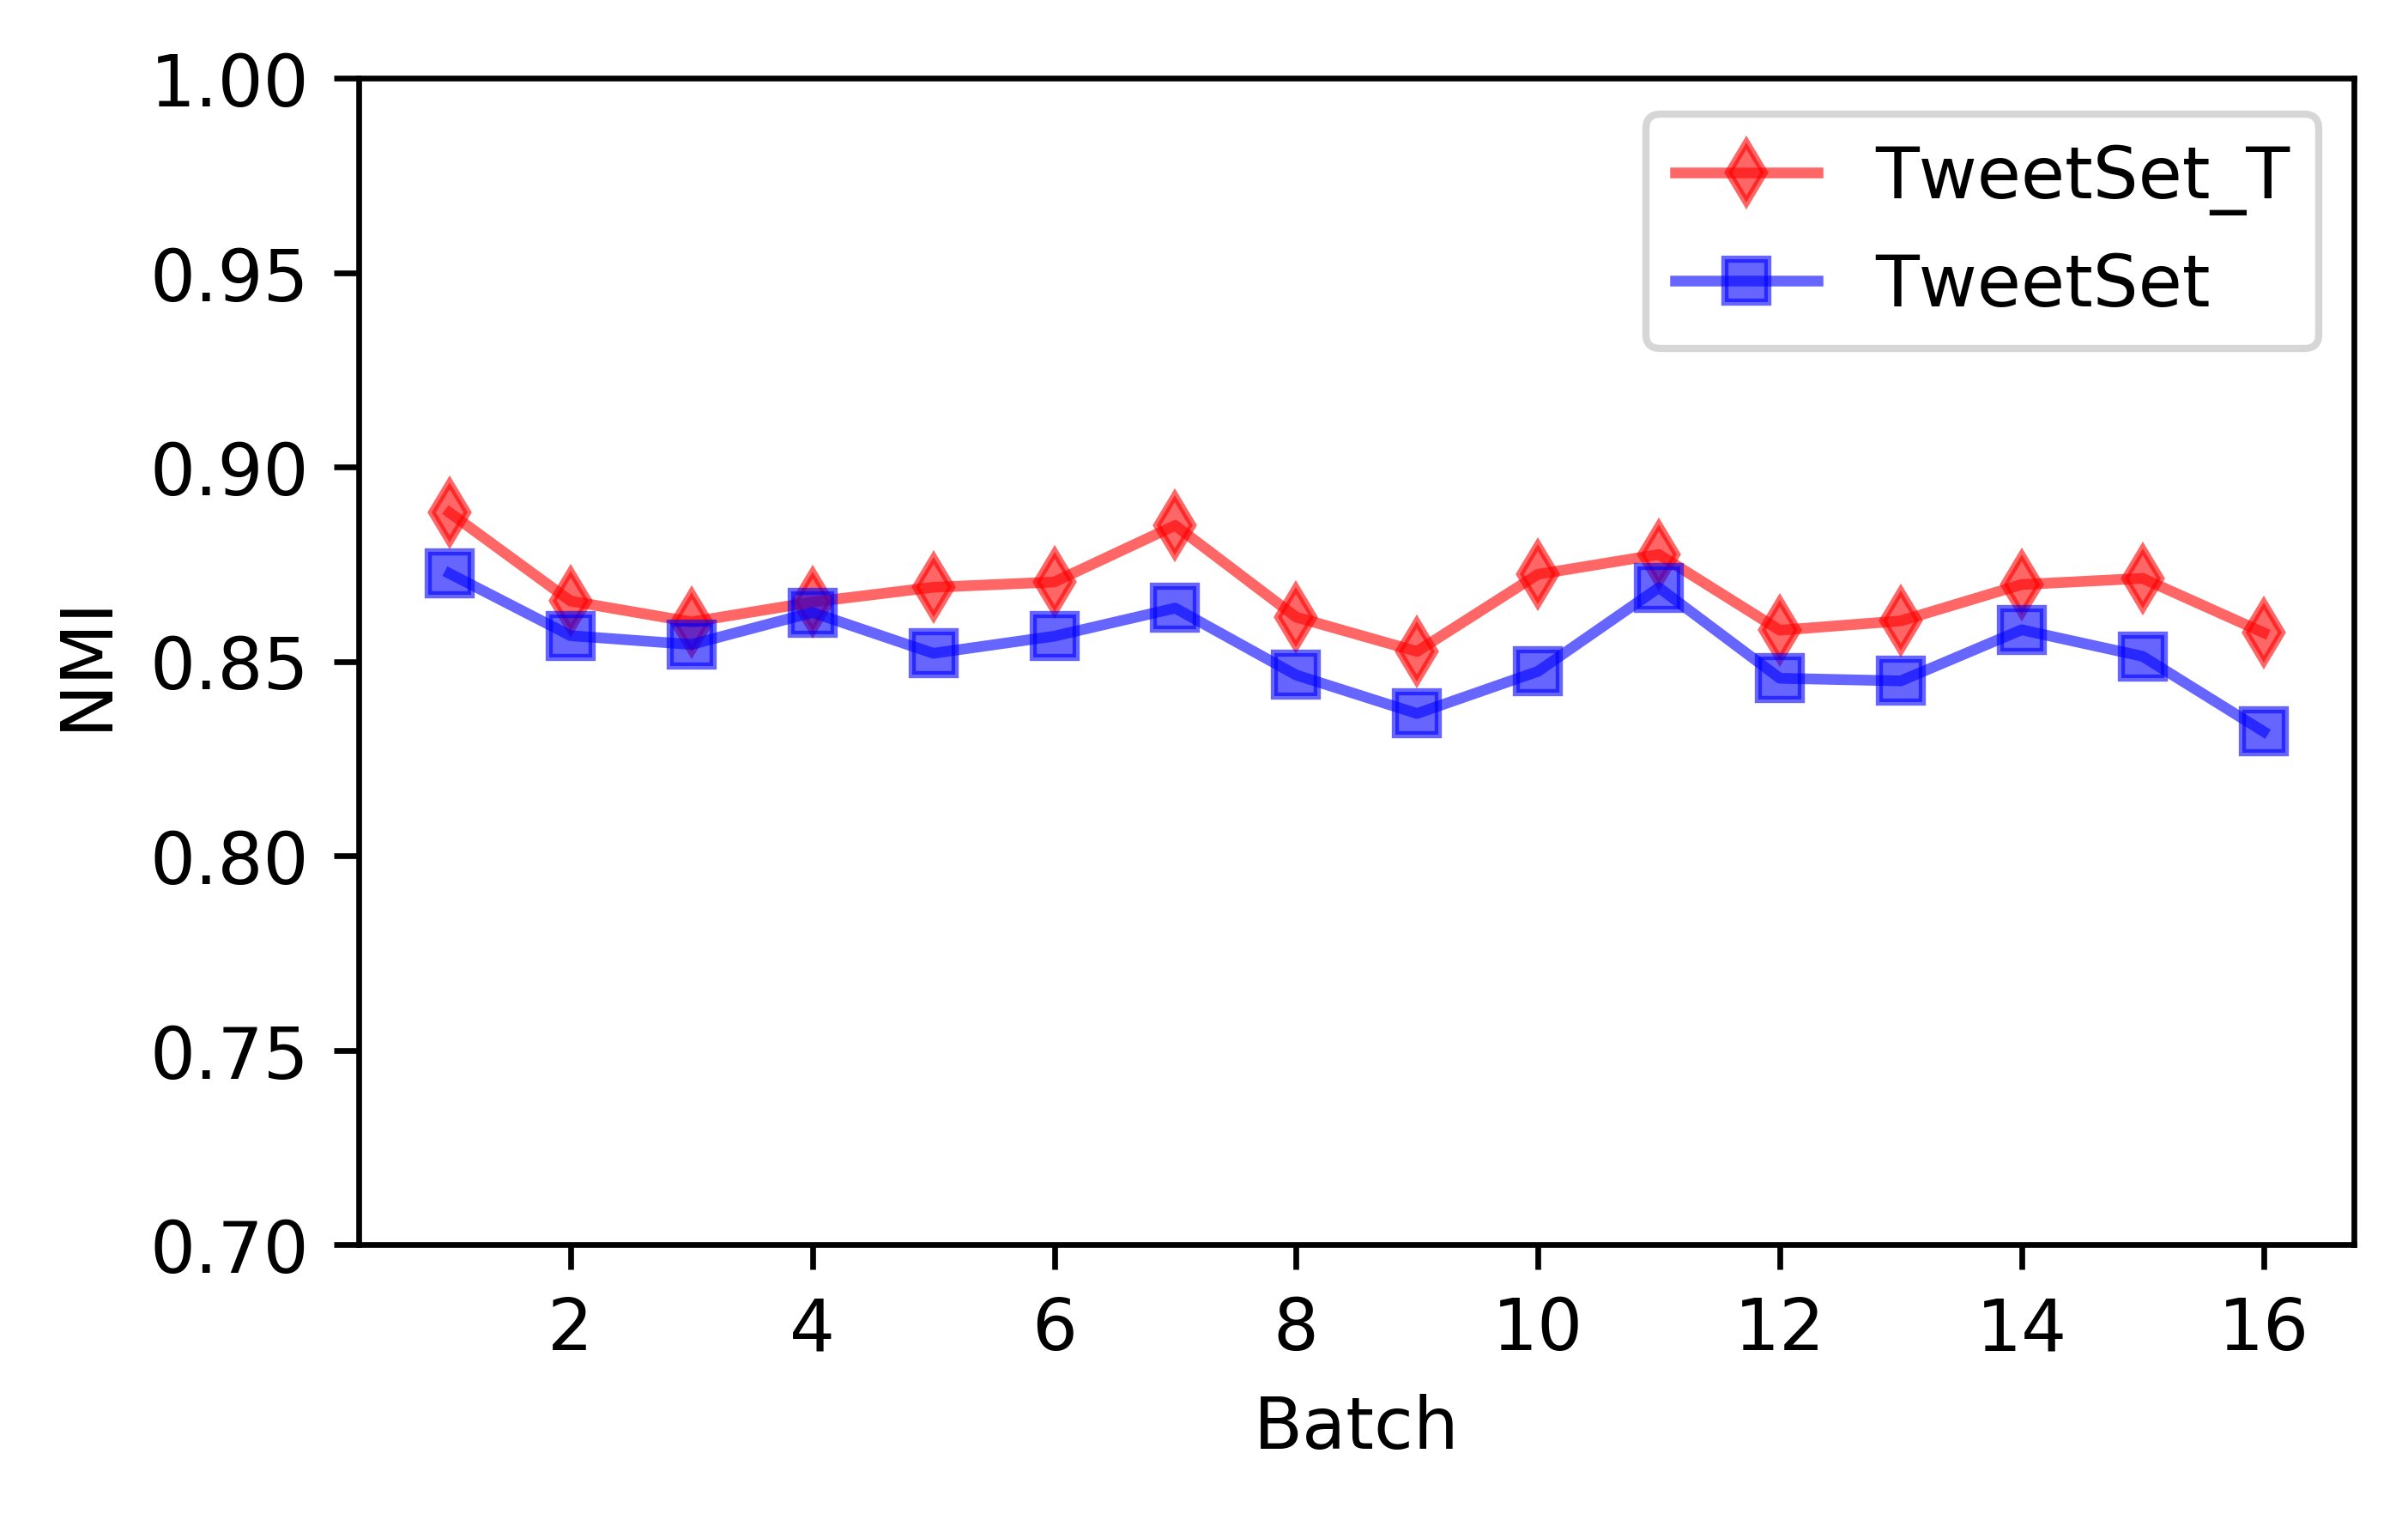

In [93]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
 
#设置x,y轴的数值（y=sinx）
#x = np.linspace(0, 10, 1000)
#y = np.sin(x)

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

f = plt.figure(figsize=(5,3),dpi = 600)


tweets_T = [0.8882984363075321, 0.8655685741007803, 0.8601966096751001, 0.8653117694146474, 0.8691099008525507, 0.870470086290841, 0.8850242362688984, 0.8614462503512703, 0.8526164464109245, 0.8724485266855552, 0.8775498841669781, 0.8580625490011807, 0.8604648478317101, 0.8698139510080556, 0.8714141829613143, 0.8574559445509717]
#plt.plot(x, tweets_T, 'r', lw=1)
plt.plot( x,tweets_T, c= 'r',marker="d", alpha=0.6,label="TweetSet_T") 

tweets = [0.8726365823761731, 0.8566633373187825, 0.8544016477026825, 0.8626448195293978, 0.8521307742254463, 0.8565295925956222, 0.8637605848627977, 0.8465501019420673, 0.8366437785511709, 0.847481365560549, 0.8690264753022972, 0.8457094143046929, 0.8450308638594545, 0.8581839723962552, 0.8513570035863224, 0.8320245596072464]
#plt.plot(x, tweets, 'b', lw=1)
plt.plot( x,tweets, c= 'b',marker="s", alpha=0.6,label="TweetSet") 


plt.xlabel("Batch")
plt.ylabel("NMI")
 
#图表的标题
#plt.title("Performance")
 
#Y轴的范围
plt.ylim(0.7, 1.0)
 
#显示图示
plt.legend()
 
#显示图
plt.show()

f.savefig("NMIandInterationNews.pdf", bbox_inches='tight')


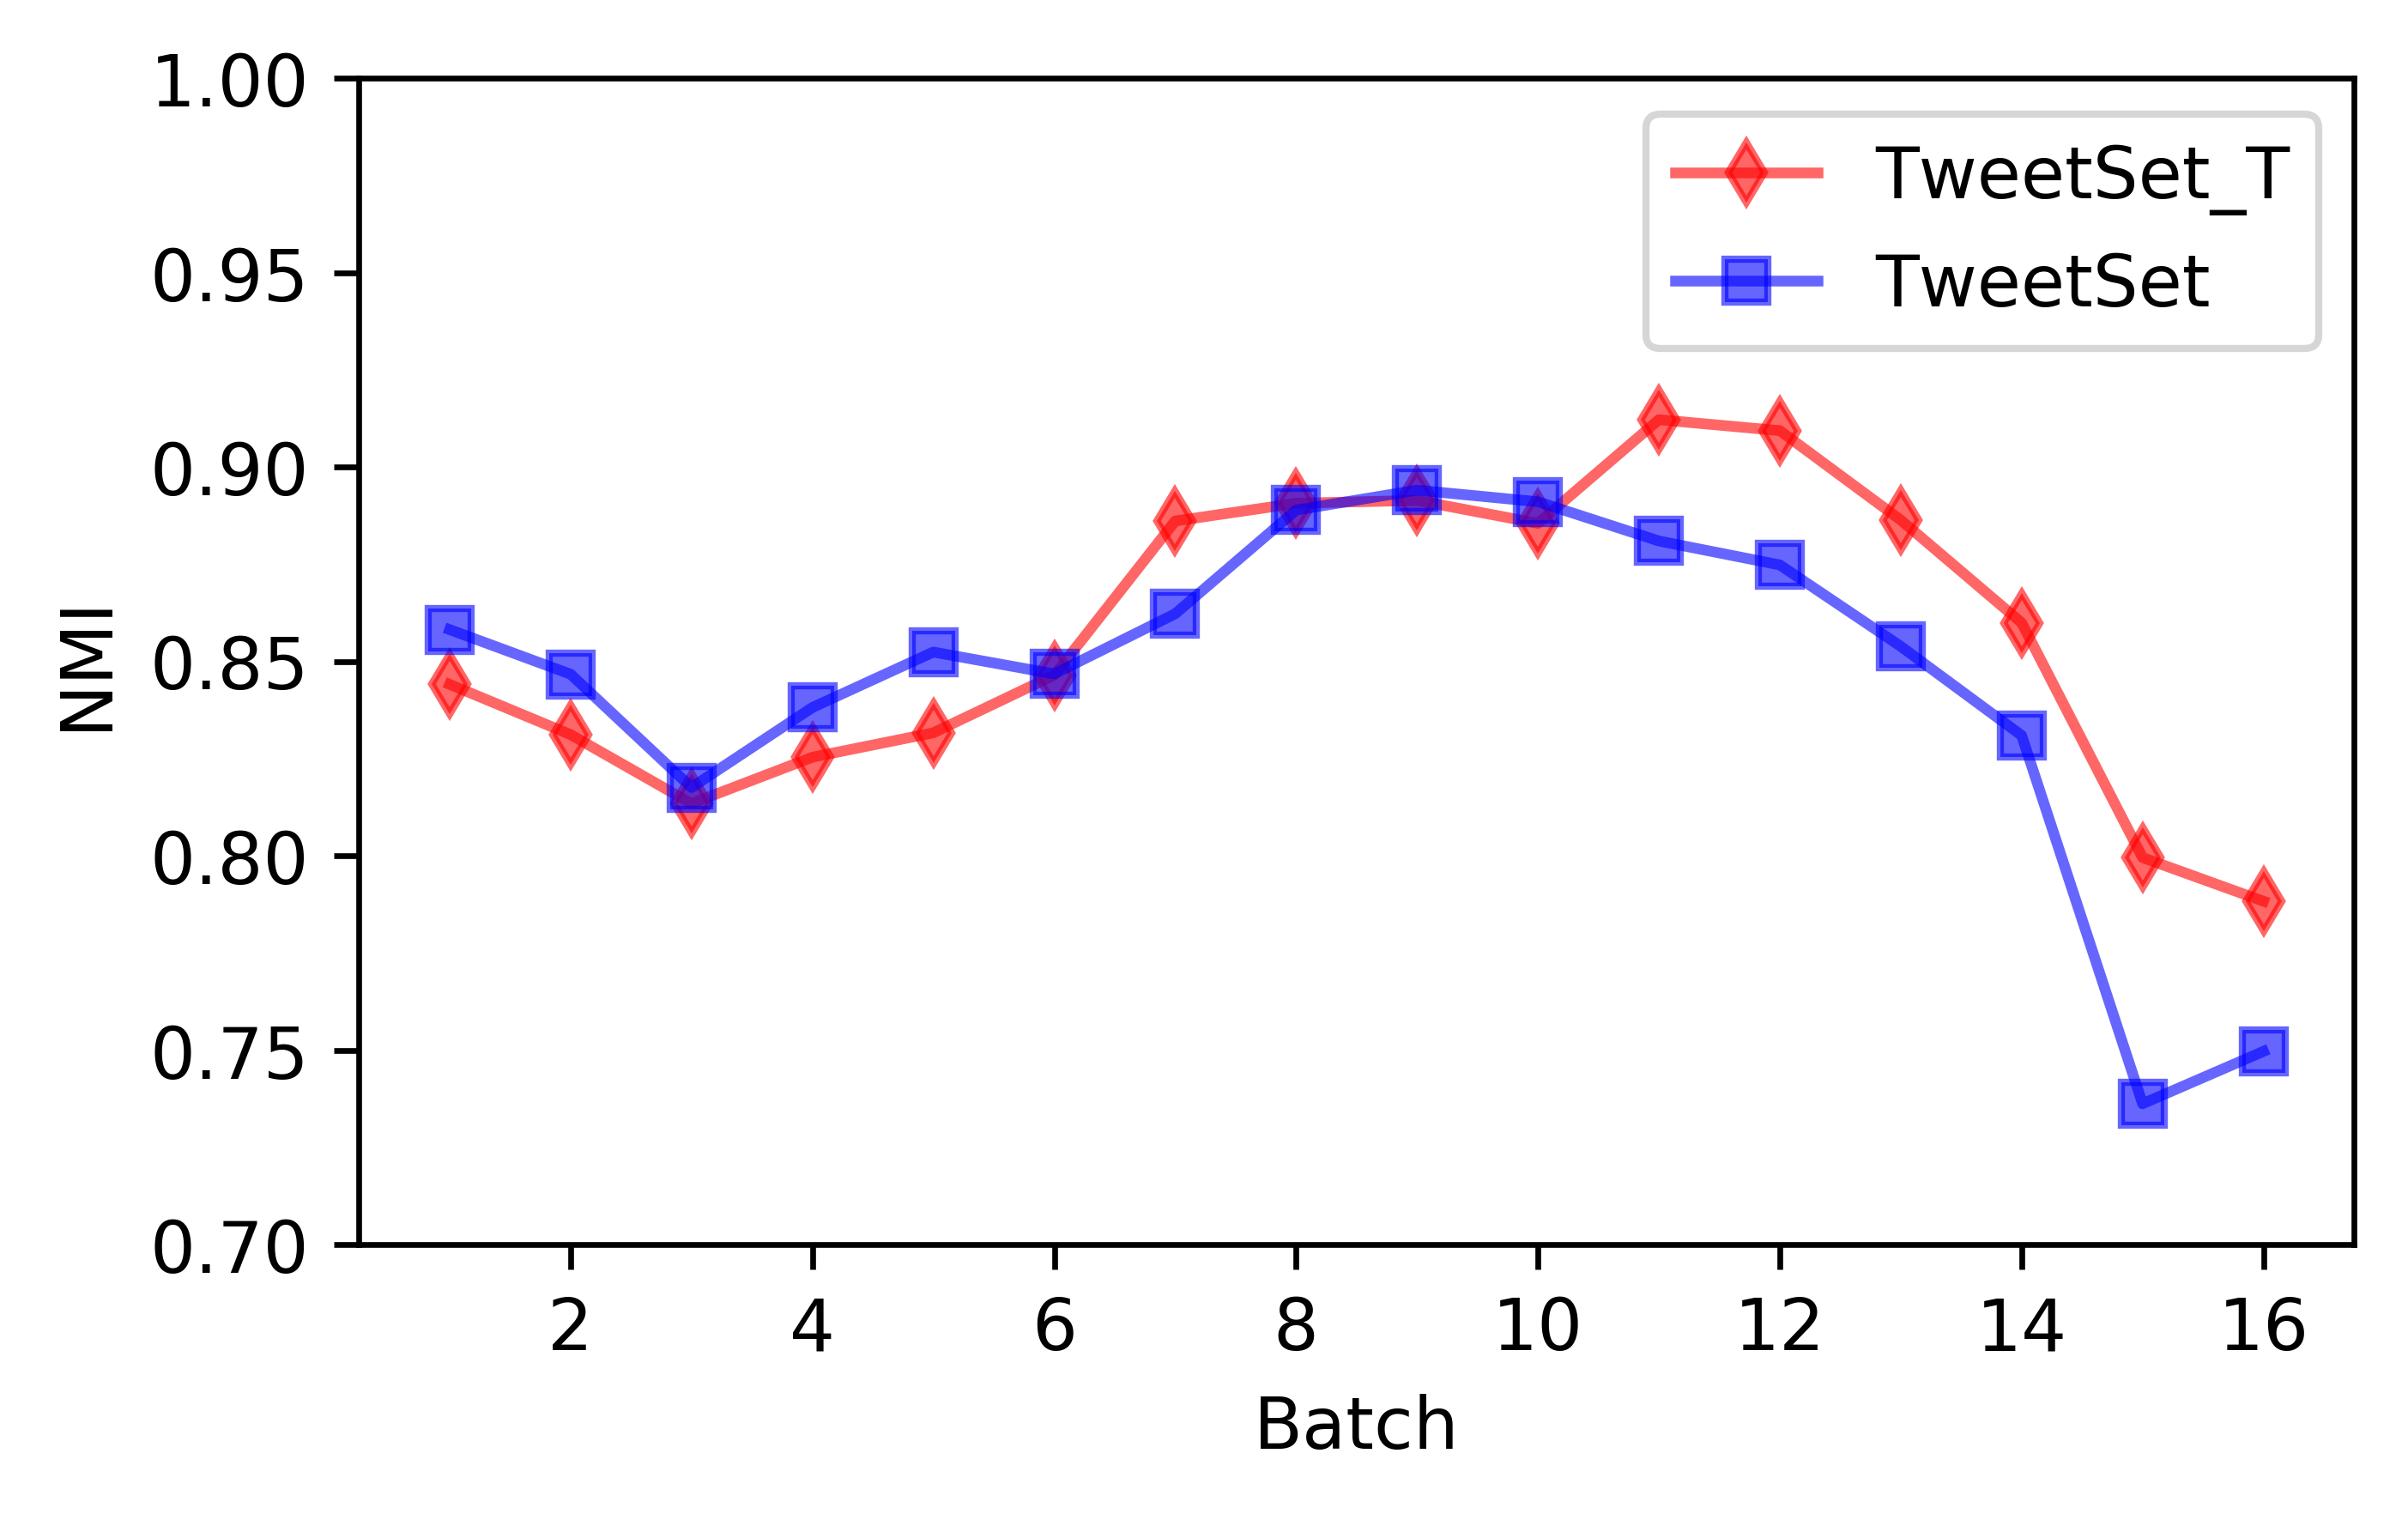

In [94]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
 
#设置x,y轴的数值（y=sinx）
#x = np.linspace(0, 10, 1000)
#y = np.sin(x)

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

f = plt.figure(figsize=(5,3),dpi = 600)


tweets_T = [0.8441538426522822, 0.8312210474530084, 0.8134929015078751, 0.8254108499197133, 0.8316848199157013, 0.8465183329341434, 0.8861585753363685, 0.8907185578531914, 0.8914560693223879, 0.8855585610744889, 0.9122174573737886, 0.9094036828236365, 0.8864085759101779, 0.8599767131213099, 0.7995858837720357, 0.7883701825543133]
#plt.plot(x, tweets_T, 'r', lw=1)
plt.plot( x,tweets_T, c= 'r',marker="d", alpha=0.6,label="TweetSet_T") 

tweets = [0.8582277769870341, 0.8467594772627566, 0.8176122906201756, 0.8382025839334374, 0.8524496138495188, 0.8468333908715137, 0.862296219586325, 0.8889635623836228, 0.8941015111502186, 0.8911113732635287, 0.8810209409462958, 0.8748642544317056, 0.8539281533323678, 0.8310020553123393, 0.7362796328459015, 0.7497441687944795]
#plt.plot(x, tweets, 'b', lw=1)
plt.plot( x,tweets, c= 'b',marker="s", alpha=0.6,label="TweetSet") 


plt.xlabel("Batch")
plt.ylabel("NMI")
 
#图表的标题
#plt.title("Performance")
 
#Y轴的范围
plt.ylim(0.7, 1.0)
 
#显示图示
plt.legend()
 
#显示图
plt.show()

f.savefig("NMIandInterationNews.pdf", bbox_inches='tight')


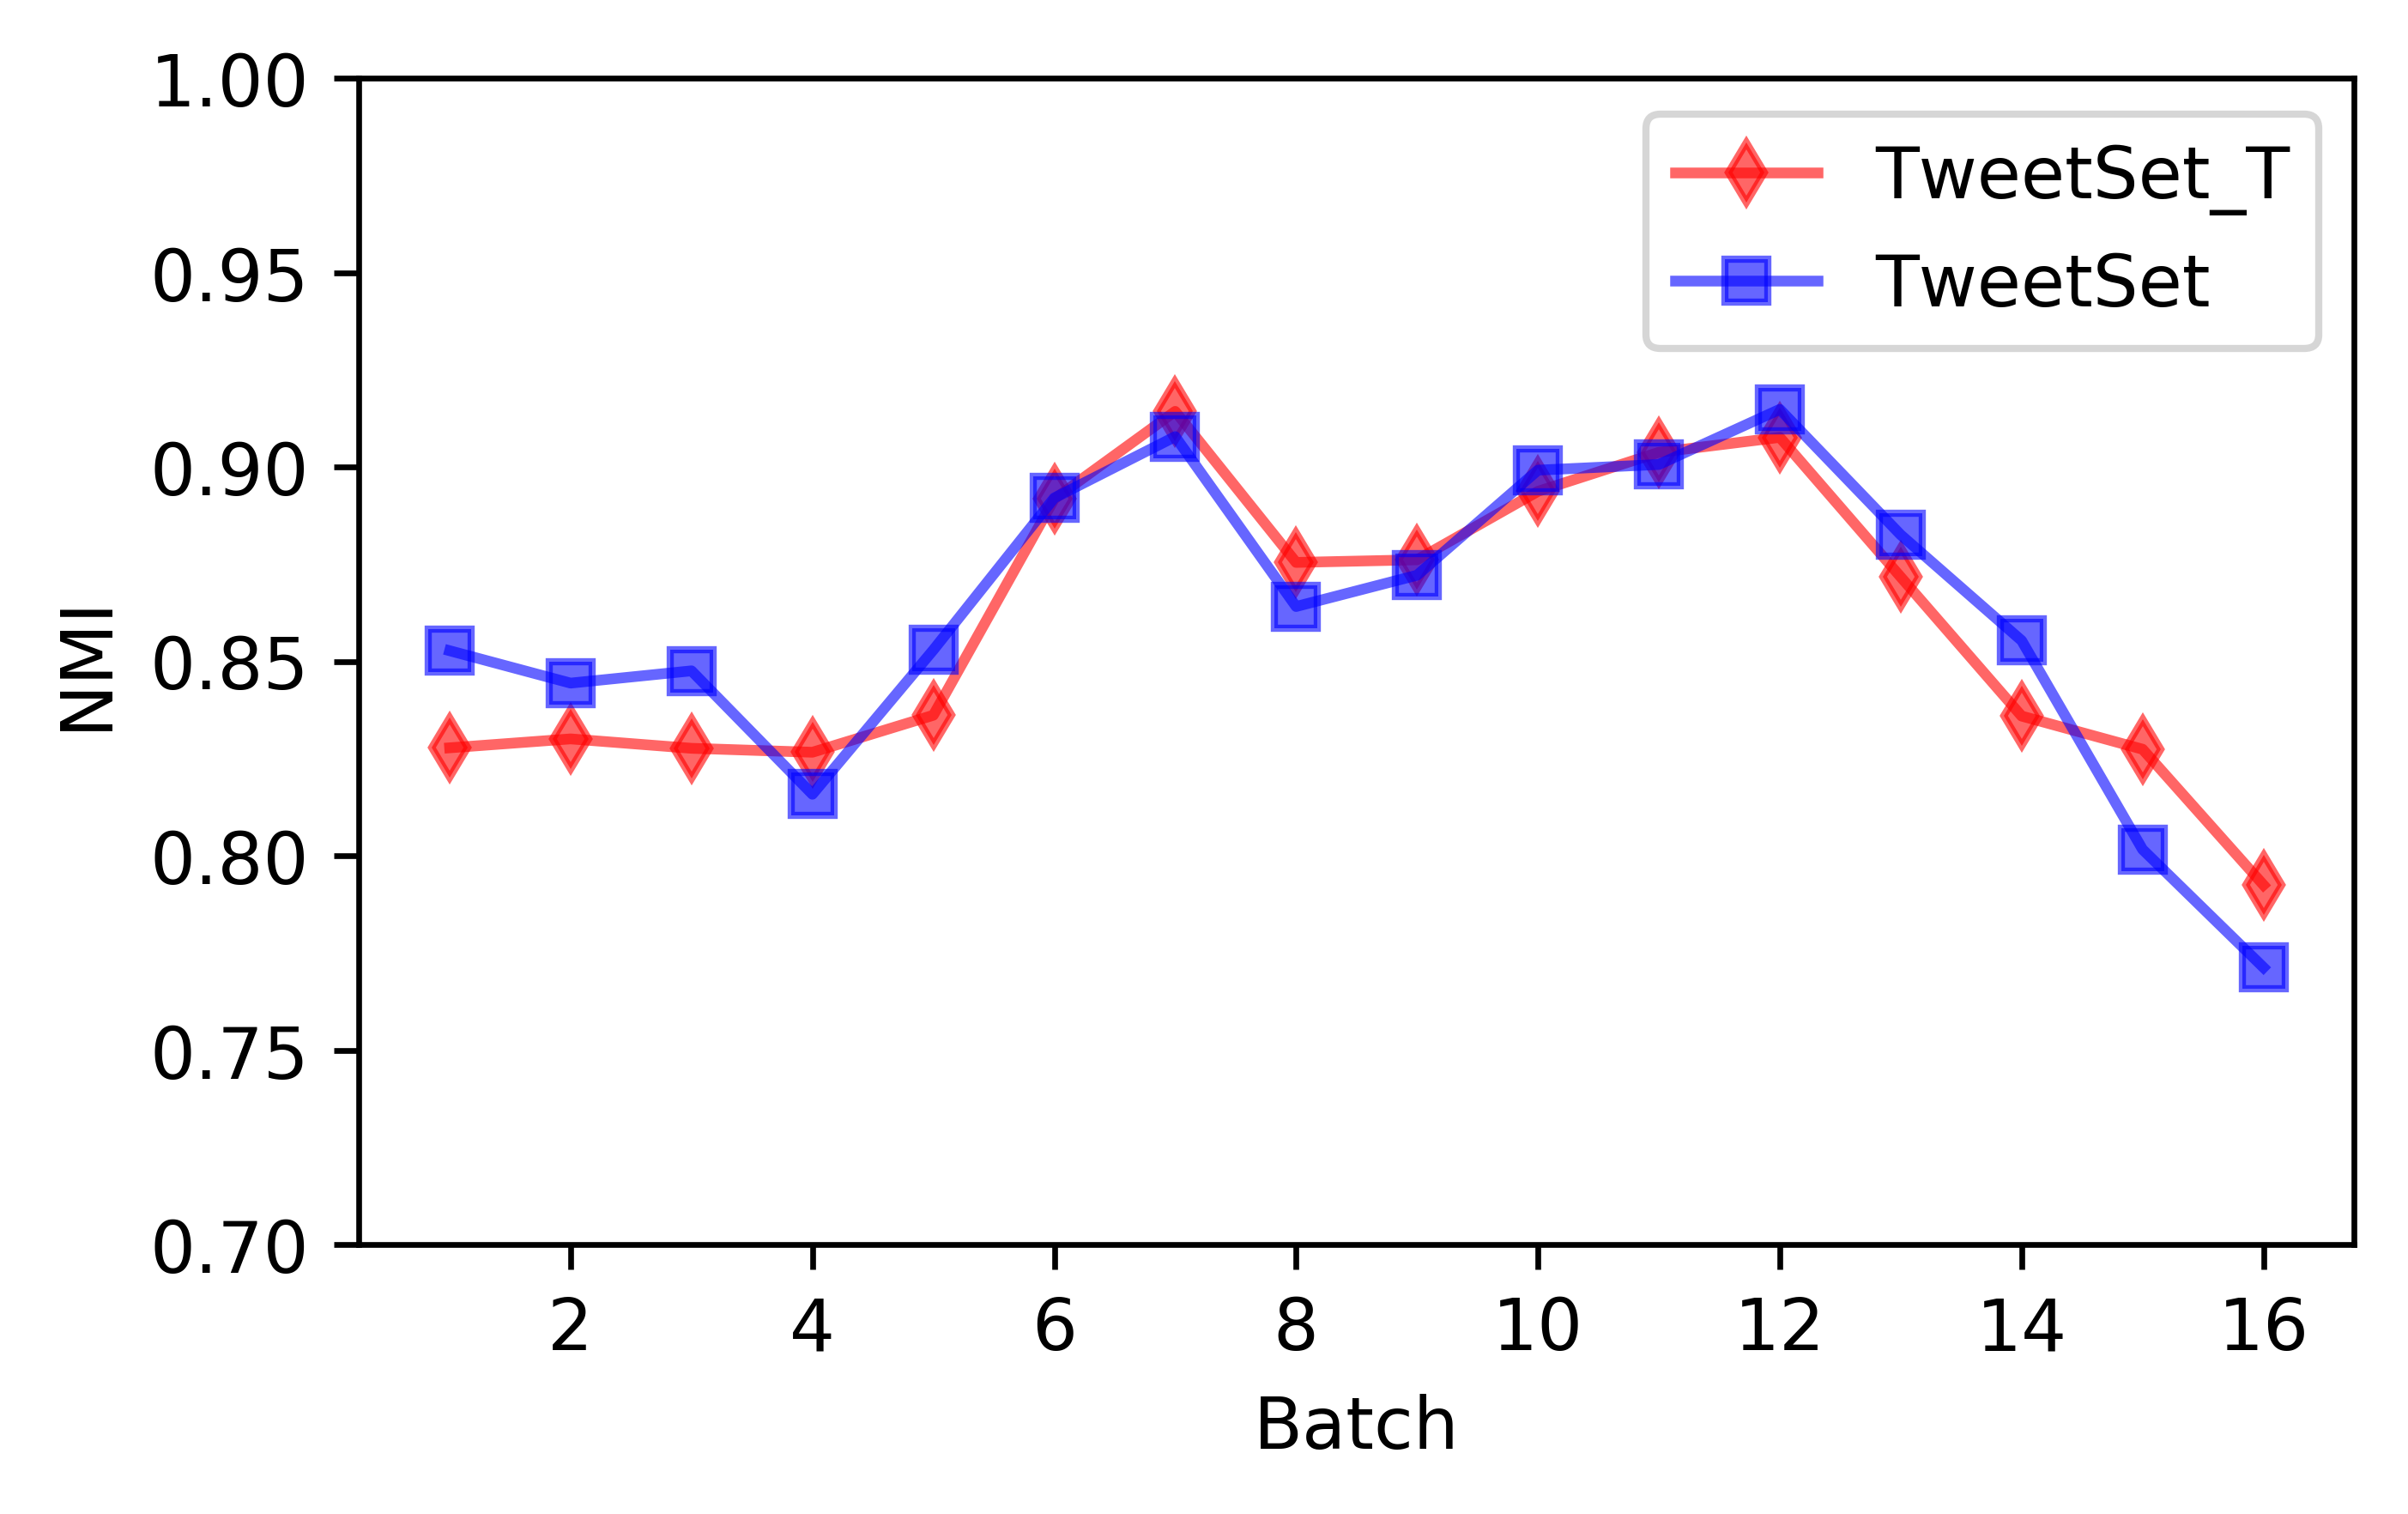

In [95]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
 
#设置x,y轴的数值（y=sinx）
#x = np.linspace(0, 10, 1000)
#y = np.sin(x)

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

f = plt.figure(figsize=(5,3),dpi = 600)


tweets_T = [0.8278218254942188, 0.8301163585429583, 0.8276996464223356, 0.8266799384278927, 0.8361987253008136, 0.8918132625586427, 0.9143589365596025, 0.8755057317179911, 0.8761813446904034, 0.8937849598731826, 0.9038236974191605, 0.9076669340448583, 0.8717577659131356, 0.8359866418427073, 0.8274625028703796, 0.7925454624242205]
#plt.plot(x, tweets_T, 'r', lw=1)
plt.plot( x,tweets_T, c= 'r',marker="d", alpha=0.6,label="TweetSet_T") 

tweets = [0.8527952379198, 0.8444641956483188, 0.8476225367283937, 0.815880442857182, 0.8529959300853747, 0.8920885768609056, 0.9078646361632985, 0.8641634143910938, 0.8722109786302807, 0.8992361785787981, 0.900699048006089, 0.9148774404964803, 0.8825998775897432, 0.8553964676827042, 0.8016843811673828, 0.7713276208756674]
#plt.plot(x, tweets, 'b', lw=1)
plt.plot( x,tweets, c= 'b',marker="s", alpha=0.6,label="TweetSet") 


plt.xlabel("Batch")
plt.ylabel("NMI")
 
#图表的标题
#plt.title("Performance")
 
#Y轴的范围
plt.ylim(0.7, 1.0)
 
#显示图示
plt.legend()
 
#显示图
plt.show()

f.savefig("NMIandInterationNews.pdf", bbox_inches='tight')


In [109]:
nmi_batch = {}
topic_batch = {}
start = 0
end = 0
total_batch = None
if len(corpus) % 500 == 0:
    total_batch = int(len(corpus) / 500)
else:
    total_batch = int(len(corpus) / 500) +1

for batch in range(total_batch):
    docID_assign_z = {}
    m_z = {}
    n_z = {}
    n_w = {}
    n_b = {}
    Topics = []
    V = set()
    D = set()
    alpha = 0.6
    beta = 0.2
    end = 500 * (batch + 1)
    if end > len(corpus):
        end = len(corpus)
    nmi_batch[batch] = 0
    topic_batch[batch] = 0
    
    total_iter = 10
    for iter in range(total_iter):
        for docID in range(start,end):
            words = corpus[docID]
            D.discard(docID)
            if docID in docID_assign_z.keys():
                before_k = docID_assign_z[docID]
                m_z[before_k].discard(docID)
                for biterm in words:
                    for word in biterm.split(','):
                        n_z[before_k][word] -= 1
                        n_w[before_k] -=1
            else:
                before_k = -1
            if len(D) == 0 and len(V) == 0:
                choose_k = 0
                D.add(docID)
                docID_assign_z[docID] = choose_k
                if choose_k not in m_z.keys():
                    m_z[choose_k] = set()
                m_z[choose_k].add(docID)
                for biterm in words:
                    for word in biterm.split(','):
                        if choose_k not in n_w.keys():
                            n_w[choose_k] = 0
                        if choose_k not in n_z.keys():
                            n_z[choose_k] = {}
                        if word not in n_z[choose_k].keys():
                            n_z[choose_k][word] = 0
                        n_z[choose_k][word] += 1
                        n_w[choose_k] += 1
                        V.add(word)
                if choose_k not in Topics:
                    Topics.append(choose_k)
            else:
                log_pro = []
                for k in Topics:
                    pro_k = len(m_z[k])
                    if pro_k != 0:
                        i = 0
                        for biterm in words:
                            each_word = biterm.strip().split(',')
                            for word in each_word:
                                if word not in n_z[k].keys():
                                    n_z[k][word] = 0
                            for j in range(doc_biterm[docID][biterm]):
                                pro_k *= (n_z[k][each_word[0]] + n_z[k][each_word[-1]] + beta + j) / ( n_w[k] + len(V)*beta + i) 
                                i += 1

                    if pro_k == 0:
                        pro_k = sys.float_info.min
                    log_pro.append(pro_k)

                pro_new_k = alpha*(len(D))
                i = 0
                for biterm in words:
                    for j in range(doc_biterm[docID][biterm]):
                        pro_new_k *= ( beta + j) / ( len(V)*beta + i) 
                        i += 1

                if pro_new_k == 0:
                    pro_new_k = sys.float_info.min        
                log_pro.append(pro_new_k)

                sum_pro=sum(log_pro)

                normalized_posterior = [i/sum_pro for i in log_pro]    
                select_k = None
                if iter == (total_iter - 1):
                    select_k = normalized_posterior.index(max(normalized_posterior))

                else:
                    select_k = np.random.choice( (len(Topics)+1) , 1, p=normalized_posterior)[0]  

                if select_k == len(Topics):
                    choose_k = np.max(Topics) + 1
                else:
                    choose_k = Topics[select_k]

                D.add(docID)
                docID_assign_z[docID] = choose_k
                if choose_k not in m_z.keys():
                    m_z[choose_k] = set()
                m_z[choose_k].add(docID)
                for biterm in words:
                    for word in biterm.split(','):
                        if choose_k not in n_w.keys():
                            n_w[choose_k] = 0
                        if choose_k not in n_z.keys():
                            n_z[choose_k] = {}
                        if word not in n_z[choose_k].keys():
                            n_z[choose_k][word] = 0
                        n_z[choose_k][word] += 1
                        n_w[choose_k] += 1
                        V.add(word)
                if choose_k not in Topics:
                    Topics.append(choose_k)

            count_k = []
            for k in Topics:
                if k in m_z.keys() and len(m_z[k]) == 0:
                    m_z.pop(k, None)
                    n_z.pop(k, None)
                    n_w.pop(k, None)
                    count_k.append(k)
            for k in count_k:
                Topics.remove(k)   
        if iter == 9:
            from sklearn.metrics.cluster import normalized_mutual_info_score
            nmi_sample = []
            nmi_result = []
            for key, value in news_labels.items():
                if key < end and key >= start:
                    nmi_sample.append(value)
                    nmi_result.append(docID_assign_z[key])
            nmi_batch[batch] = normalized_mutual_info_score(np.array(nmi_sample), np.array(nmi_result))
            topic_batch[batch] = len(Topics)
            print("start ",start, " end ",end, "topics: ",len(Topics),"truth: ",len(np.unique(nmi_sample)), " NMI: ",normalized_mutual_info_score(np.array(nmi_sample), np.array(nmi_result)))
    start = end 
 
    

start  0  end  500 topics:  23 truth:  7  NMI:  0.8040909731061748
start  500  end  1000 topics:  33 truth:  14  NMI:  0.8539381713147824
start  1000  end  1500 topics:  25 truth:  14  NMI:  0.8631500026757704
start  1500  end  2000 topics:  18 truth:  8  NMI:  0.8581423068099691
start  2000  end  2500 topics:  28 truth:  16  NMI:  0.8408326979875911
start  2500  end  3000 topics:  29 truth:  22  NMI:  0.7845977154166763
start  3000  end  3500 topics:  35 truth:  18  NMI:  0.881702320624207
start  3500  end  4000 topics:  15 truth:  7  NMI:  0.7774219880032176
start  4000  end  4500 topics:  23 truth:  20  NMI:  0.8904844600898871
start  4500  end  5000 topics:  28 truth:  20  NMI:  0.9055376438183647
start  5000  end  5500 topics:  16 truth:  7  NMI:  0.9182201924791991
start  5500  end  6000 topics:  18 truth:  12  NMI:  0.9403533180828537
start  6000  end  6500 topics:  15 truth:  11  NMI:  0.8984907776468016
start  6500  end  7000 topics:  29 truth:  13  NMI:  0.8022921728604256
st

In [104]:
print(nmi_batch.keys())
print(nmi_batch.values())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])
dict_values([0.7693828291684766, 0.8256664037451413, 0.7821788529920924, 0.7960449165455996, 0.8135666714954576, 0.7835938629064161, 0.8288836927352627, 0.7576508105894485, 0.8595344525508966, 0.8737512957102533, 0.9001484071646036, 0.8868981586783966, 0.8562803616906821, 0.7696792858323661, 0.7900206907303219, 0.7076886839038332, 0.749608102365535, 0.7385885323263619, 0.9377288540023693, 0.8615467886621885, 0.8464187833492403, 0.8902738974167599, 0.8798569121323756])


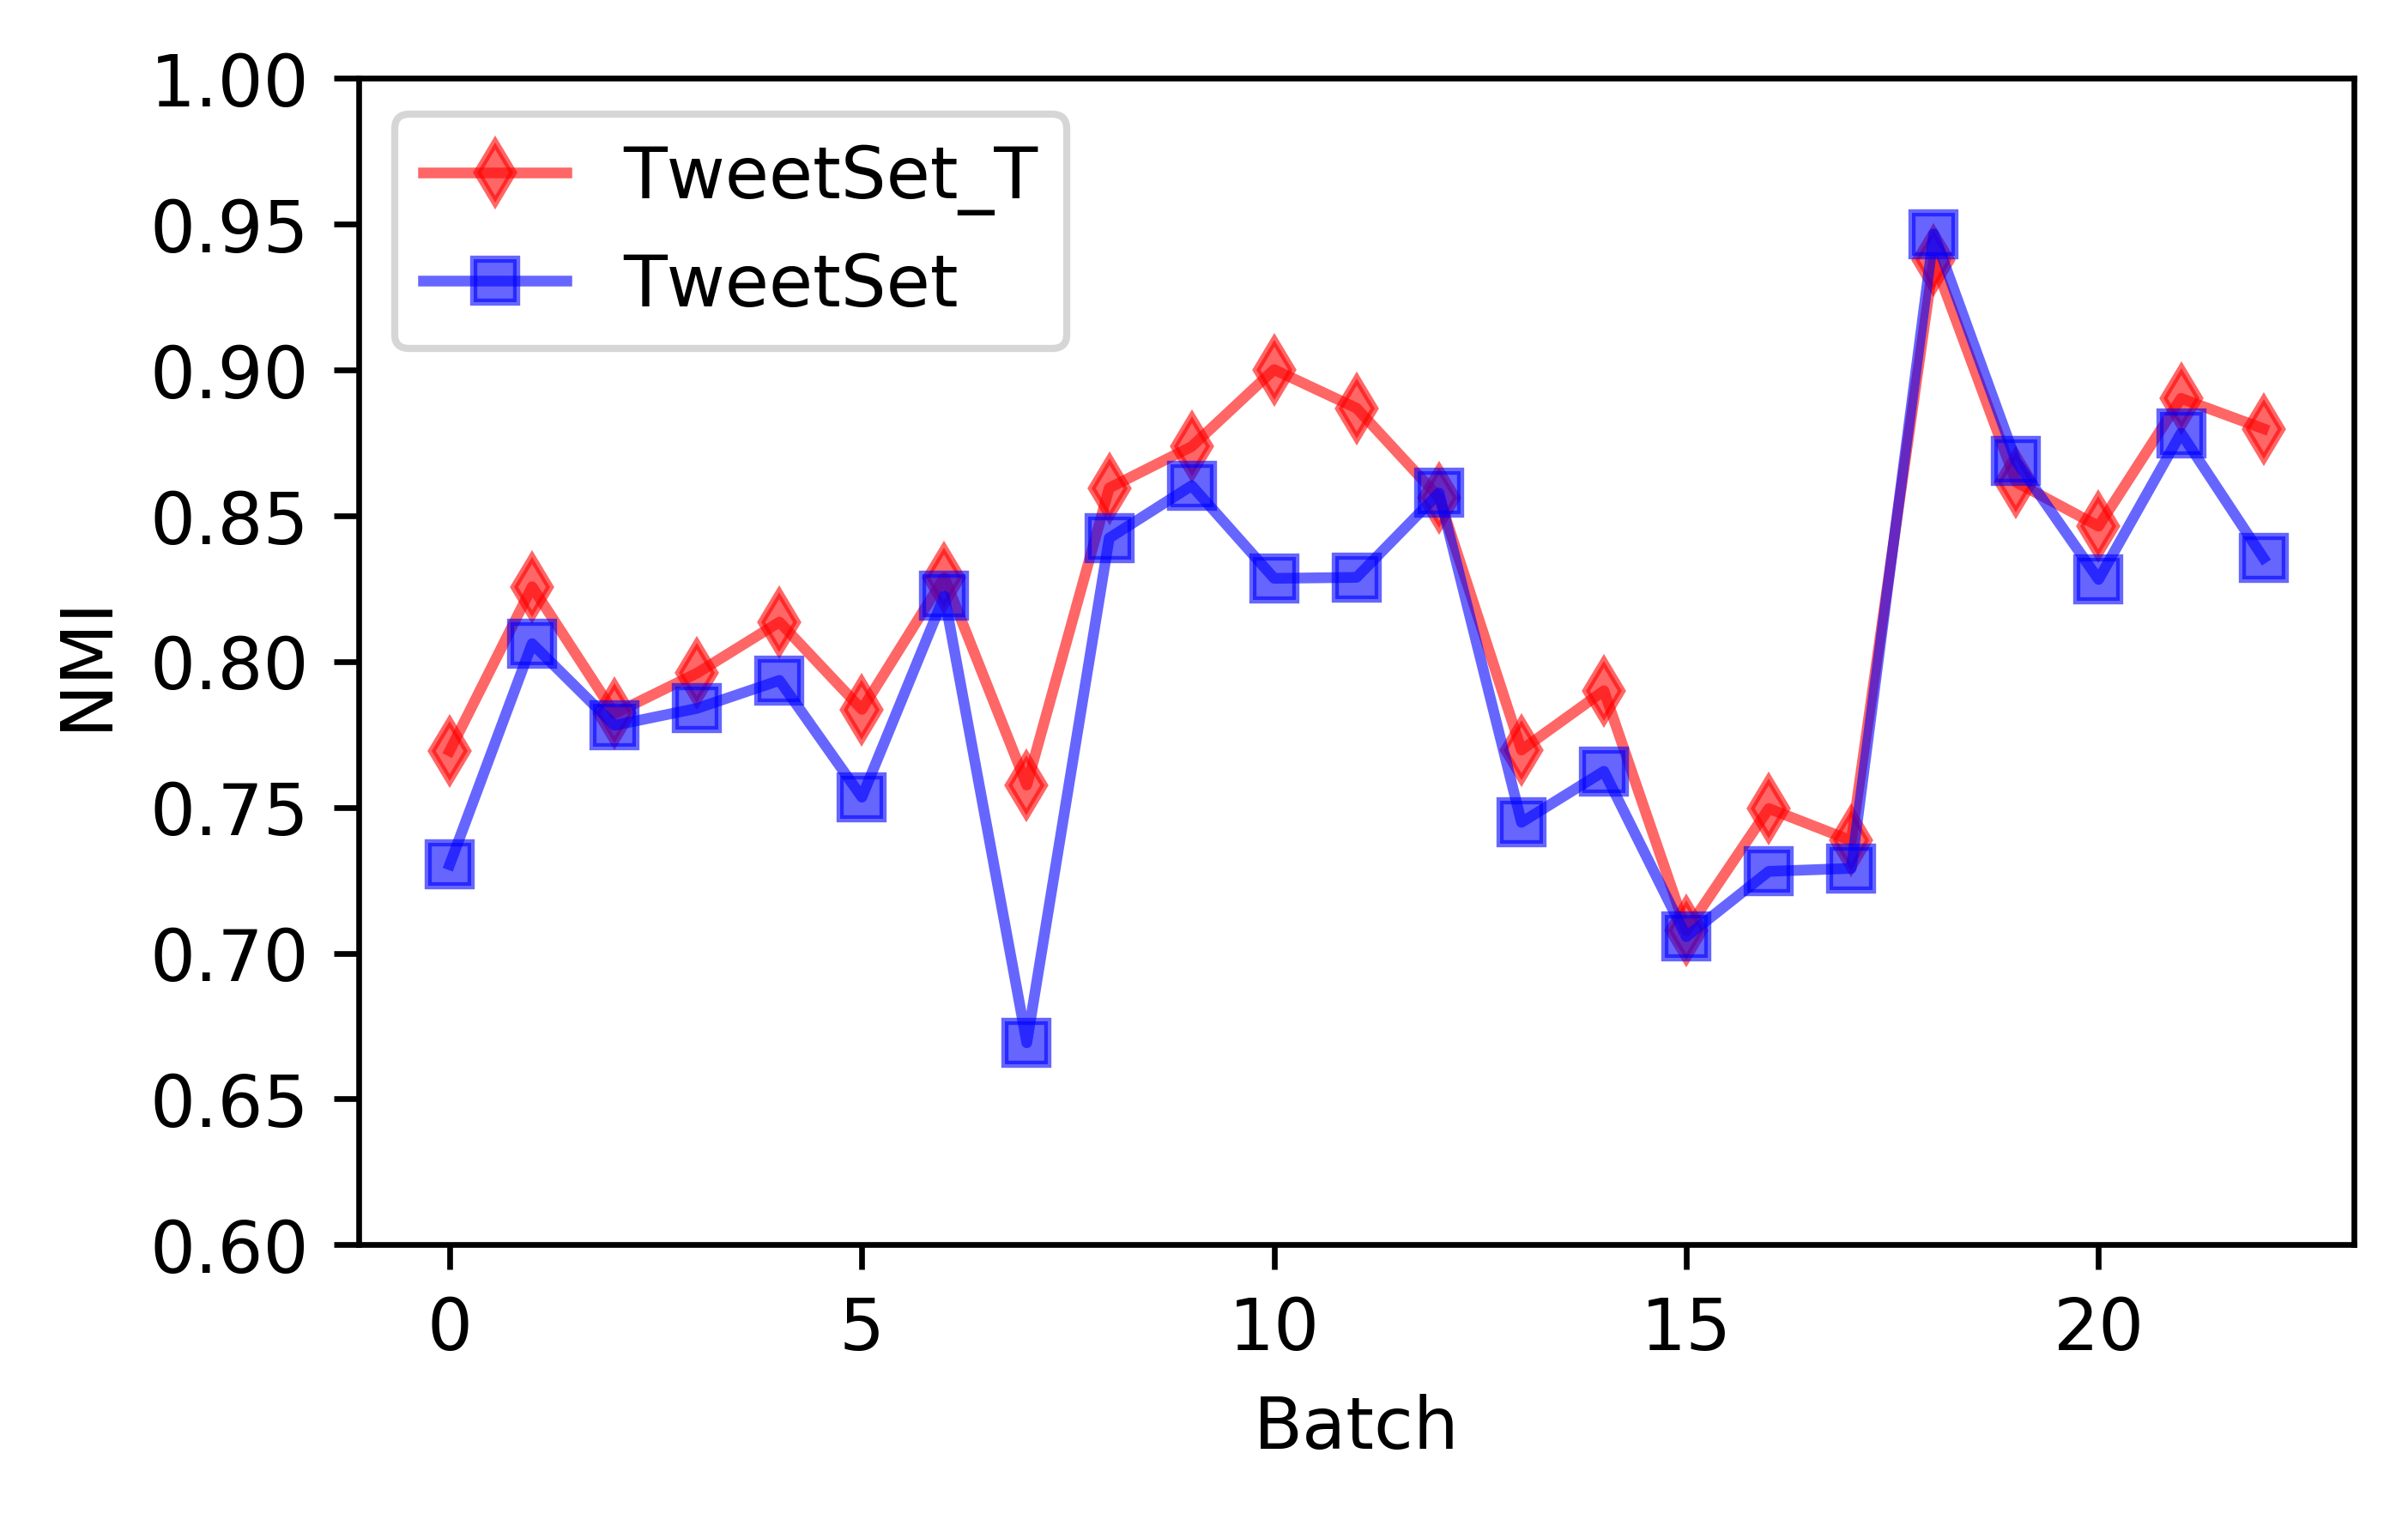

In [106]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
 
#设置x,y轴的数值（y=sinx）
#x = np.linspace(0, 10, 1000)
#y = np.sin(x)

x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

f = plt.figure(figsize=(5,3),dpi = 600)


tweets_T = [0.7693828291684766, 0.8256664037451413, 0.7821788529920924, 0.7960449165455996, 0.8135666714954576, 0.7835938629064161, 0.8288836927352627, 0.7576508105894485, 0.8595344525508966, 0.8737512957102533, 0.9001484071646036, 0.8868981586783966, 0.8562803616906821, 0.7696792858323661, 0.7900206907303219, 0.7076886839038332, 0.749608102365535, 0.7385885323263619, 0.9377288540023693, 0.8615467886621885, 0.8464187833492403, 0.8902738974167599, 0.8798569121323756]
#plt.plot(x, tweets_T, 'r', lw=1)
plt.plot( x,tweets_T, c= 'r',marker="d", alpha=0.6,label="TweetSet_T") 

tweets = [0.73034349000822, 0.806161181238402, 0.778141533591047, 0.7839554373849305, 0.7935442093304179, 0.7535018150978932, 0.8224826217585104, 0.6692736234876168, 0.8423626654881256, 0.8603375329991161, 0.8285488297161215, 0.8288801379349896, 0.8577950409799505, 0.7448757731367873, 0.7623943576450521, 0.7056719497529331, 0.728065085665258, 0.7290917222466677, 0.9466698302462141, 0.8687016169943131, 0.828170426376433, 0.8783703957857967, 0.8354943072995759]
#plt.plot(x, tweets, 'b', lw=1)
plt.plot( x,tweets, c= 'b',marker="s", alpha=0.6,label="TweetSet") 


plt.xlabel("Batch")
plt.ylabel("NMI")
 
#图表的标题
#plt.title("Performance")
 
#Y轴的范围
plt.ylim(0.6, 1.0)
 
#显示图示
plt.legend()
 
#显示图
plt.show()

f.savefig("NMIandInterationNews.pdf", bbox_inches='tight')


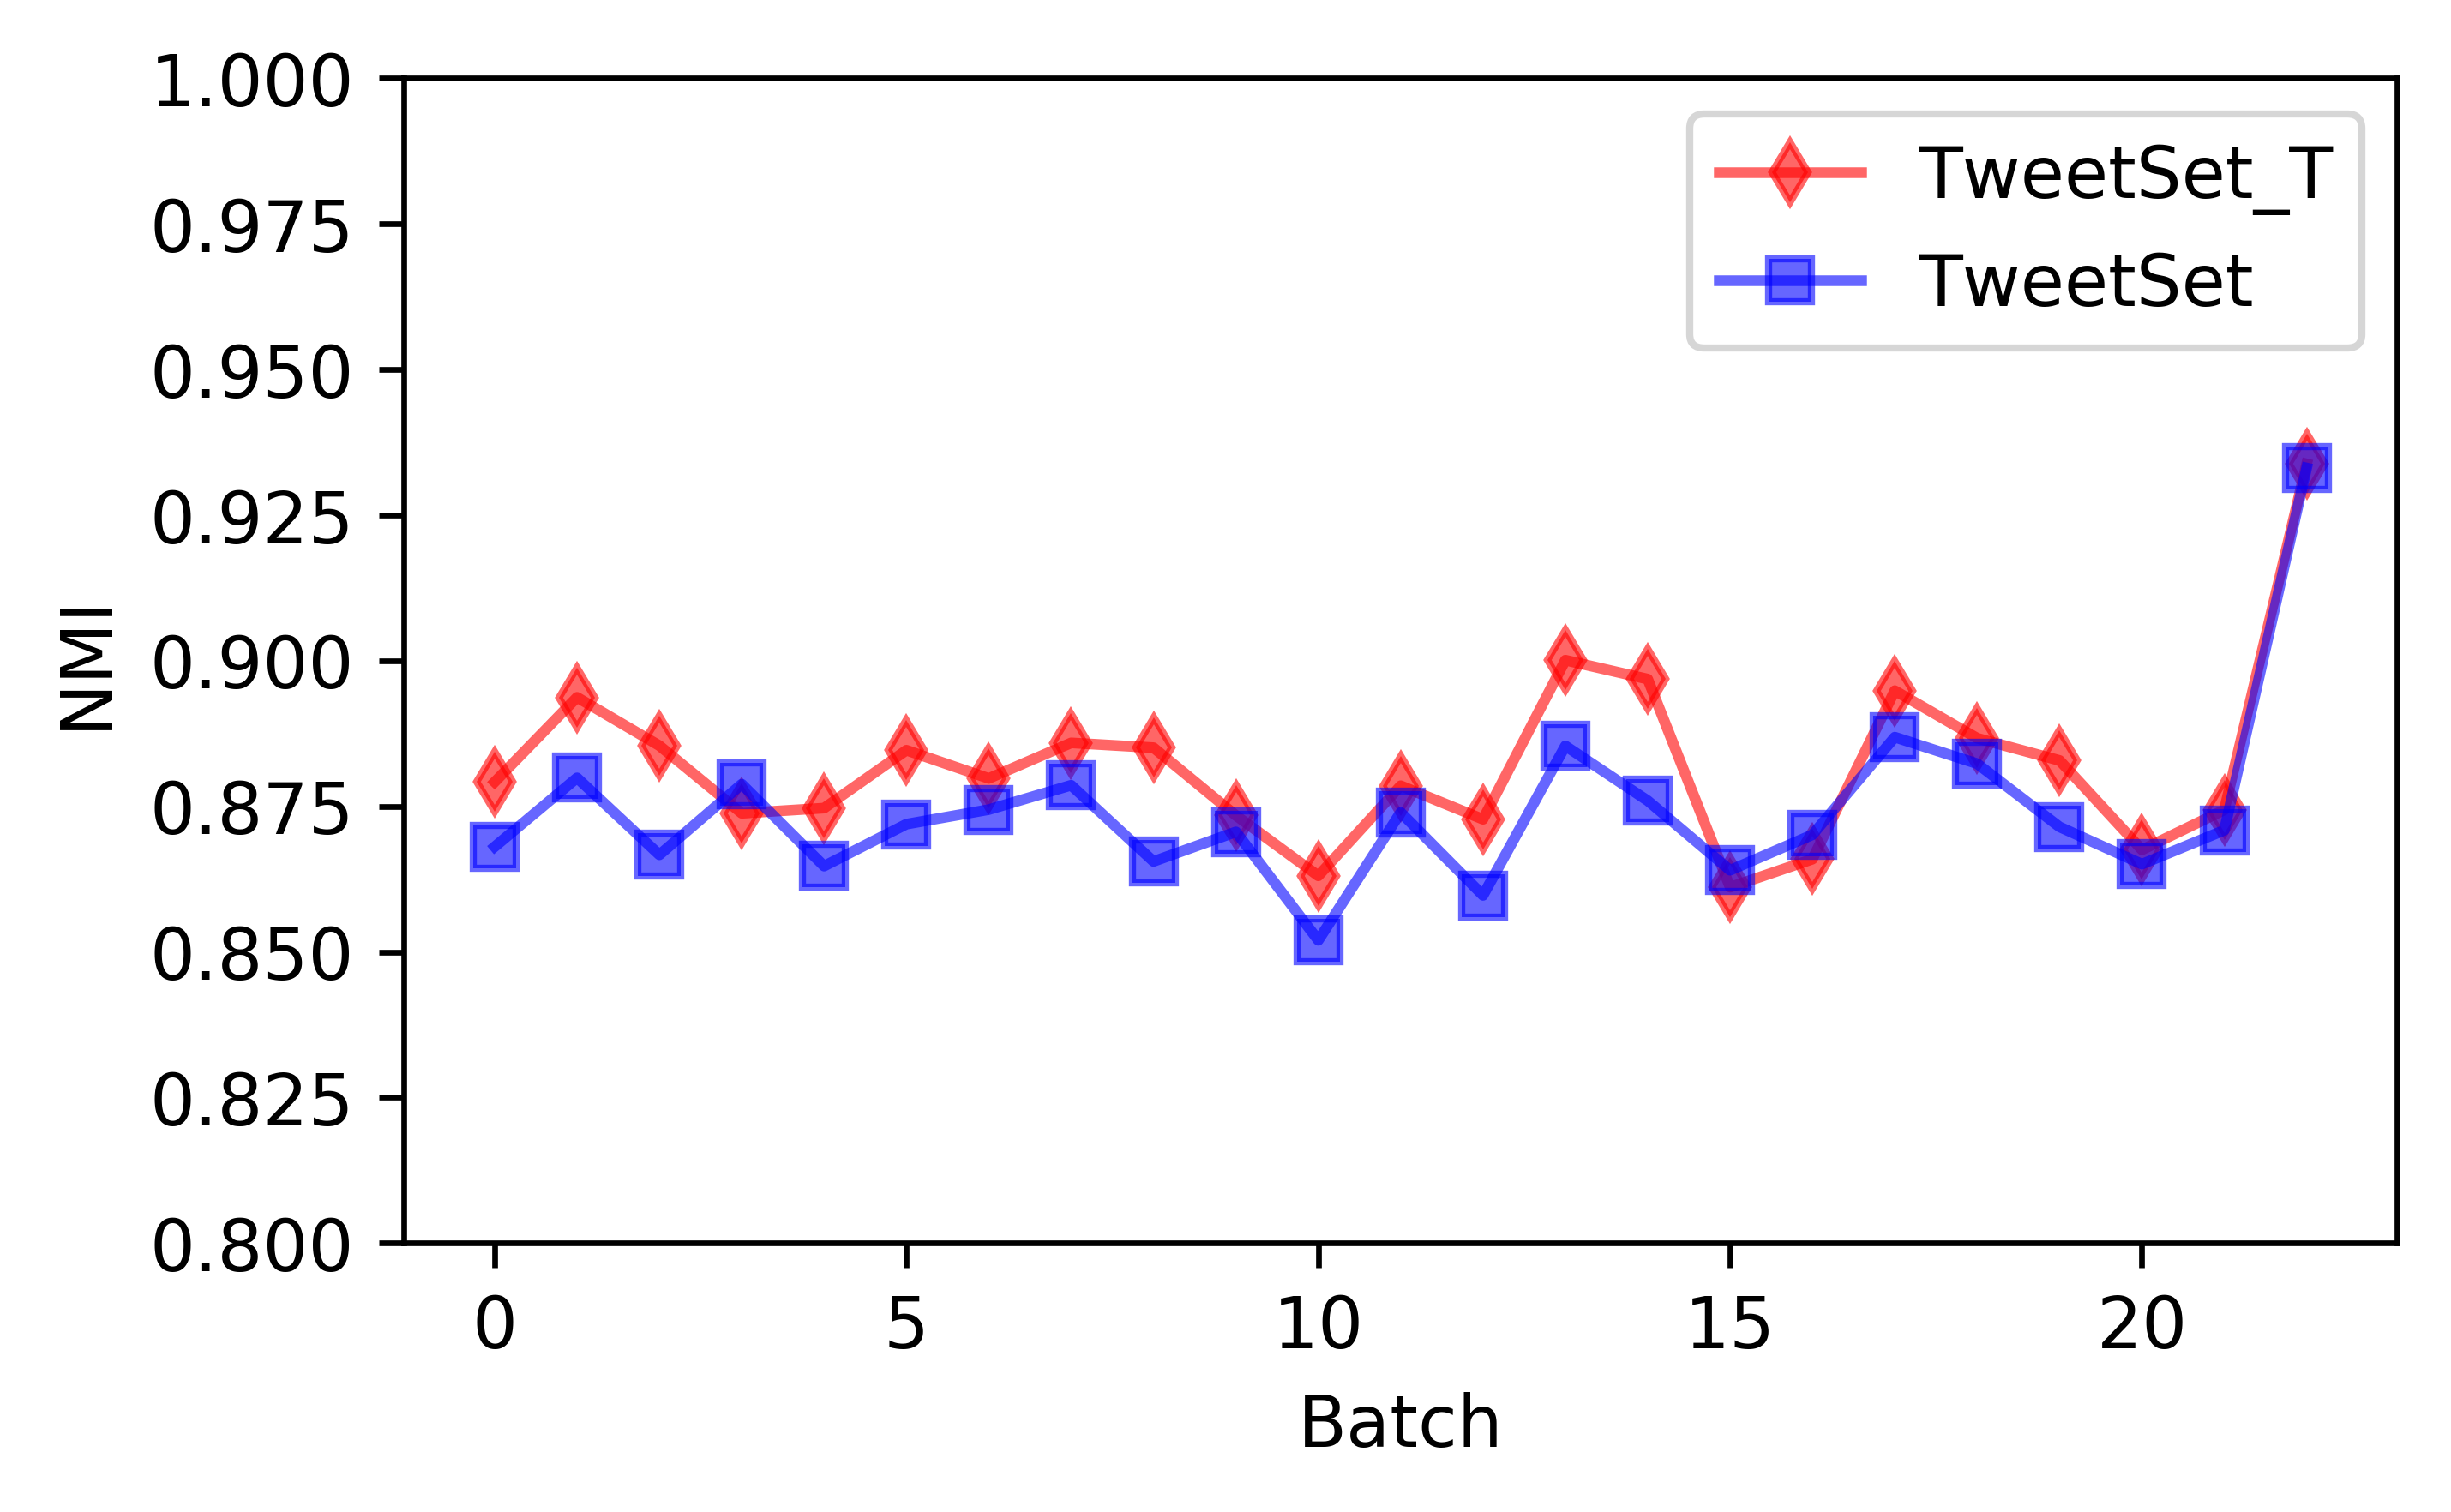

In [108]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
 
#设置x,y轴的数值（y=sinx）
#x = np.linspace(0, 10, 1000)
#y = np.sin(x)

x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

f = plt.figure(figsize=(5,3),dpi = 600)


tweets_T = [0.8791805038948407, 0.8937158083197261, 0.8854131405680493, 0.8738001043077092, 0.8746930240709452, 0.8846343567913099, 0.8797887769742514, 0.8858919495594026, 0.8850686576395707, 0.8734298806797398, 0.8630613891313728, 0.8785334303308567, 0.8727754213703827, 0.9000944577504156, 0.8968435215984851, 0.861111052183741, 0.8659280539963115, 0.8948565061771953, 0.8866989138895636, 0.8828716827662466, 0.8675271240071181, 0.8743931526755314, 0.933792482781334]
#plt.plot(x, tweets_T, 'r', lw=1)
plt.plot( x,tweets_T, c= 'r',marker="d", alpha=0.6,label="TweetSet_T") 

tweets = [0.868061147361903, 0.8798872378943048, 0.8666738099869422, 0.8788114317203642, 0.8647362424728778, 0.8719401308729202, 0.8744365437329099, 0.8786155296529312, 0.8655358395224317, 0.8706132760828348, 0.8519884966135349, 0.8739589339935312, 0.859705398362097, 0.8853741939893751, 0.8759650809425262, 0.8640226611733977, 0.870112374926721, 0.8868754405932372, 0.8823236917353228, 0.8714655827193495, 0.8650742696763974, 0.8708977258921735, 0.9330901876353538]
#plt.plot(x, tweets, 'b', lw=1)
plt.plot( x,tweets, c= 'b',marker="s", alpha=0.6,label="TweetSet") 


plt.xlabel("Batch")
plt.ylabel("NMI")
 
#图表的标题
#plt.title("Performance")
 
#Y轴的范围
plt.ylim(0.8, 1.0)
 
#显示图示
plt.legend()
 
#显示图
plt.show()

f.savefig("NMIandInterationNews.pdf", bbox_inches='tight')


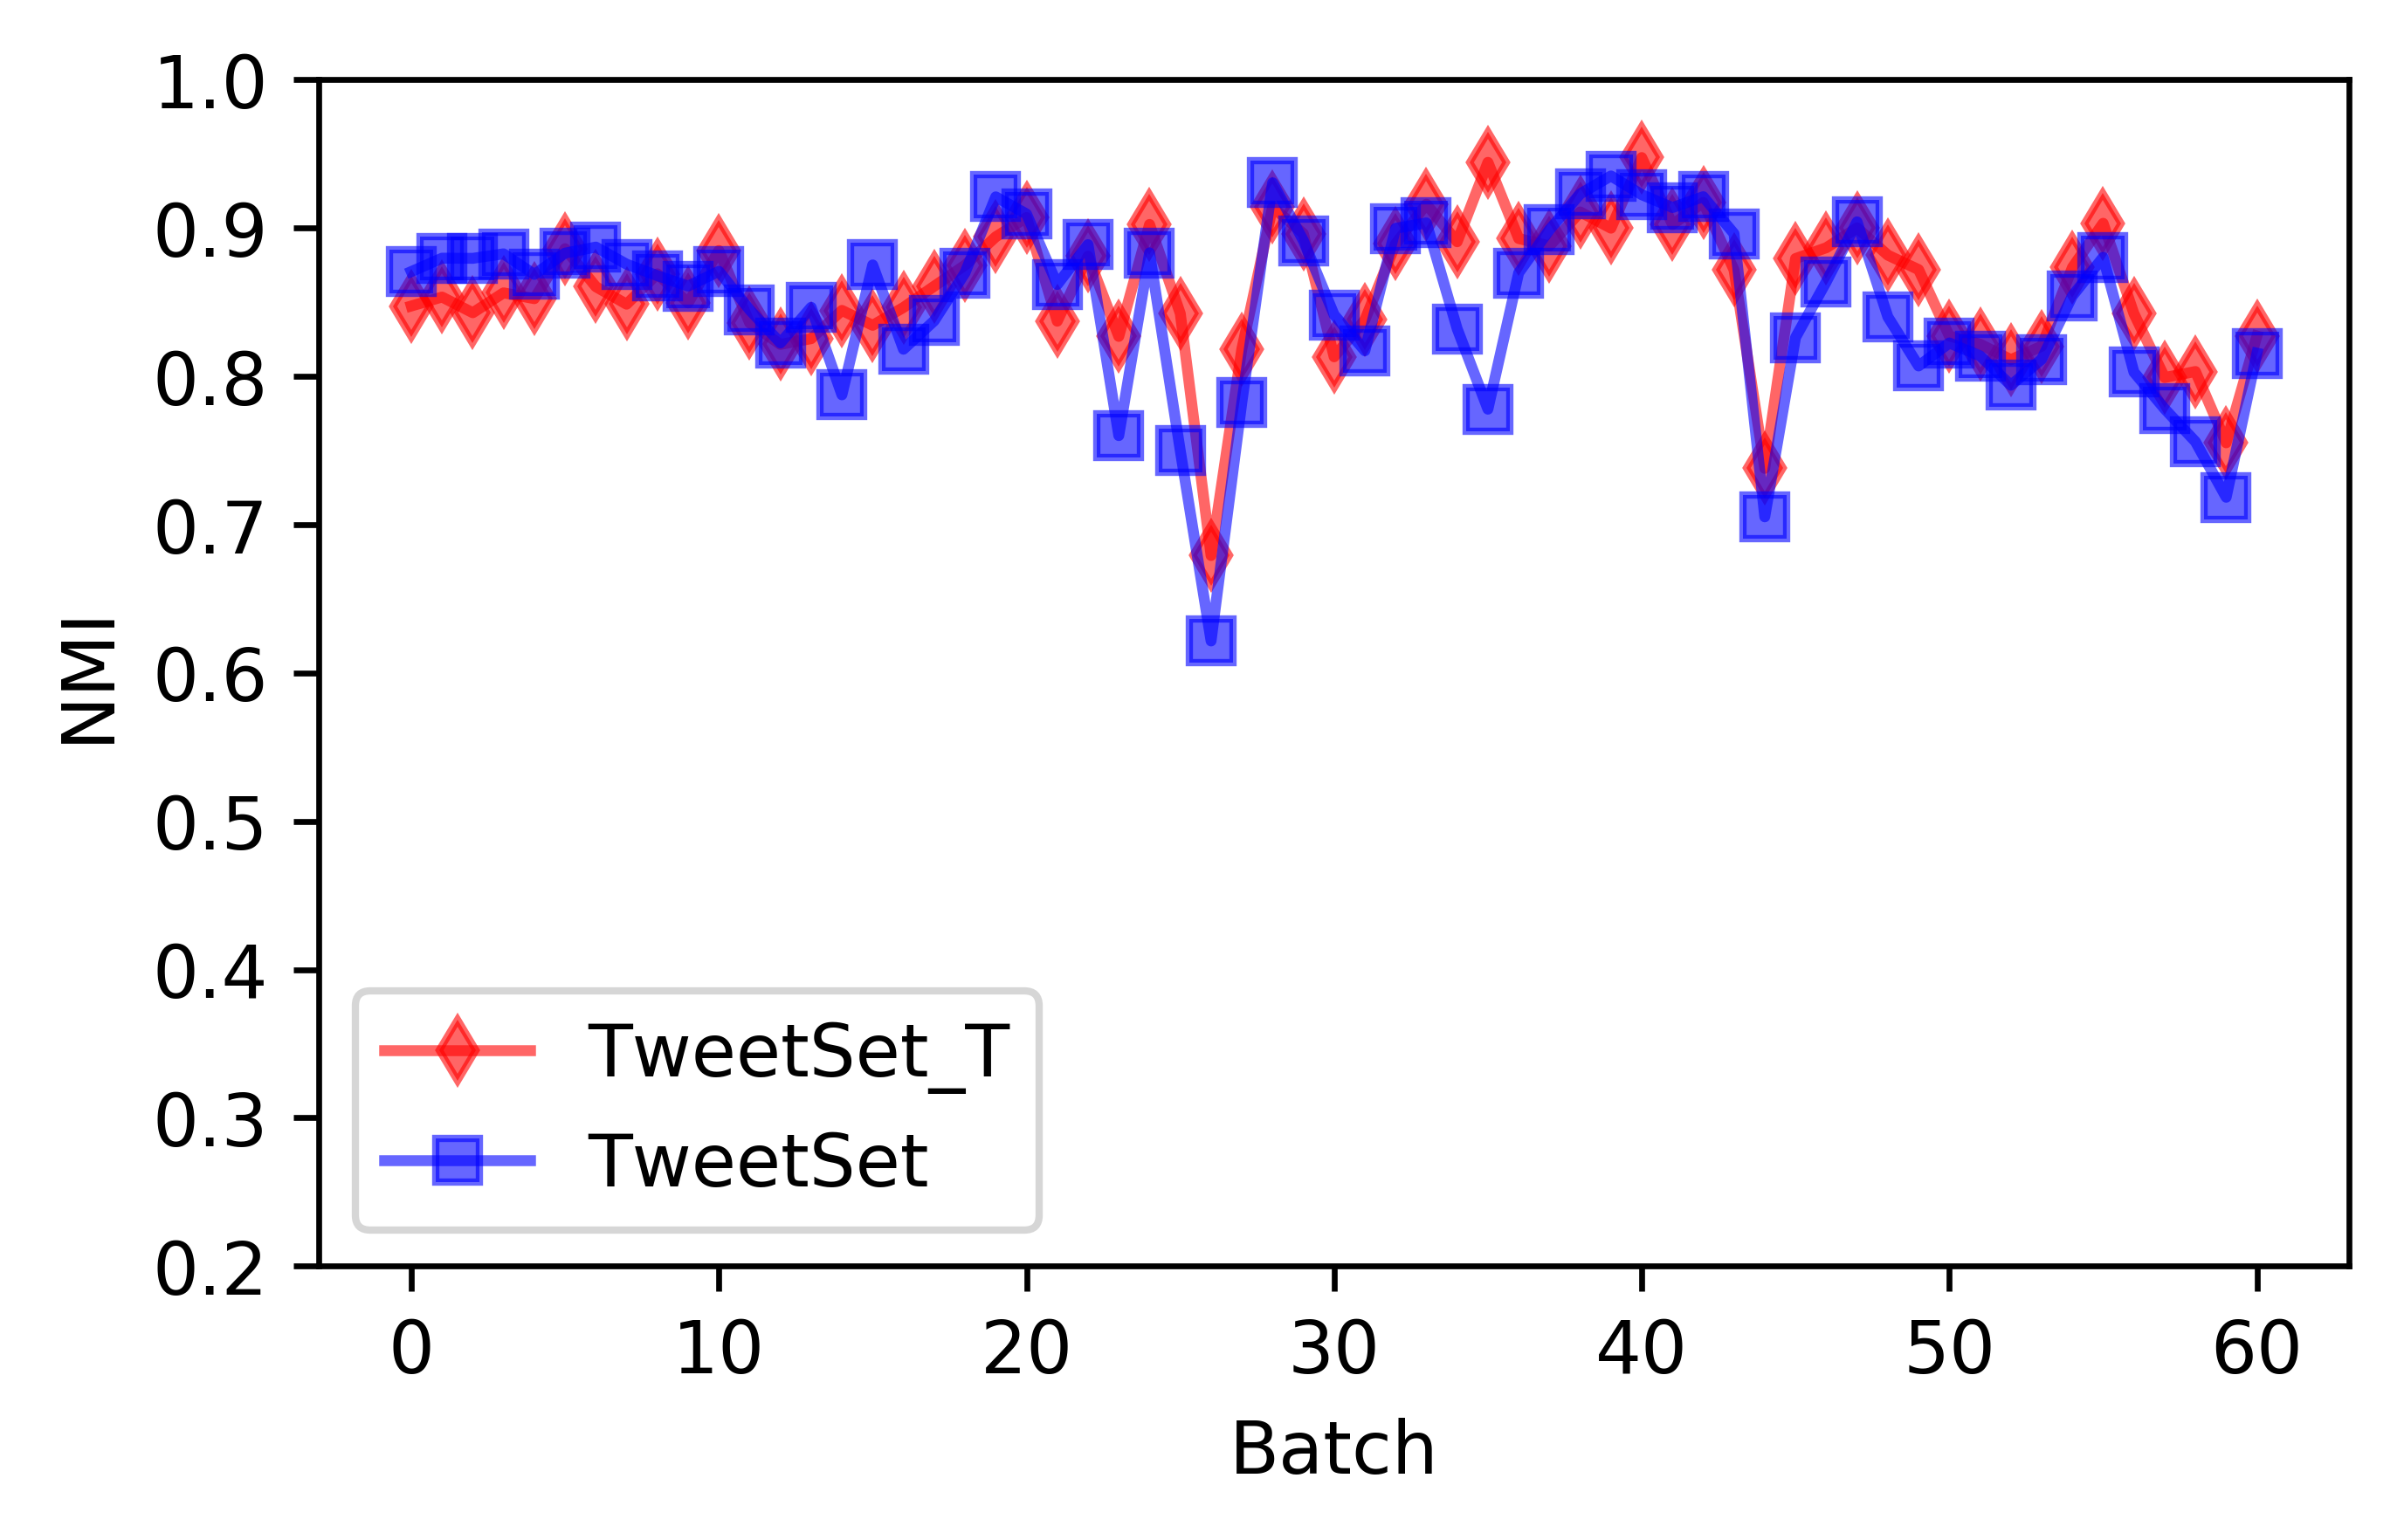

In [114]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
 
#设置x,y轴的数值（y=sinx）
#x = np.linspace(0, 10, 1000)
#y = np.sin(x)

x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]

f = plt.figure(figsize=(5,3),dpi = 600)


tweets_T = [0.8474288340533979, 0.8534737854841058, 0.8428782378743177, 0.856304660474624, 0.8523640295032716, 0.8860828017208211, 0.8604437694483016, 0.848645947842599, 0.8691456112814188, 0.8494774982467017, 0.8848503817879018, 0.8360336655931694, 0.8215379347028716, 0.8254042311193724, 0.8444627793160893, 0.8344013482122143, 0.8464515618826784, 0.8607882472150461, 0.8749153294529834, 0.8940796474350877, 0.9070813908670783, 0.8371736923048919, 0.8810047661205772, 0.826919043154165, 0.902442159481986, 0.8423354466586958, 0.6791729818435948, 0.8183968922783766, 0.9141425537322692, 0.8962373568774769, 0.8131660109078047, 0.8380398250494697, 0.8893618937496223, 0.9160824814403975, 0.8907418727550385, 0.944305858526963, 0.8929317345623905, 0.8879111091100845, 0.9108470126712936, 0.8999046104353755, 0.9475372307047819, 0.9023659397800806, 0.9172529938675, 0.8718172673303971, 0.7379505050723713, 0.879428069716036, 0.8867116531778506, 0.900130999851982, 0.8817268553046393, 0.8719628015275858, 0.8272025960107012, 0.8217122280540714, 0.8112675635094753, 0.8202820884090798, 0.8733863746579276, 0.9032069170040824, 0.8423441912558113, 0.7992065253243146, 0.8032661106986742, 0.7551789896348232, 0.8272459163091533]
#plt.plot(x, tweets_T, 'r', lw=1)
plt.plot( x,tweets_T, c= 'r',marker="d", alpha=0.6,label="TweetSet_T") 

tweets = [0.8706357621642623, 0.8796769159393303, 0.8795785805847165, 0.8826170650153089, 0.8687689994590512, 0.8830787553713371, 0.8871712186636257, 0.8756209338256866, 0.8678814218232146, 0.8608801205979035, 0.8708057265839233, 0.8448418541859802, 0.8225351990511073, 0.8465388414019068, 0.7875287082400818, 0.8751346648071325, 0.8182674703313176, 0.8374710014671842, 0.8697356126767268, 0.9210276225429206, 0.9094932750246095, 0.8619230293275061, 0.8888380737081923, 0.7600352937212681, 0.8832758268927459, 0.7497766674451585, 0.6215625675733031, 0.7823627030353043, 0.9305306936613431, 0.8915452941536436, 0.8414841809591624, 0.8172379840928004, 0.8998078195248874, 0.9034527177039665, 0.8321231204821626, 0.7778505674320496, 0.8697977918606407, 0.8988143813457629, 0.923050948848934, 0.9351298622845893, 0.9224902499976144, 0.9138155566651327, 0.9211319220358773, 0.8962391956542831, 0.7052611375657496, 0.8262147276566357, 0.8637830765891915, 0.904200904923131, 0.8401481934200871, 0.8069881436701297, 0.8225046611561337, 0.8137771755932796, 0.7939877380936777, 0.8115130310611817, 0.8542206073602772, 0.8802304512439981, 0.802864708174683, 0.7780556139315552, 0.7559564795527527, 0.718467221100008, 0.8156193634338176]
#plt.plot(x, tweets, 'b', lw=1)
plt.plot( x,tweets, c= 'b',marker="s", alpha=0.6,label="TweetSet") 


plt.xlabel("Batch")
plt.ylabel("NMI")
 
#图表的标题
#plt.title("Performance")
 
#Y轴的范围
plt.ylim(0.2, 1.0)
 
#显示图示
plt.legend()
 
#显示图
plt.show()

f.savefig("NMIandInterationNews.pdf", bbox_inches='tight')


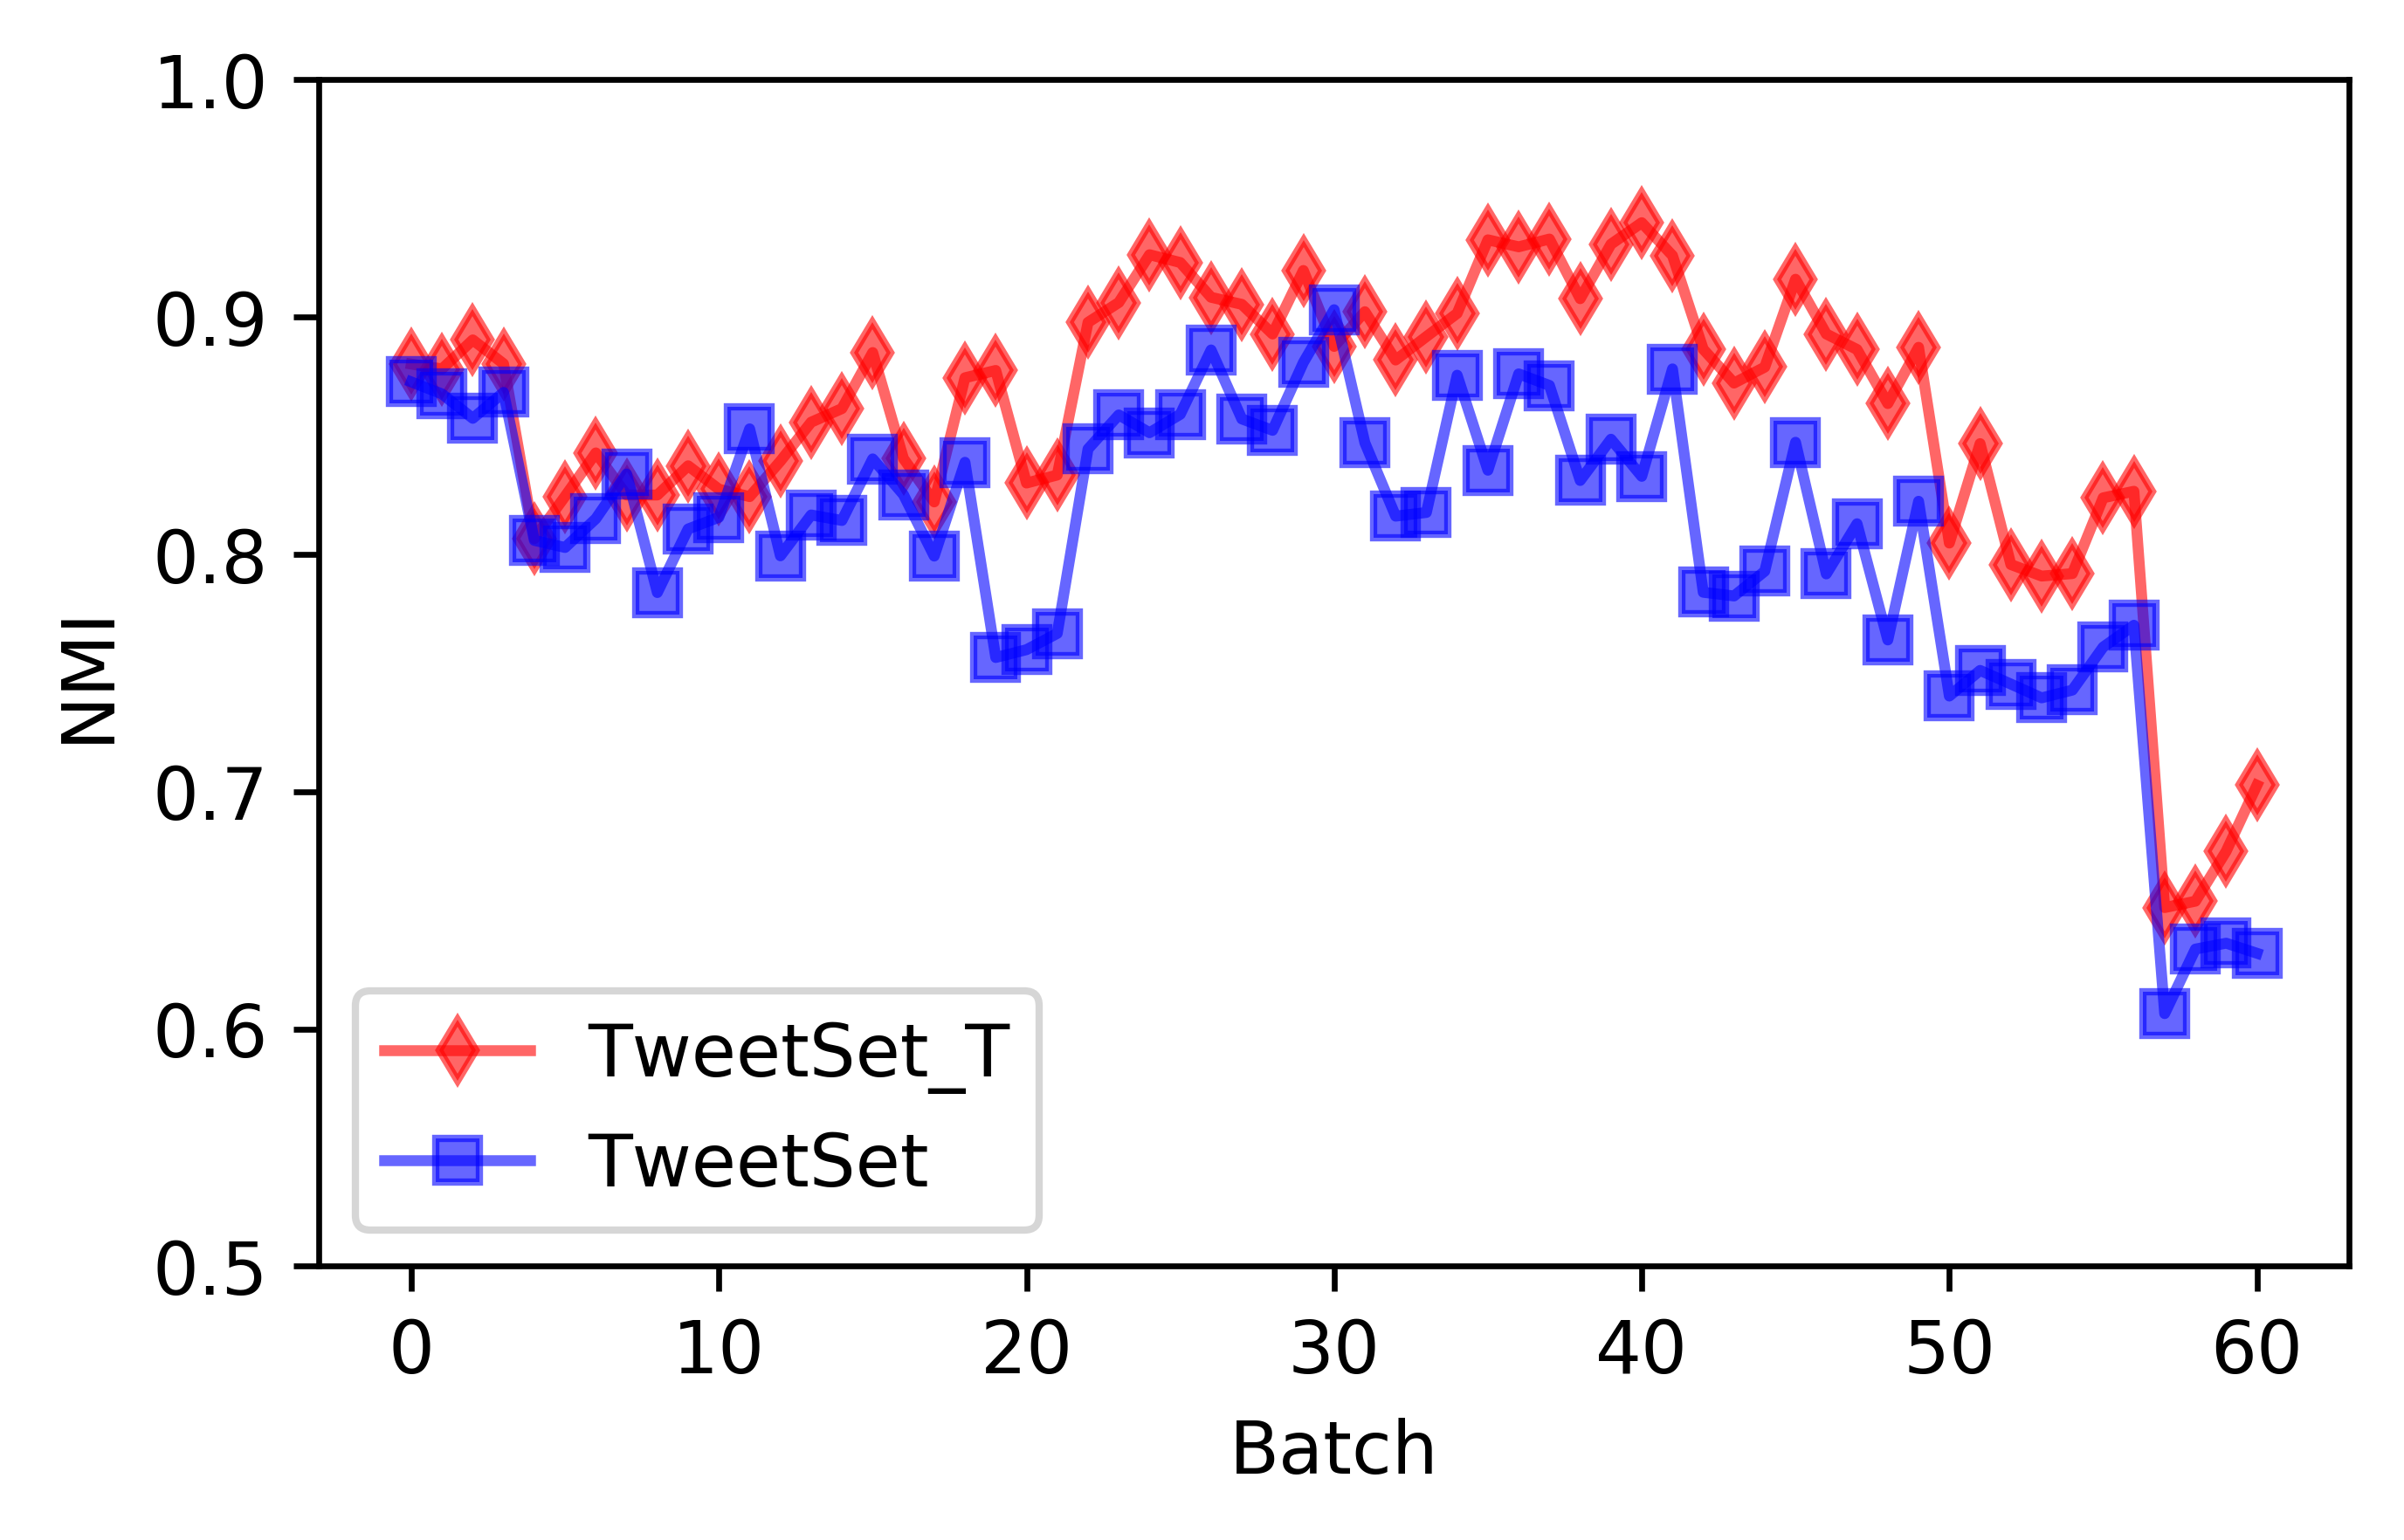

In [115]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
 
#设置x,y轴的数值（y=sinx）
#x = np.linspace(0, 10, 1000)
#y = np.sin(x)

x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]

f = plt.figure(figsize=(5,3),dpi = 600)


tweets_T = [0.880181128846321, 0.8781310441089455, 0.8903626031124846, 0.8802891820550155, 0.8065787161554409, 0.8244414545681393, 0.8427443074941608, 0.8249955372910738, 0.8249857718905035, 0.8373118759546907, 0.8274495385773019, 0.8243009403391134, 0.8392714729131685, 0.8556819033068159, 0.8614101236288397, 0.8850371548645493, 0.8403906752788657, 0.8220668353085563, 0.8744072197265904, 0.8774912503219744, 0.8300296696402276, 0.8334140813293694, 0.8977474954163979, 0.9061124878029874, 0.9262559650343551, 0.9229661598166313, 0.9083133309514114, 0.9053395054295947, 0.8928315213516842, 0.9196137968443262, 0.8876037759344444, 0.9022462055522564, 0.8818799347608985, 0.8917594478084228, 0.9015455645845137, 0.9325381132984558, 0.9295841377350417, 0.9328653390711169, 0.9077193070162694, 0.9306916480786396, 0.9397634573184117, 0.9258933591238503, 0.8864484439763445, 0.8721592079629906, 0.8788951163418408, 0.9159286572290315, 0.89285605171759, 0.8863104939466819, 0.8635172203456739, 0.8872433906897604, 0.8047278473360366, 0.8466606456306535, 0.7956908761013551, 0.7908289354019211, 0.7918652318451828, 0.8237996947481364, 0.8265739236481314, 0.6511147538598351, 0.6538073465596914, 0.6748867666141182, 0.7026920684190141]
#plt.plot(x, tweets_T, 'r', lw=1)
plt.plot( x,tweets_T, c= 'r',marker="d", alpha=0.6,label="TweetSet_T") 

tweets = [0.8726605907939735, 0.8675804430197828, 0.857304826685759, 0.8682370043076139, 0.8058693657441719, 0.8028725088191075, 0.8150120952507177, 0.8338597161814261, 0.7838781491638068, 0.8106797713934575, 0.8155879510220445, 0.8528779565040734, 0.799353783536827, 0.816582693487083, 0.8142516738258421, 0.8402179455940921, 0.8251509068778525, 0.799235719321006, 0.8387867406372057, 0.7565069853153767, 0.7598052021984403, 0.7666576624531032, 0.8443841044279784, 0.8587415678603442, 0.8512369731419017, 0.8590146736663141, 0.8861245377816359, 0.8570504736004817, 0.8522427111362259, 0.8808065855549296, 0.9030830013137033, 0.846988801027687, 0.8160848086165268, 0.8176371515322882, 0.8754814802790952, 0.8354283503849049, 0.8760448962403925, 0.871167365520681, 0.8311014699745355, 0.8485057115561949, 0.832852829738467, 0.878145055512655, 0.7840010277461492, 0.7824393746486666, 0.7928825097261403, 0.8472254481746347, 0.7917263523399012, 0.8128878853849416, 0.7638948730989237, 0.822362520707584, 0.7402647811537387, 0.7510779061885581, 0.7453206709119401, 0.7394976817507588, 0.742773287927932, 0.7609008379903228, 0.7701014495789237, 0.6064273075654667, 0.6336241643547837, 0.6361128707398974, 0.6318672267451614]
#plt.plot(x, tweets, 'b', lw=1)
plt.plot( x,tweets, c= 'b',marker="s", alpha=0.6,label="TweetSet") 


plt.xlabel("Batch")
plt.ylabel("NMI")
 
#图表的标题
#plt.title("Performance")
 
#Y轴的范围
plt.ylim(0.5, 1.0)
 
#显示图示
plt.legend()
 
#显示图
plt.show()

f.savefig("NMIandInterationNews.pdf", bbox_inches='tight')


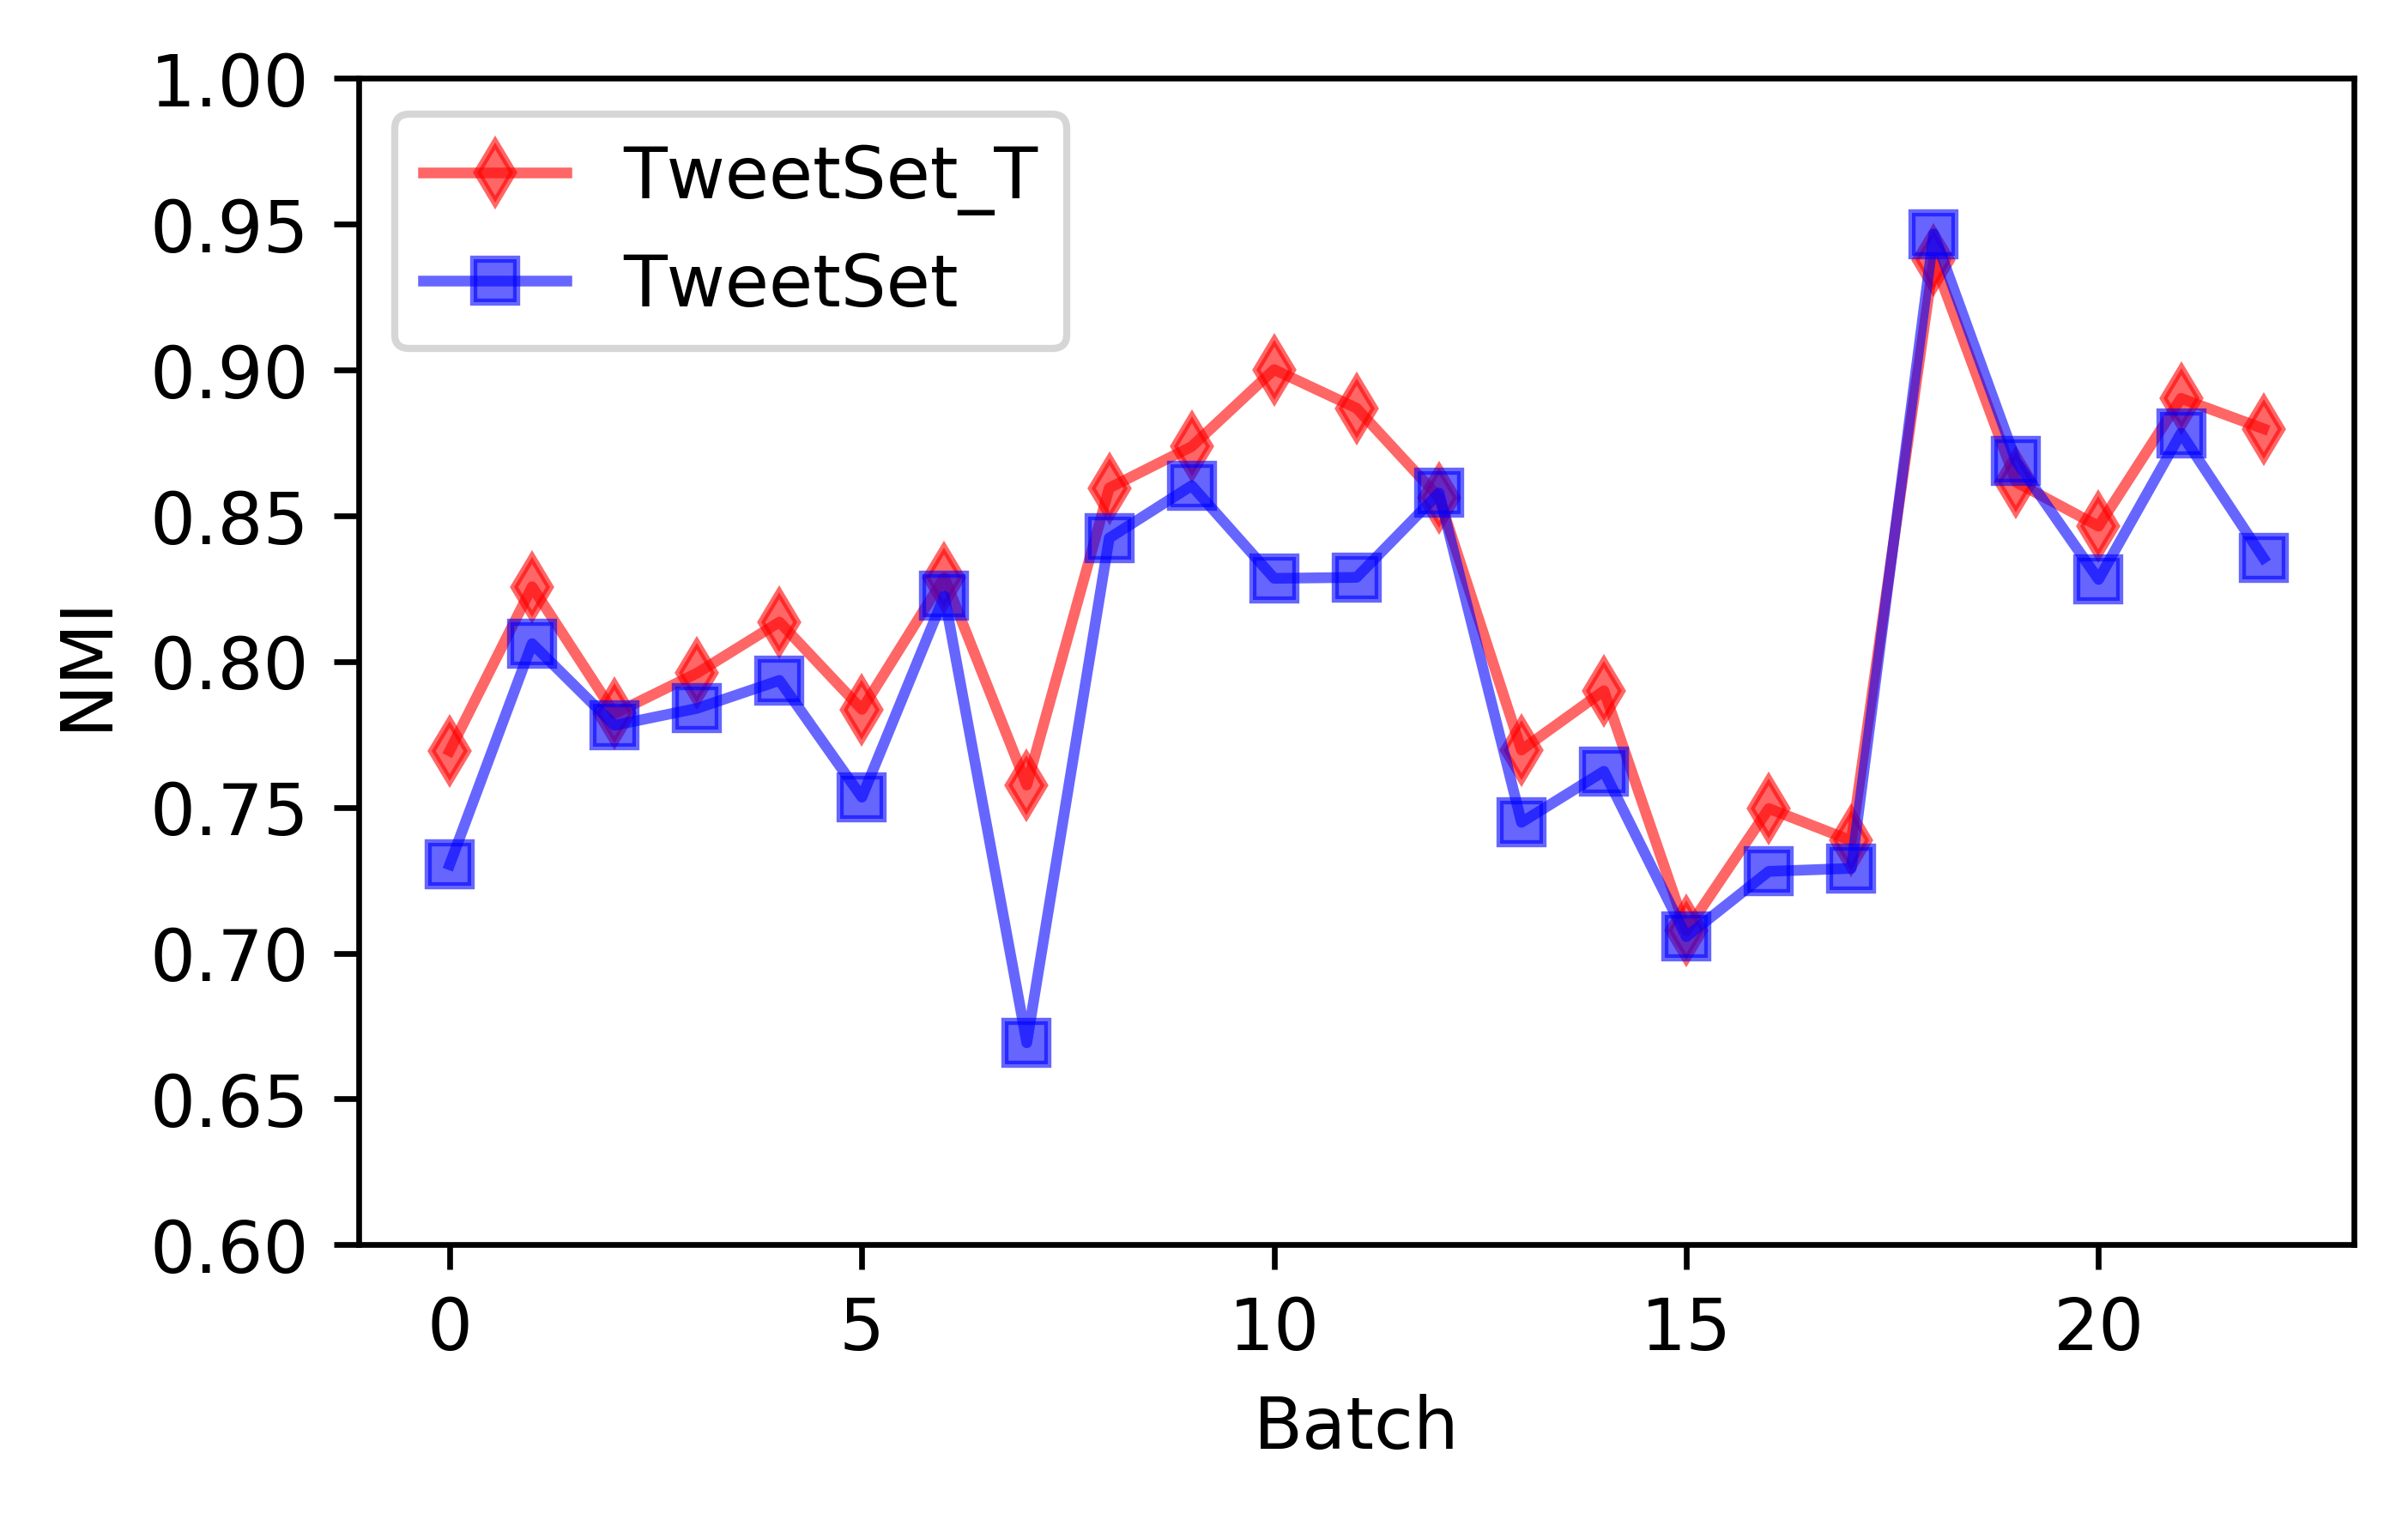

In [116]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
 
#设置x,y轴的数值（y=sinx）
#x = np.linspace(0, 10, 1000)
#y = np.sin(x)

x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

f = plt.figure(figsize=(5,3),dpi = 600)


tweets_T = [0.7693828291684766, 0.8256664037451413, 0.7821788529920924, 0.7960449165455996, 0.8135666714954576, 0.7835938629064161, 0.8288836927352627, 0.7576508105894485, 0.8595344525508966, 0.8737512957102533, 0.9001484071646036, 0.8868981586783966, 0.8562803616906821, 0.7696792858323661, 0.7900206907303219, 0.7076886839038332, 0.749608102365535, 0.7385885323263619, 0.9377288540023693, 0.8615467886621885, 0.8464187833492403, 0.8902738974167599, 0.8798569121323756]
#plt.plot(x, tweets_T, 'r', lw=1)
plt.plot( x,tweets_T, c= 'r',marker="d", alpha=0.6,label="TweetSet_T") 

tweets = [0.73034349000822, 0.806161181238402, 0.778141533591047, 0.7839554373849305, 0.7935442093304179, 0.7535018150978932, 0.8224826217585104, 0.6692736234876168, 0.8423626654881256, 0.8603375329991161, 0.8285488297161215, 0.8288801379349896, 0.8577950409799505, 0.7448757731367873, 0.7623943576450521, 0.7056719497529331, 0.728065085665258, 0.7290917222466677, 0.9466698302462141, 0.8687016169943131, 0.828170426376433, 0.8783703957857967, 0.8354943072995759]
#plt.plot(x, tweets, 'b', lw=1)
plt.plot( x,tweets, c= 'b',marker="s", alpha=0.6,label="TweetSet") 


plt.xlabel("Batch")
plt.ylabel("NMI")
 
#图表的标题
#plt.title("Performance")
 
#Y轴的范围
plt.ylim(0.6, 1.0)
 
#显示图示
plt.legend()
 
#显示图
plt.show()

f.savefig("NMIandInterationNews.pdf", bbox_inches='tight')


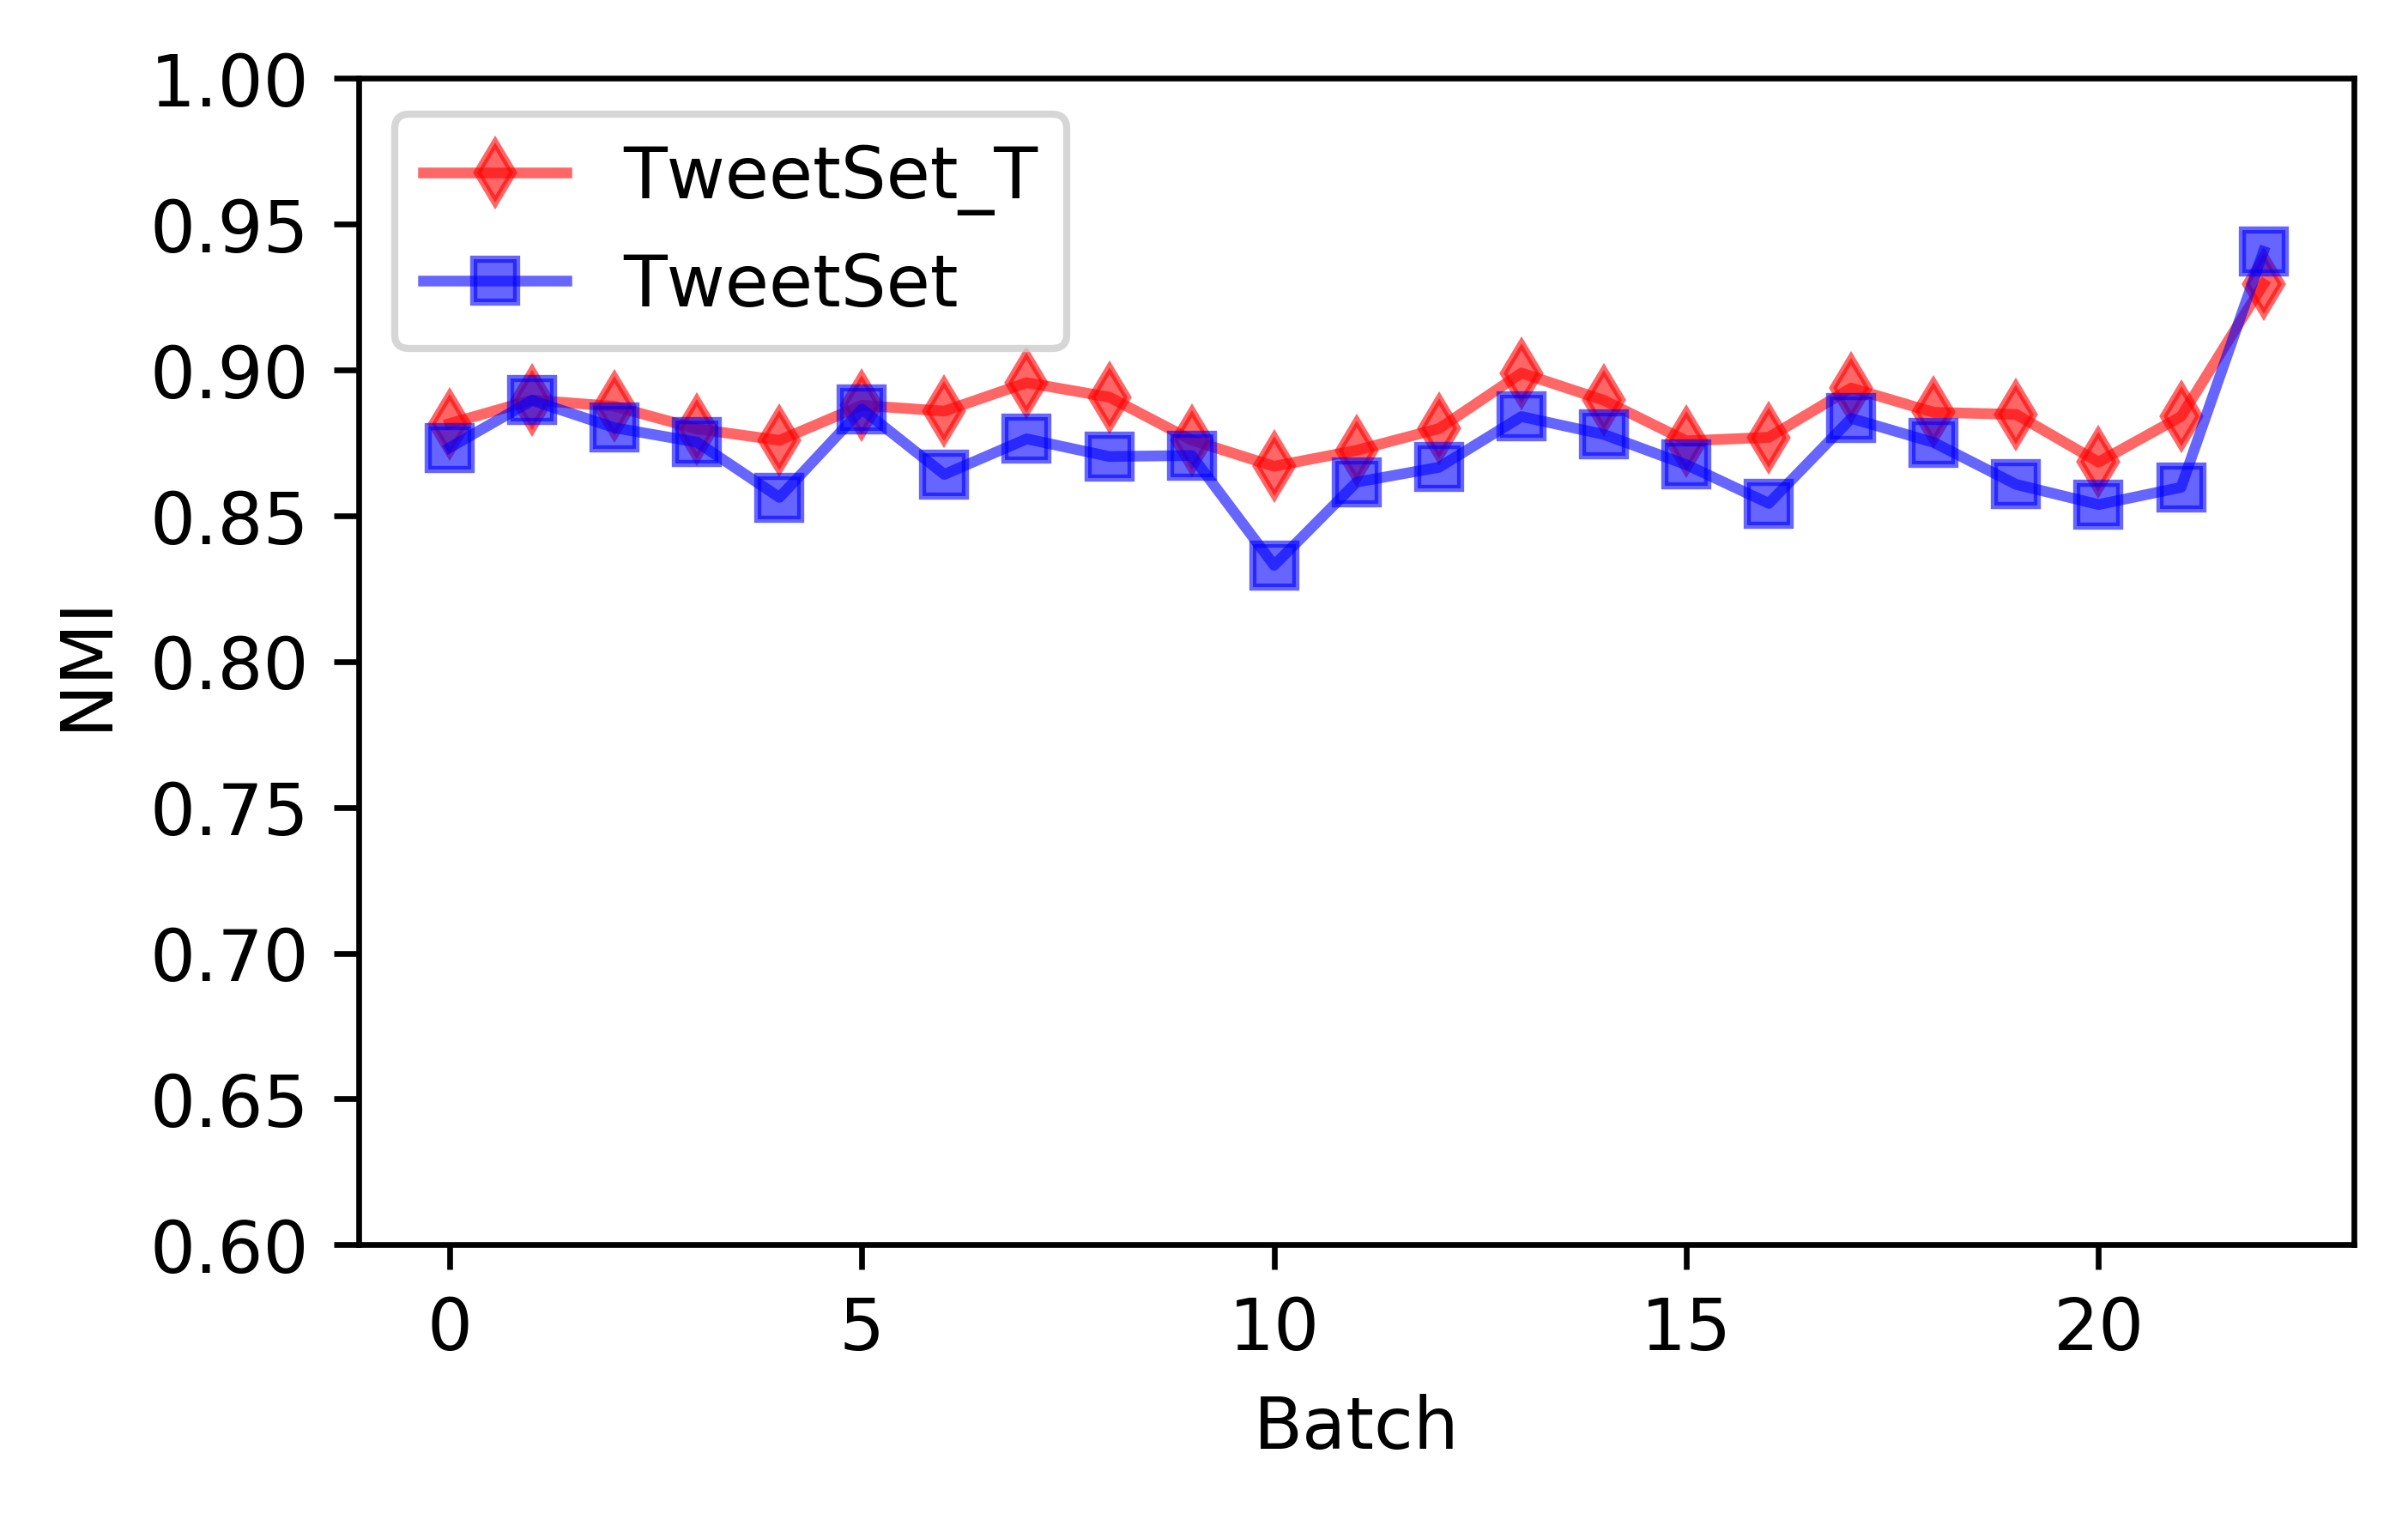

In [118]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
 
#设置x,y轴的数值（y=sinx）
#x = np.linspace(0, 10, 1000)
#y = np.sin(x)

x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

f = plt.figure(figsize=(5,3),dpi = 600)


tweets_T = [0.8816253485292893, 0.8896958498673855, 0.887547430347356, 0.8798078001390809, 0.8758785113006561, 0.8878789420209223, 0.8858948989230734, 0.8956560454451744, 0.8906988343883995, 0.8759524080214447, 0.8669809275843139, 0.8724444083741711, 0.8799065794215711, 0.8989565220960359, 0.8896116490251628, 0.8756882119257414, 0.8769124306982721, 0.8938102522988703, 0.8854914948128427, 0.8847628129754427, 0.8684046082432879, 0.8840466577094394, 0.929462199547604]
#plt.plot(x, tweets_T, 'r', lw=1)
plt.plot( x,tweets_T, c= 'r',marker="d", alpha=0.6,label="TweetSet_T") 

tweets = [0.8733783854471778, 0.8895828061564554, 0.8801888850415923, 0.8752502592070706, 0.8563038644566505, 0.8865714632606962, 0.8641895107986892, 0.8763822324716068, 0.8703355435119114, 0.8706727266683166, 0.833012711023673, 0.8615327612812507, 0.8666451574713196, 0.8840190861835039, 0.8778961861111447, 0.8675249546525353, 0.8542536800389507, 0.8834162473954633, 0.8751473350721142, 0.8607638065097873, 0.8538485595700438, 0.8597438871898586, 0.9406658142099612]
#plt.plot(x, tweets, 'b', lw=1)
plt.plot( x,tweets, c= 'b',marker="s", alpha=0.6,label="TweetSet") 


plt.xlabel("Batch")
plt.ylabel("NMI")
 
#图表的标题
#plt.title("Performance")
 
#Y轴的范围
plt.ylim(0.6, 1.0)
 
#显示图示
plt.legend()
 
#显示图
plt.show()

f.savefig("NMIandInterationNews.pdf", bbox_inches='tight')


In [122]:
total_batch = 16
NMI_batch = {}
start = 0
end = 0
topic_batch = {}
for batch_i in range(1,17):
    if batch_i == 16:
        end = int(len(corpus))
    else:
        end = int(len(corpus) / total_batch) * batch_i
    
    docID_assign_z = {}
    m_z = {}
    n_z = {}
    n_w = {}
    n_b = {}
    Topics = []
    V = set()
    D = set()
    alpha = 0.6
    beta = 0.6
    NMI_batch[batch_i] = 0
    topic_batch[batch_i] = 0
    
    total_iter = 10
    for iter in range(total_iter):
        for docID in range(start,end):
            words = corpus[docID]
            D.discard(docID)
            if docID in docID_assign_z.keys():
                before_k = docID_assign_z[docID]
                m_z[before_k].discard(docID)
                for biterm in words:
                    for word in biterm.split(','):
                        n_z[before_k][word] -= 1
                        n_w[before_k] -=1
            else:
                before_k = -1
            if len(D) == 0 and len(V) == 0:
                choose_k = 0
                D.add(docID)
                docID_assign_z[docID] = choose_k
                if choose_k not in m_z.keys():
                    m_z[choose_k] = set()
                m_z[choose_k].add(docID)
                for biterm in words:
                    for word in biterm.split(','):
                        if choose_k not in n_w.keys():
                            n_w[choose_k] = 0
                        if choose_k not in n_z.keys():
                            n_z[choose_k] = {}
                        if word not in n_z[choose_k].keys():
                            n_z[choose_k][word] = 0
                        n_z[choose_k][word] += 1
                        n_w[choose_k] += 1
                        V.add(word)
                if choose_k not in Topics:
                    Topics.append(choose_k)
            else:
                log_pro = []
                for k in Topics:
                    pro_k = len(m_z[k])
                    if pro_k != 0:
                        i = 0
                        for biterm in words:
                            each_word = biterm.strip().split(',')
                            for word in each_word:
                                if word not in n_z[k].keys():
                                    n_z[k][word] = 0
                            for j in range(doc_biterm[docID][biterm]):
                                pro_k *= (n_z[k][each_word[0]] + n_z[k][each_word[-1]] + beta + j) / ( n_w[k] + len(V)*beta + i) 
                                i += 1

                    if pro_k == 0:
                        pro_k = sys.float_info.min
                    log_pro.append(pro_k)

                pro_new_k = alpha*(len(D))
                i = 0
                for biterm in words:
                    for j in range(doc_biterm[docID][biterm]):
                        pro_new_k *= ( beta + j) / ( len(V)*beta + i) 
                        i += 1

                if pro_new_k == 0:
                    pro_new_k = sys.float_info.min        
                log_pro.append(pro_new_k)

                sum_pro=sum(log_pro)

                normalized_posterior = [i/sum_pro for i in log_pro]    
                select_k = None
                if iter == (total_iter - 1):
                    select_k = normalized_posterior.index(max(normalized_posterior))

                else:
                    select_k = np.random.choice( (len(Topics)+1) , 1, p=normalized_posterior)[0]  

                if select_k == len(Topics):
                    choose_k = np.max(Topics) + 1
                else:
                    choose_k = Topics[select_k]

                D.add(docID)
                docID_assign_z[docID] = choose_k
                if choose_k not in m_z.keys():
                    m_z[choose_k] = set()
                m_z[choose_k].add(docID)
                for biterm in words:
                    for word in biterm.split(','):
                        if choose_k not in n_w.keys():
                            n_w[choose_k] = 0
                        if choose_k not in n_z.keys():
                            n_z[choose_k] = {}
                        if word not in n_z[choose_k].keys():
                            n_z[choose_k][word] = 0
                        n_z[choose_k][word] += 1
                        n_w[choose_k] += 1
                        V.add(word)
                if choose_k not in Topics:
                    Topics.append(choose_k)

            count_k = []
            for k in Topics:
                if k in m_z.keys() and len(m_z[k]) == 0:
                    m_z.pop(k, None)
                    n_z.pop(k, None)
                    n_w.pop(k, None)
                    count_k.append(k)
            for k in count_k:
                Topics.remove(k)   
        if iter == 9:
            from sklearn.metrics.cluster import normalized_mutual_info_score
            nmi_sample = []
            nmi_result = []
            for key, value in news_labels.items():
                if key < end and key >= start:
                    nmi_sample.append(value)
                    nmi_result.append(docID_assign_z[key])
            NMI_batch[batch_i] = normalized_mutual_info_score(np.array(nmi_sample), np.array(nmi_result))
            topic_batch[batch_i] = len(Topics)
            print("start ",start, " end ",end, "topics: ",len(Topics),"truth: ",len(np.unique(nmi_sample)), " NMI: ",normalized_mutual_info_score(np.array(nmi_sample), np.array(nmi_result)))
    if batch_i != 1:
        start = int(len(corpus) / total_batch) * (batch_i -1) + 1
    

start  0  end  694 topics:  22 truth:  7  NMI:  0.8759048916869383
start  0  end  1388 topics:  33 truth:  14  NMI:  0.8797451474021201
start  695  end  2082 topics:  22 truth:  15  NMI:  0.8797869994941283
start  1389  end  2776 topics:  24 truth:  16  NMI:  0.8833420322343979
start  2083  end  3470 topics:  33 truth:  22  NMI:  0.7831587604022162
start  2777  end  4164 topics:  35 truth:  20  NMI:  0.8738447965334856
start  3471  end  4858 topics:  19 truth:  20  NMI:  0.8908468219324178
start  4165  end  5552 topics:  27 truth:  20  NMI:  0.943990792133139
start  4859  end  6246 topics:  24 truth:  13  NMI:  0.935211571218045
start  5553  end  6940 topics:  20 truth:  12  NMI:  0.8752121424728659
start  6247  end  7634 topics:  29 truth:  17  NMI:  0.8463056003856061
start  6941  end  8328 topics:  27 truth:  17  NMI:  0.7903202133004384
start  7635  end  9022 topics:  28 truth:  14  NMI:  0.8458677599412084
start  8329  end  9716 topics:  39 truth:  35  NMI:  0.8767506791768355
sta

In [123]:
common_keys = []

item_NMI = []
for key,value in sorted(NMI_batch.items(), key=lambda x: x[0]):
    common_keys.append(key)
    item_NMI.append(value)
print(common_keys)

print()

print(item_NMI)
print(np.mean(item_NMI))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

[0.8759048916869383, 0.8797451474021201, 0.8797869994941283, 0.8833420322343979, 0.7831587604022162, 0.8738447965334856, 0.8908468219324178, 0.943990792133139, 0.935211571218045, 0.8752121424728659, 0.8463056003856061, 0.7903202133004384, 0.8458677599412084, 0.8767506791768355, 0.8572202288712705, 0.8227823324429654]
0.8662681731017549


In [121]:
common_keys = []

item_NMI = []
for key,value in sorted(NMI_batch.items(), key=lambda x: x[0]):
    common_keys.append(key)
    item_NMI.append(value)
print(common_keys)

print()

print(item_NMI)
print(np.mean(item_NMI))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

[0.8164259970864922, 0.8533673171438798, 0.8798334899221967, 0.8798069737710016, 0.7996856935774389, 0.8711507060291649, 0.8690309380691408, 0.9395164860415708, 0.9356990373174181, 0.9274903096684697, 0.8206775852728239, 0.8241923161038563, 0.8072837212664844, 0.8589295767580816, 0.8778726257606015, 0.8447012321230362]
0.8628540003694787
